<a href="https://colab.research.google.com/github/MatiasNazareth1993-coder/Virtual-cell/blob/main/Virtual_Cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Synthetic Telomere Regulation Model (STRM)
# PyTorch-style pseudocode for in silico telomere optimization

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class TelomereRegulator(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=256, output_dim=1):
        super(TelomereRegulator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def forward(self, x):
        x = F.gelu(self.bn1(self.fc1(x)))
        x = self.dropout(F.gelu(self.bn2(self.fc2(x))))
        telomere_activity = torch.sigmoid(self.fc3(x))
        return telomere_activity

# Reinforcement Learning feedback for adaptive telomerase control
class TelomereEnv:
    def __init__(self):
        self.telomere_length = 10000  # arbitrary units
        self.damage_rate = 0.01
        self.reward = 0

    def step(self, telomerase_action):
        # Telomerase action: 0-1 intensity scaling
        self.telomere_length += telomerase_action * 100 - self.damage_rate * 50
        self.telomere_length = max(7000, min(self.telomere_length, 12000))
        # reward for maintaining stable telomere length
        self.reward = -abs(self.telomere_length - 10000) / 1000
        return self.telomere_length, self.reward

# Optimizer setup
model = TelomereRegulator()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
loss_fn = nn.MSELoss()

# Example loop
for step in range(1000):
    x = torch.randn(32, 128)  # synthetic environment inputs (stress, DNA damage, metabolic load)
    y_pred = model(x)
    loss = loss_fn(y_pred, torch.full_like(y_pred, 0.5))  # target balanced telomerase activity
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Episode 1/120  avg_reward=-860.8802  final_len=12000.0  cum_mut=86.0359
Episode 20/120  avg_reward=-569.9097  final_len=12000.0  cum_mut=56.9484
Episode 40/120  avg_reward=-188.4906  final_len=12000.0  cum_mut=18.8189
Episode 60/120  avg_reward=-152.5179  final_len=11542.6  cum_mut=15.2372
Episode 80/120  avg_reward=-159.5726  final_len=12000.0  cum_mut=15.9302
Episode 100/120  avg_reward=-182.6255  final_len=12000.0  cum_mut=18.2322
Episode 120/120  avg_reward=-163.7862  final_len=11969.7  cum_mut=16.3567


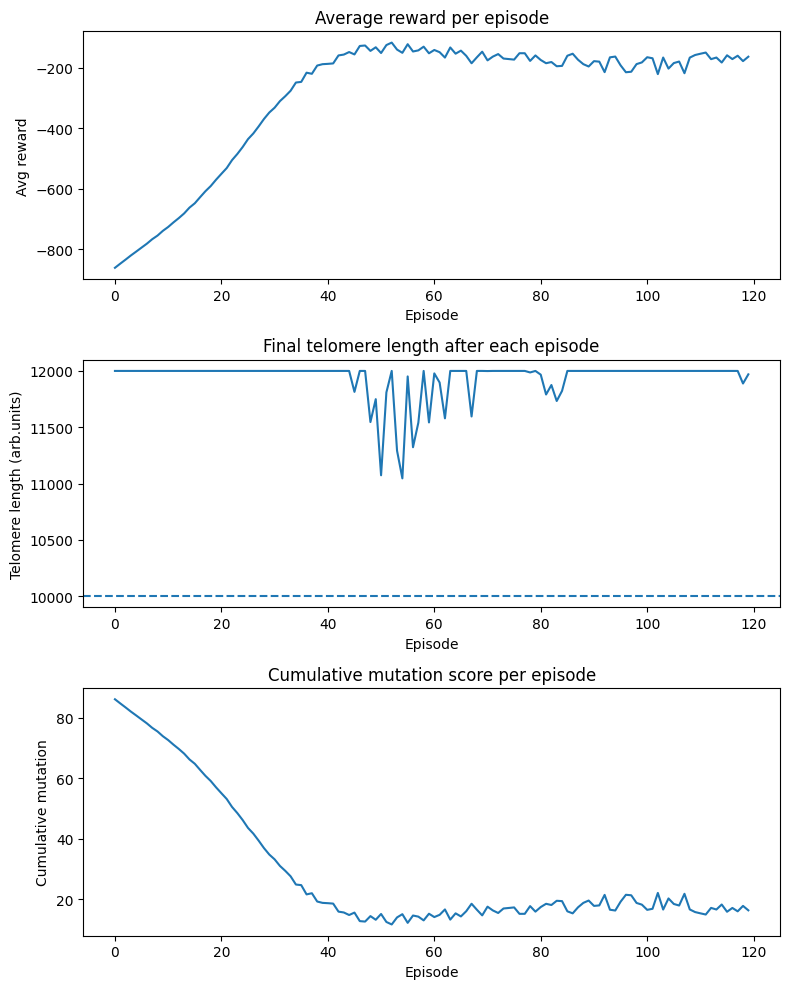


Summary after training:
Best episode (closest to target): #54 final length=11045.84, cumulative_mut=15.0824
Last episode: final length=11969.74, cumulative_mut=16.3567


In [ ]:
# Runnable in-situ simulation of a "virtual cell" telomere controller.
# - Tries to use PyTorch if available; falls back to NumPy-based simple controller if not.
# - Simulates telomere length dynamics, telomerase activation by a small neural controller,
#   a phagocytosis cleanup step, mutation risk scoring, and trains the controller to keep
#   telomere length near a target while minimizing mutation risk and excessive telomerase activity.
# - Produces a plot of telomere length over time for several episodes and prints summary metrics.
# Notes:
# - This is a simple pedagogical simulator, not a biological model.
# - Training budget and network size are intentionally small so it runs in limited environments.
import math
import random
import numpy as np
import matplotlib.pyplot as plt
# Try to use PyTorch if available.
use_torch = False
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    use_torch = True
except Exception as e:
    use_torch = False
    print("PyTorch not available — running fallback NumPy controller.")
# ---------- Simulation parameters ----------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
if use_torch:
    torch.manual_seed(SEED)
TIMESTEPS = 200          # steps per episode (cell lifecycle steps)
EPISODES = 120           # number of training episodes
TARGET_LENGTH = 10000.0  # desired telomere length (arbitrary units)
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0
# Environment dynamics parameters (simple model)
BASE_DAMAGE_RATE = 0.5        # baseline shortening per timestep
STRESS_VARIANCE = 0.6         # added random damage term scale
TELOM_REPAIR_SCALE = 120.0    # how much telomerase action restores per unit action
MUTATION_BASE = 0.001         # base mutation risk per timestep
MUTATION_ACTION_FACTOR = 0.8  # telomerase activity increases mutation risk factor
# Phagocytosis parameters (environment cleanup)
PHAGO_CLEARANCE_EFF = 0.85    # fraction of debris removed each cleanup
# Reward shaping coefficients
ALPHA_length = 1.0      # reward weight for being close to target length
ALPHA_mut = 2000.0      # penalty multiplier for mutation risk (scaled)
ALPHA_action = 0.5      # penalty for using high telomerase activity (energy/cancer risk)
# ---------- Helper functions ----------
def clamp(x, a, b):
    return max(a, min(b, x))
# Small environment class
class TelomereEnv:
    def __init__(self, seed=None):
        self.reset()
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
    def reset(self):
        self.telomere_length = random.uniform(TARGET_LENGTH - 1000, TARGET_LENGTH + 1000)
        self.debris = random.uniform(0.0, 0.5)  # environmental debris load affecting stress
        self.cumulative_mutation = 0.0
        return self._get_obs()
    def _get_obs(self):
        # Observations: normalized telomere length deviation, debris, and a random stress signal
        length_dev = (self.telomere_length - TARGET_LENGTH) / (MAX_LENGTH - MIN_LENGTH)
        stress_signal = random.gauss(0, 1) * 0.05  # small random signal
        return np.array([length_dev, self.debris, stress_signal], dtype=np.float32)
    def step(self, action):
        # action expected in [0,1] (telomerase activation intensity)
        action = clamp(float(action), 0.0, 1.0)
        # Damage
        damage = BASE_DAMAGE_RATE + abs(np.random.normal(0, STRESS_VARIANCE)) * (1.0 + self.debris)
        # Telomerase repair
        repair = action * TELOM_REPAIR_SCALE
        # Update telomere length
        self.telomere_length += repair - damage
        self.telomere_length = clamp(self.telomere_length, MIN_LENGTH, MAX_LENGTH)
        # Mutation risk increases with telomerase action and damage
        mutation_risk = MUTATION_BASE + (action * MUTATION_ACTION_FACTOR) + (damage / 10000.0)
        self.cumulative_mutation += mutation_risk
        # debris accumulates slightly from damage, then phagocytosis will clear it in cleanup phase
        self.debris += damage * 0.0005
        # Reward: keep telomere close to TARGET_LENGTH, penalize mutation risk and high action
        length_penalty = abs(self.telomere_length - TARGET_LENGTH) / (MAX_LENGTH - MIN_LENGTH)
        reward = - ALPHA_length * length_penalty - ALPHA_mut * mutation_risk - ALPHA_action * (action**2)
        # Done flag if mutation cumulative too high (failure) or timesteps exhausted will be handled externally
        info = {'telomere_length': self.telomere_length, 'mutation_risk': mutation_risk, 'debris': self.debris}
        return self._get_obs(), reward, False, info
    def phagocytosis_cleanup(self):
        # simulate a cleanup step; reduce debris load
        self.debris *= (1.0 - PHAGO_CLEARANCE_EFF)
        # small bonus effect: cleanup slightly reduces mutation accumulation rate next steps (implicit)
        return self.debris
# ---------- Controller models ----------
OBS_DIM = 3
if use_torch:
    class ControllerNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(OBS_DIM, 32),
                nn.GELU(),
                nn.Linear(32, 32),
                nn.GELU(),
                nn.Linear(32, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            return self.net(x).squeeze(-1)
    controller = ControllerNet()
    optimizer = optim.AdamW(controller.parameters(), lr=3e-3, weight_decay=1e-5)
else:
    # Simple param vector for linear controller with tanh squashing -> [0,1]
    controller_weights = np.random.randn(OBS_DIM + 1) * 0.1  # last term bias
    # simple gradient descent params
    lr = 1e-3
def select_action(obs):
    if use_torch:
        obs_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            action = controller(obs_t).item()
        return action
    else:
        x = np.concatenate([obs, np.array([1.0])])  # bias
        val = np.tanh(np.dot(controller_weights, x))
        action = (val + 1.0) / 2.0
        return float(action)
# ---------- Training loop (policy gradient-lite / supervised-ish objective) ----------
env = TelomereEnv(seed=SEED)
history = {'episode': [], 'avg_reward': [], 'final_length': [], 'cumulative_mut': []}
# We'll train by running episodes and using the sum of rewards as objective. For torch we use REINFORCE-lite.
for ep in range(EPISODES):
    obs = env.reset()
    ep_rewards = []
    ep_infos = []
    ep_obs = []
    ep_actions = []
    for t in range(TIMESTEPS):
        action = select_action(obs)
        ep_obs.append(obs.copy())
        ep_actions.append(action)
        obs, reward, done, info = env.step(action)
        ep_rewards.append(reward)
        ep_infos.append(info)
        # Periodic phagocytosis: run every 10 timesteps
        if (t + 1) % 10 == 0:
            env.phagocytosis_cleanup()
    total_reward = sum(ep_rewards)
    final_len = env.telomere_length
    cum_mut = env.cumulative_mutation
    history['episode'].append(ep)
    history['avg_reward'].append(total_reward / TIMESTEPS)
    history['final_length'].append(final_len)
    history['cumulative_mut'].append(cum_mut)
    # ---- simple update to controller ----
    if use_torch:
        # prepare tensors
        obs_tensor = torch.tensor(np.array(ep_obs), dtype=torch.float32)
        actions_tensor = torch.tensor(np.array(ep_actions), dtype=torch.float32)
        rewards_tensor = torch.tensor(np.array(ep_rewards), dtype=torch.float32)
        # Compute a simple loss: (predicted_action - desirable_action)^2 weighted by future reward
        # Define desirable_action as a normalized correction toward target length
        desired = []
        cur_lengths = []
        # reconstruct lengths by simulating deterministic dynamics for desirability (approx)
        l = ep_infos[0]['telomere_length'] if ep_infos else env.telomere_length
        for i in range(len(ep_obs)):
            desired_action = clamp((TARGET_LENGTH - l) / TELOM_REPAIR_SCALE, -1.0, 1.0)
            # map to [0,1]
            desired_action = (desired_action + 1.0) / 2.0
            desired.append(desired_action)
            # estimate next length using last taken action
            a = ep_actions[i]
            est_damage = BASE_DAMAGE_RATE  # ignore noise for target estimation
            l = clamp(l + a * TELOM_REPAIR_SCALE - est_damage, MIN_LENGTH, MAX_LENGTH)
            cur_lengths.append(l)
        desired_tensor = torch.tensor(np.array(desired), dtype=torch.float32)
        # predicted
        pred = controller(obs_tensor)
        # weighting: use discounted future reward approximation (cumulative reward from t)
        discounts = torch.tensor([sum(ep_rewards[i:]) for i in range(len(ep_rewards))], dtype=torch.float32)
        discounts = (discounts - discounts.mean()) / (discounts.std() + 1e-8)
        loss = torch.mean(((pred - desired_tensor)**2) * (1.0 - 0.3 * discounts))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    else:
        # NumPy fallback: perform a tiny gradient-free update nudging weights toward achieving desirables
        # compute desired vector similarly
        l = ep_infos[0]['telomere_length'] if ep_infos else env.telomere_length
        desired = []
        for i in range(len(ep_obs)):
            desired_action = clamp((TARGET_LENGTH - l) / TELOM_REPAIR_SCALE, -1.0, 1.0)
            desired_action = (desired_action + 1.0) / 2.0
            desired.append(desired_action)
            a = ep_actions[i]
            l = clamp(l + a * TELOM_REPAIR_SCALE - BASE_DAMAGE_RATE, MIN_LENGTH, MAX_LENGTH)
        desired = np.array(desired)
        obs_arr = np.array(ep_obs)
        # simple linear regression step for mapping obs->desired in least-squares sense
        X = np.concatenate([obs_arr, np.ones((obs_arr.shape[0],1))], axis=1)
        # solve for w via normal equations with small damping
        damping = 1e-3
        w_new = np.linalg.inv(X.T.dot(X) + damping*np.eye(X.shape[1])).dot(X.T).dot(desired)
        # gradient step toward that w_new
        controller_weights += lr * (w_new - controller_weights)
    # occasional reporting
    if (ep+1) % 20 == 0 or ep==0:
        print(f"Episode {ep+1}/{EPISODES}  avg_reward={history['avg_reward'][-1]:.4f}  final_len={final_len:.1f}  cum_mut={cum_mut:.4f}")
# ---------- Visualize results ----------
episodes = history['episode']
avg_rewards = history['avg_reward']
final_lengths = history['final_length']
cum_muts = history['cumulative_mut']
fig, axs = plt.subplots(3,1, figsize=(8,10), tight_layout=True)
axs[0].plot(episodes, avg_rewards)
axs[0].set_title("Average reward per episode")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Avg reward")
axs[1].plot(episodes, final_lengths)
axs[1].axhline(TARGET_LENGTH, linestyle='--')
axs[1].set_title("Final telomere length after each episode")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Telomere length (arb.units)")
axs[2].plot(episodes, cum_muts)
axs[2].set_title("Cumulative mutation score per episode")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Cumulative mutation")
plt.show()
# Print summary
best_idx = int(np.argmin(np.abs(np.array(final_lengths) - TARGET_LENGTH)))
print("\nSummary after training:")
print(f"Best episode (closest to target): #{best_idx} final length={final_lengths[best_idx]:.2f}, cumulative_mut={cum_muts[best_idx]:.4f}")
print(f"Last episode: final length={final_lengths[-1]:.2f}, cumulative_mut={cum_muts[-1]:.4f}")

Episode 1/40 avg_reward=-861.3774 final_len=12000.0 cum_mut=43.0437
Episode 10/40 avg_reward=-740.7943 final_len=12000.0 cum_mut=37.0191
Episode 20/40 avg_reward=-576.5330 final_len=12000.0 cum_mut=28.8098
Episode 30/40 avg_reward=-382.4590 final_len=11955.2 cum_mut=19.1131
Episode 40/40 avg_reward=-245.3139 final_len=11075.7 cum_mut=12.2604


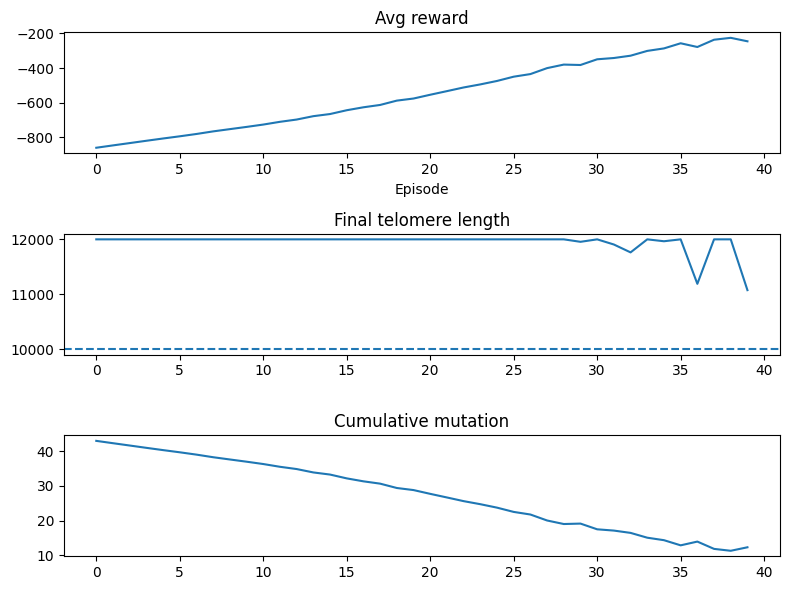

In [ ]:
# Fast, runnable version of the virtual-cell telomere controller simulation
# Use PyTorch if available; falls back to NumPy.
import math, random, numpy as np, matplotlib.pyplot as plt
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Try PyTorch
use_torch = False
try:
    import torch, torch.nn as nn, torch.optim as optim
    use_torch = True
    torch.manual_seed(SEED)
except:
    use_torch = False

# Smaller training budget for quick runs
TIMESTEPS = 100
EPISODES = 40
TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85

ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5

def clamp(x,a,b): return max(a,min(b,x))

class TelomereEnv:
    def __init__(self, seed=None):
        self.reset()
    def reset(self):
        self.telomere_length = random.uniform(TARGET_LENGTH-800, TARGET_LENGTH+800)
        self.debris = random.uniform(0.0,0.5)
        self.cumulative_mutation = 0.0
        return self._get_obs()
    def _get_obs(self):
        length_dev = (self.telomere_length - TARGET_LENGTH)/(MAX_LENGTH - MIN_LENGTH)
        stress_signal = random.gauss(0,1)*0.05
        return np.array([length_dev, self.debris, stress_signal], dtype=np.float32)
    def step(self, action):
        action = clamp(float(action),0.0,1.0)
        damage = BASE_DAMAGE_RATE + abs(np.random.normal(0, STRESS_VARIANCE))*(1.0 + self.debris)
        repair = action * TELOM_REPAIR_SCALE
        self.telomere_length += repair - damage
        self.telomere_length = clamp(self.telomere_length, MIN_LENGTH, MAX_LENGTH)
        mutation_risk = MUTATION_BASE + (action * MUTATION_ACTION_FACTOR) + (damage / 10000.0)
        self.cumulative_mutation += mutation_risk
        self.debris += damage * 0.0005
        length_penalty = abs(self.telomere_length - TARGET_LENGTH) / (MAX_LENGTH - MIN_LENGTH)
        reward = - ALPHA_length * length_penalty - ALPHA_mut * mutation_risk - ALPHA_action * (action**2)
        info = {'telomere_length': self.telomere_length, 'mutation_risk': mutation_risk, 'debris': self.debris}
        return self._get_obs(), reward, False, info
    def phagocytosis_cleanup(self):
        self.debris *= (1.0 - PHAGO_CLEARANCE_EFF)
        return self.debris

OBS_DIM = 3
if use_torch:
    class ControllerNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(nn.Linear(OBS_DIM,32), nn.GELU(),
                                     nn.Linear(32,32), nn.GELU(),
                                     nn.Linear(32,1), nn.Sigmoid())
        def forward(self,x): return self.net(x).squeeze(-1)
    controller = ControllerNet()
    optimizer = optim.AdamW(controller.parameters(), lr=3e-3, weight_decay=1e-5)
else:
    controller_weights = np.random.randn(OBS_DIM+1)*0.1
    lr = 1e-3

def select_action(obs):
    if use_torch:
        obs_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad(): return controller(obs_t).item()
    else:
        x = np.concatenate([obs, np.array([1.0])])
        val = np.tanh(np.dot(controller_weights, x))
        return float((val+1.0)/2.0)

env = TelomereEnv()
history = {'episode': [], 'avg_reward': [], 'final_length': [], 'cumulative_mut': []}

for ep in range(EPISODES):
    obs = env.reset()
    ep_rewards, ep_obs, ep_actions, ep_infos = [], [], [], []
    for t in range(TIMESTEPS):
        action = select_action(obs)
        ep_obs.append(obs.copy()); ep_actions.append(action)
        obs, reward, _, info = env.step(action)
        ep_rewards.append(reward); ep_infos.append(info)
        if (t+1) % 10 == 0: env.phagocytosis_cleanup()
    total_reward = sum(ep_rewards)
    history['episode'].append(ep)
    history['avg_reward'].append(total_reward / TIMESTEPS)
    history['final_length'].append(env.telomere_length)
    history['cumulative_mut'].append(env.cumulative_mutation)

    # small update
    if use_torch:
        obs_tensor = torch.tensor(np.array(ep_obs), dtype=torch.float32)
        ep_actions_tensor = torch.tensor(np.array(ep_actions), dtype=torch.float32)
        desired = []
        l = ep_infos[0]['telomere_length'] if ep_infos else env.telomere_length
        for i in range(len(ep_obs)):
            desired_action = clamp((TARGET_LENGTH - l) / TELOM_REPAIR_SCALE, -1.0, 1.0)
            desired_action = (desired_action + 1.0) / 2.0
            desired.append(desired_action)
            a = ep_actions[i]; l = clamp(l + a * TELOM_REPAIR_SCALE - BASE_DAMAGE_RATE, MIN_LENGTH, MAX_LENGTH)
        desired_tensor = torch.tensor(np.array(desired), dtype=torch.float32)
        pred = controller(obs_tensor)
        loss = torch.mean((pred - desired_tensor)**2)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    else:
        l = ep_infos[0]['telomere_length'] if ep_infos else env.telomere_length
        desired = []
        for i in range(len(ep_obs)):
            da = clamp((TARGET_LENGTH - l)/TELOM_REPAIR_SCALE, -1.0, 1.0)
            desired.append((da+1.0)/2.0)
            a = ep_actions[i]; l = clamp(l + a * TELOM_REPAIR_SCALE - BASE_DAMAGE_RATE, MIN_LENGTH, MAX_LENGTH)
        desired = np.array(desired); obs_arr = np.array(ep_obs)
        X = np.concatenate([obs_arr, np.ones((obs_arr.shape[0],1))], axis=1)
        damping = 1e-3
        w_new = np.linalg.inv(X.T.dot(X) + damping*np.eye(X.shape[1])).dot(X.T).dot(desired)
        controller_weights += lr * (w_new - controller_weights)

    if (ep+1) % 10 == 0 or ep==0:
        print(f"Episode {ep+1}/{EPISODES} avg_reward={history['avg_reward'][-1]:.4f} final_len={history['final_length'][-1]:.1f} cum_mut={history['cumulative_mut'][-1]:.4f}")

# Plotting
eps = history['episode']
plt.figure(figsize=(8,6))
plt.subplot(3,1,1); plt.plot(eps, history['avg_reward']); plt.title("Avg reward"); plt.xlabel("Episode")
plt.subplot(3,1,2); plt.plot(eps, history['final_length']); plt.axhline(TARGET_LENGTH, linestyle='--'); plt.title("Final telomere length")
plt.subplot(3,1,3); plt.plot(eps, history['cumulative_mut']); plt.title("Cumulative mutation")
plt.tight_layout(); plt.show()

In [ ]:
# Compute T-loop stability score (0-1)
def tloop_stability(telomere_length, sequence_efficiency, loop_factor=1.0):
    """
    - telomere_length: current telomere length
    - sequence_efficiency: synthetic telomere recognition efficiency (0-1)
    - loop_factor: controls folding tightness (0-1)
    """
    optimal_length = TARGET_LENGTH
    deviation = abs(telomere_length - optimal_length)
    fold_stability = np.exp(-deviation / 3000.0)  # decay with deviation
    accessibility = sequence_efficiency * loop_factor
    return clamp(fold_stability * accessibility, 0.0, 1.0)

In [ ]:
def telomerase_action(base_action, tloop_score):
    """
    base_action: AI controller output [0-1]
    tloop_score: T-loop accessibility/stability score [0-1]
    returns effective telomere repair
    """
    return base_action * tloop_score * TELOM_REPAIR_SCALE

In [ ]:
def mutation_risk(base, action, damage, tloop_score):
    """
    Returns per-step mutation risk score (0-1)
    """
    risk = base + (action * MUTATION_ACTION_FACTOR) + (damage/10000.0)
    # T-loop instability increases mutation probability
    risk *= (1.0 + (1.0 - tloop_score))
    return risk

In [ ]:
def env_step(obs, action, sequence_efficiency=0.9):
    # current telomere length & debris from obs
    tel_len, debris = obs[0]* (MAX_LENGTH-MIN_LENGTH) + TARGET_LENGTH, obs[1]

    # damage simulation
    damage = BASE_DAMAGE_RATE + abs(np.random.normal(0, STRESS_VARIANCE))*(1.0+debris)

    # T-loop stability
    tloop_score = tloop_stability(tel_len, sequence_efficiency)

    # telomerase repair
    repair = telomerase_action(action, tloop_score)

    # update telomere
    tel_len += repair - damage
    tel_len = clamp(tel_len, MIN_LENGTH, MAX_LENGTH)

    # mutation
    mut_risk = mutation_risk(MUTATION_BASE, action, damage, tloop_score)

    # debris accumulation and phagocytosis
    debris += damage*0.0005
    if random.random() < 0.1:  # every 10 steps
        debris *= (1.0-PHAGO_CLEARANCE_EFF)

    # reward shaping
    length_penalty = abs(tel_len - TARGET_LENGTH) / (MAX_LENGTH - MIN_LENGTH)
    reward = - ALPHA_length*length_penalty - ALPHA_mut*mut_risk - ALPHA_action*(action**2)

    # update obs
    new_obs = np.array([(tel_len - TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH), debris, random.gauss(0,0.05)])

    info = {'telomere_length': tel_len, 'mutation_risk': mut_risk, 'tloop_score': tloop_score, 'debris': debris}
    return new_obs, reward, False, info

Episode 1/40 last tel_len=12000.0, last mut_risk=0.6615
Episode 10/40 last tel_len=12000.0, last mut_risk=0.5659
Episode 20/40 last tel_len=12000.0, last mut_risk=0.4356
Episode 30/40 last tel_len=11613.1, last mut_risk=0.2564
Episode 40/40 last tel_len=11226.9, last mut_risk=0.1286


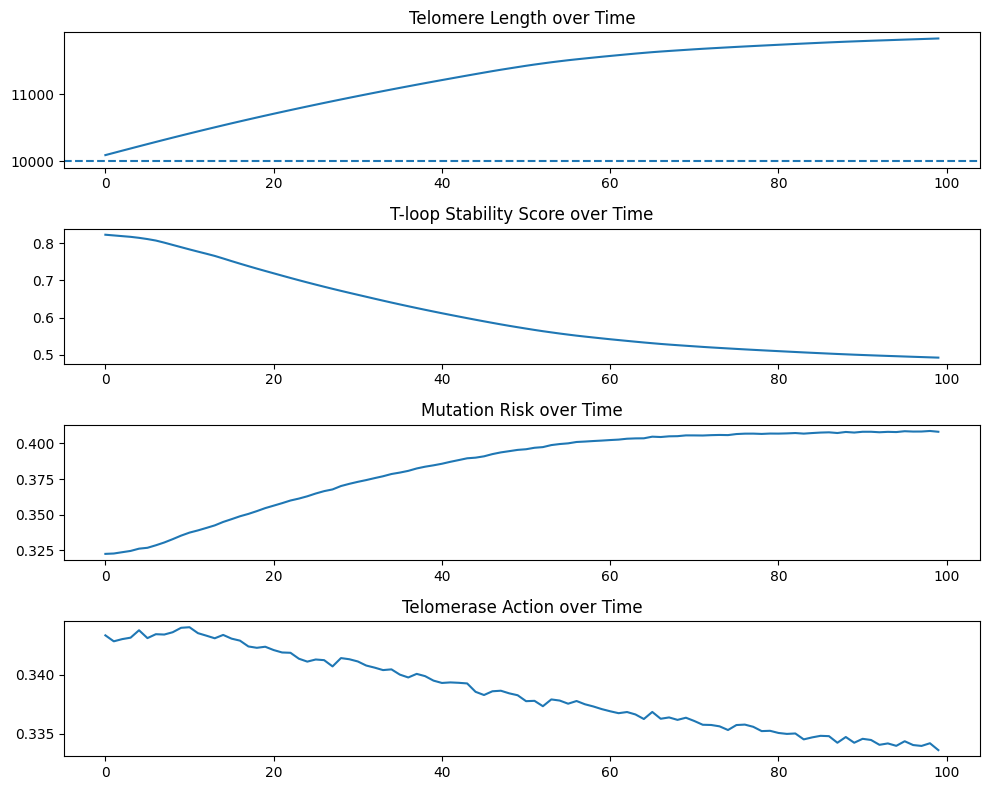

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Try PyTorch first
use_torch = False
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    use_torch = True
    torch.manual_seed(42)
except:
    use_torch = False

# ---------------------- Parameters ----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

TIMESTEPS = 100
EPISODES = 40
TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85

ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5

OBS_DIM = 3  # telomere deviation, debris, stress

def clamp(x,a,b): return max(a,min(b,x))

# ---------------------- Environment ----------------------
def tloop_stability(telomere_length, sequence_efficiency=0.9, loop_factor=1.0):
    """Proxy for T-loop folding and accessibility"""
    deviation = abs(telomere_length - TARGET_LENGTH)
    fold_stability = np.exp(-deviation / 3000.0)
    accessibility = sequence_efficiency * loop_factor
    return clamp(fold_stability * accessibility, 0.0, 1.0)

def telomerase_action(base_action, tloop_score):
    return base_action * tloop_score * TELOM_REPAIR_SCALE

def mutation_risk(base, action, damage, tloop_score):
    risk = base + (action * MUTATION_ACTION_FACTOR) + (damage / 10000.0)
    risk *= (1.0 + (1.0 - tloop_score))
    return risk

def env_step(obs, action, sequence_efficiency=0.9):
    tel_len = obs[0]*(MAX_LENGTH-MIN_LENGTH) + TARGET_LENGTH
    debris = obs[1]

    # damage
    damage = BASE_DAMAGE_RATE + abs(np.random.normal(0, STRESS_VARIANCE))*(1.0+debris)

    # T-loop
    tloop_score = tloop_stability(tel_len, sequence_efficiency)

    # telomerase repair
    repair = telomerase_action(action, tloop_score)

    # update telomere
    tel_len += repair - damage
    tel_len = clamp(tel_len, MIN_LENGTH, MAX_LENGTH)

    # mutation
    mut_risk = mutation_risk(MUTATION_BASE, action, damage, tloop_score)

    # debris and phagocytosis
    debris += damage*0.0005
    if random.random() < 0.1:
        debris *= (1.0-PHAGO_CLEARANCE_EFF)

    # reward
    length_penalty = abs(tel_len - TARGET_LENGTH)/(MAX_LENGTH - MIN_LENGTH)
    reward = - ALPHA_length*length_penalty - ALPHA_mut*mut_risk - ALPHA_action*(action**2)

    new_obs = np.array([(tel_len - TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH), debris, np.random.normal(0,0.05)])
    info = {'telomere_length': tel_len, 'mutation_risk': mut_risk, 'tloop_score': tloop_score, 'debris': debris}
    return new_obs, reward, False, info

# ---------------------- Controller ----------------------
if use_torch:
    class ControllerNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(OBS_DIM,32),
                nn.GELU(),
                nn.Linear(32,32),
                nn.GELU(),
                nn.Linear(32,1),
                nn.Sigmoid()
            )
        def forward(self,x): return self.net(x).squeeze(-1)
    controller = ControllerNet()
    optimizer = optim.AdamW(controller.parameters(), lr=3e-3, weight_decay=1e-5)
else:
    controller_weights = np.random.randn(OBS_DIM+1)*0.1
    lr = 1e-3

def select_action(obs):
    if use_torch:
        obs_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad(): return controller(obs_t).item()
    else:
        x = np.concatenate([obs, np.array([1.0])])
        val = np.tanh(np.dot(controller_weights, x))
        return float((val+1.0)/2.0)

# ---------------------- Training Loop ----------------------
history = {'tel_len':[], 'mut_risk':[], 'tloop_score':[], 'action':[]}

for ep in range(EPISODES):
    # initialize
    obs = np.array([random.uniform(-0.1,0.1), random.uniform(0,0.5), np.random.normal(0,0.05)])
    ep_obs, ep_actions, ep_infos = [], [], []

    for t in range(TIMESTEPS):
        action = select_action(obs)
        ep_obs.append(obs.copy())
        ep_actions.append(action)
        obs, reward, done, info = env_step(obs, action)
        ep_infos.append(info)

    # store for visualization
    history['tel_len'].append([info['telomere_length'] for info in ep_infos])
    history['mut_risk'].append([info['mutation_risk'] for info in ep_infos])
    history['tloop_score'].append([info['tloop_score'] for info in ep_infos])
    history['action'].append(ep_actions)

    # update controller
    if use_torch:
        obs_tensor = torch.tensor(np.array(ep_obs), dtype=torch.float32)
        actions_tensor = torch.tensor(np.array(ep_actions), dtype=torch.float32)
        # desired action: simple heuristic toward target length
        desired = []
        l = ep_infos[0]['telomere_length']
        for i,a in enumerate(ep_actions):
            da = clamp((TARGET_LENGTH - l)/TELOM_REPAIR_SCALE, -1.0, 1.0)
            desired.append((da+1.0)/2.0)
            l = clamp(l + a * TELOM_REPAIR_SCALE - BASE_DAMAGE_RATE, MIN_LENGTH, MAX_LENGTH)
        desired_tensor = torch.tensor(np.array(desired), dtype=torch.float32)
        pred = controller(obs_tensor)
        loss = torch.mean((pred - desired_tensor)**2)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    else:
        l = ep_infos[0]['telomere_length']
        desired = []
        for i,a in enumerate(ep_actions):
            da = clamp((TARGET_LENGTH - l)/TELOM_REPAIR_SCALE, -1.0, 1.0)
            desired.append((da+1.0)/2.0)
            l = clamp(l + a*TELOM_REPAIR_SCALE - BASE_DAMAGE_RATE, MIN_LENGTH, MAX_LENGTH)
        desired = np.array(desired)
        obs_arr = np.array(ep_obs)
        X = np.concatenate([obs_arr, np.ones((obs_arr.shape[0],1))], axis=1)
        damping = 1e-3
        w_new = np.linalg.inv(X.T.dot(X)+damping*np.eye(X.shape[1])).dot(X.T).dot(desired)
        controller_weights += lr*(w_new - controller_weights)

    if (ep+1)%10==0 or ep==0:
        print(f"Episode {ep+1}/{EPISODES} last tel_len={history['tel_len'][-1][-1]:.1f}, last mut_risk={history['mut_risk'][-1][-1]:.4f}")

# ---------------------- Visualization ----------------------
plt.figure(figsize=(10,8))
plt.subplot(4,1,1)
plt.plot(np.mean(history['tel_len'],axis=0))
plt.title("Telomere Length over Time"); plt.axhline(TARGET_LENGTH, linestyle='--')

plt.subplot(4,1,2)
plt.plot(np.mean(history['tloop_score'],axis=0))
plt.title("T-loop Stability Score over Time")

plt.subplot(4,1,3)
plt.plot(np.mean(history['mut_risk'],axis=0))
plt.title("Mutation Risk over Time")

plt.subplot(4,1,4)
plt.plot(np.mean(history['action'],axis=0))
plt.title("Telomerase Action over Time")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Attempt PyTorch
use_torch = False
try:
    import torch, torch.nn as nn, torch.optim as optim
    use_torch = True
    torch.manual_seed(42)
except:
    use_torch = False

# ---------------------- Parameters ----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

NUM_CELLS = 5
TIMESTEPS = 80
EPISODES = 30
TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85

ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5

OBS_DIM = 4  # telomere deviation, debris, stress, env_avg_debris

def clamp(x,a,b): return max(a,min(b,x))

In [ ]:
def tloop_stability(telomere_length, sequence_efficiency=0.9, loop_factor=1.0):
    deviation = abs(telomere_length - TARGET_LENGTH)
    fold_stability = np.exp(-deviation / 3000.0)
    accessibility = sequence_efficiency * loop_factor
    return clamp(fold_stability * accessibility, 0.0, 1.0)

def telomerase_action(base_action, tloop_score):
    return base_action * tloop_score * TELOM_REPAIR_SCALE

def mutation_risk(base, action, damage, tloop_score):
    risk = base + (action * MUTATION_ACTION_FACTOR) + (damage / 10000.0)
    risk *= (1.0 + (1.0 - tloop_score))
    return risk

In [ ]:
def tloop_stability(telomere_length, sequence_efficiency=0.9, loop_factor=1.0):
    deviation = abs(telomere_length - TARGET_LENGTH)
    fold_stability = np.exp(-deviation / 3000.0)
    accessibility = sequence_efficiency * loop_factor
    return clamp(fold_stability * accessibility, 0.0, 1.0)

def telomerase_action(base_action, tloop_score):
    return base_action * tloop_score * TELOM_REPAIR_SCALE

def mutation_risk(base, action, damage, tloop_score):
    risk = base + (action * MUTATION_ACTION_FACTOR) + (damage / 10000.0)
    risk *= (1.0 + (1.0 - tloop_score))
    return risk

In [ ]:
def multi_cell_step(cell_states, cell_actions, sequence_efficiency=0.9):
    """
    cell_states: list of dicts with keys: tel_len, debris, cumulative_mut
    cell_actions: list of floats [0-1] per cell
    """
    # compute average debris in environment
    avg_debris = np.mean([cell['debris'] for cell in cell_states])
    new_states = []
    infos = []

    for idx, (cell, action) in enumerate(zip(cell_states, cell_actions)):
        tel_len = cell['tel_len']
        debris = cell['debris']
        # damage
        damage = BASE_DAMAGE_RATE + abs(np.random.normal(0, STRESS_VARIANCE))*(1.0 + avg_debris)
        # T-loop
        tloop_score = tloop_stability(tel_len, sequence_efficiency)
        # telomerase repair
        repair = telomerase_action(action, tloop_score)
        # update telomere
        tel_len += repair - damage
        tel_len = clamp(tel_len, MIN_LENGTH, MAX_LENGTH)
        # mutation
        mut_risk = mutation_risk(MUTATION_BASE, action, damage, tloop_score)
        cell['cumulative_mut'] += mut_risk
        # debris accumulation
        debris += damage * 0.0005
        if random.random() < 0.1:
            debris *= (1.0 - PHAGO_CLEARANCE_EFF)  # phagocytosis
        # update state
        new_states.append({'tel_len': tel_len, 'debris': debris, 'cumulative_mut': cell['cumulative_mut']})
        # observation for next step
        obs = np.array([(tel_len-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH), debris, np.random.normal(0,0.05), avg_debris])
        infos.append({'obs':obs, 'tel_len':tel_len, 'tloop_score':tloop_score, 'mut_risk':mut_risk})
    return new_states, infos

In [ ]:
if use_torch:
    class ControllerNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(OBS_DIM,32),
                nn.GELU(),
                nn.Linear(32,32),
                nn.GELU(),
                nn.Linear(32,1),
                nn.Sigmoid()
            )
        def forward(self,x): return self.net(x).squeeze(-1)
    controller = ControllerNet()
    optimizer = optim.AdamW(controller.parameters(), lr=3e-3, weight_decay=1e-5)
else:
    controller_weights = np.random.randn(OBS_DIM+1)*0.1
    lr = 1e-3

def select_action(obs):
    if use_torch:
        obs_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad(): return controller(obs_t).item()
    else:
        x = np.concatenate([obs, np.array([1.0])])
        val = np.tanh(np.dot(controller_weights, x))
        return float((val+1.0)/2.0)

In [ ]:
history = {'tel_len':[], 'mut_risk':[], 'tloop_score':[], 'action':[]}

for ep in range(EPISODES):
    # initialize cells
    cell_states = [{'tel_len': random.uniform(TARGET_LENGTH-800,TARGET_LENGTH+800),
                    'debris': random.uniform(0,0.5), 'cumulative_mut':0.0} for _ in range(NUM_CELLS)]
    ep_obs, ep_actions, ep_infos = [], [], []

    for t in range(TIMESTEPS):
        actions = []
        obs_list = []
        for cell in cell_states:
            obs = np.array([(cell['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
                            cell['debris'], np.random.normal(0,0.05),
                            np.mean([c['debris'] for c in cell_states])])
            obs_list.append(obs)
            actions.append(select_action(obs))
        cell_states, infos = multi_cell_step(cell_states, actions)
        ep_obs.append(obs_list)
        ep_actions.append(actions)
        ep_infos.append(infos)

    # store for visualization
    history['tel_len'].append([[info['tel_len'] for info in infos] for infos in ep_infos])
    history['mut_risk'].append([[info['mut_risk'] for info in infos] for infos in ep_infos])
    history['tloop_score'].append([[info['tloop_score'] for info in infos] for infos in ep_infos])
    history['action'].append(ep_actions)

    if (ep+1)%5==0 or ep==0:
        last_tel_len = np.mean([c['tel_len'] for c in cell_states])
        last_mut = np.mean([c['cumulative_mut'] for c in cell_states])
        print(f"Episode {ep+1}/{EPISODES} avg_tel_len={last_tel_len:.1f}, avg_cum_mut={last_mut:.4f}")

Episode 1/30 avg_tel_len=12000.0, avg_cum_mut=43.4186
Episode 5/30 avg_tel_len=12000.0, avg_cum_mut=41.6407
Episode 10/30 avg_tel_len=12000.0, avg_cum_mut=42.3119
Episode 15/30 avg_tel_len=12000.0, avg_cum_mut=42.6936
Episode 20/30 avg_tel_len=12000.0, avg_cum_mut=42.9199
Episode 25/30 avg_tel_len=12000.0, avg_cum_mut=42.3363
Episode 30/30 avg_tel_len=12000.0, avg_cum_mut=43.3166


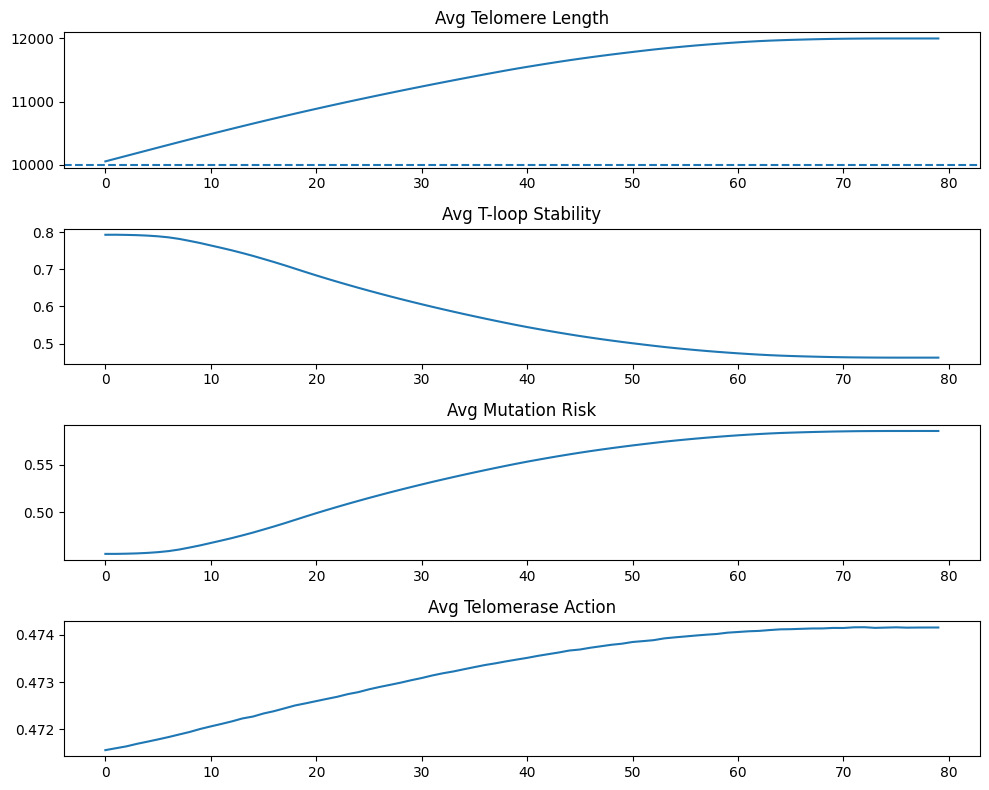

In [ ]:
# Compute average across cells
avg_tel = np.mean(np.array(history['tel_len']), axis=2)
avg_mut = np.mean(np.array(history['mut_risk']), axis=2)
avg_tloop = np.mean(np.array(history['tloop_score']), axis=2)
avg_action = np.mean(np.array(history['action']), axis=2)

plt.figure(figsize=(10,8))
plt.subplot(4,1,1); plt.plot(np.mean(avg_tel, axis=0)); plt.title("Avg Telomere Length"); plt.axhline(TARGET_LENGTH, linestyle='--')
plt.subplot(4,1,2); plt.plot(np.mean(avg_tloop, axis=0)); plt.title("Avg T-loop Stability")
plt.subplot(4,1,3); plt.plot(np.mean(avg_mut, axis=0)); plt.title("Avg Mutation Risk")
plt.subplot(4,1,4); plt.plot(np.mean(avg_action, axis=0)); plt.title("Avg Telomerase Action")
plt.tight_layout(); plt.show()

In [ ]:
def tloop_score(tloop_vec, tel_len, target_len=TARGET_LENGTH):
    """
    Compute docking probability using folding vector and deviation from target telomere length.
    """
    fold_factor = torch.exp(-torch.abs(tel_len - target_len)/3000.0)
    docking_eff = torch.clamp(torch.sigmoid(tloop_vec.sum(dim=1)) * fold_factor, 0.0, 1.0)
    return docking_eff

In [ ]:
def telomerase_action(base_action, tloop_score, repair_scale=TELOM_REPAIR_SCALE):
    return base_action * tloop_score * repair_scale

def mutation_risk(base, action, damage, tloop_score):
    risk = base + (action * MUTATION_ACTION_FACTOR) + (damage / 10000.0)
    risk = risk * (1.0 + (1.0 - tloop_score))
    return risk

Using device: cpu
Episode 1/30: Avg Telomere=11924.2, Avg Cumulative Mutation=69.6646
Episode 2/30: Avg Telomere=11903.6, Avg Cumulative Mutation=69.7272
Episode 3/30: Avg Telomere=11928.4, Avg Cumulative Mutation=69.7696
Episode 4/30: Avg Telomere=11894.7, Avg Cumulative Mutation=69.7862
Episode 5/30: Avg Telomere=11892.3, Avg Cumulative Mutation=69.9193
Episode 6/30: Avg Telomere=11904.6, Avg Cumulative Mutation=69.4693
Episode 7/30: Avg Telomere=11934.5, Avg Cumulative Mutation=69.7306
Episode 8/30: Avg Telomere=11906.8, Avg Cumulative Mutation=69.8985
Episode 9/30: Avg Telomere=11941.6, Avg Cumulative Mutation=69.8080
Episode 10/30: Avg Telomere=11888.2, Avg Cumulative Mutation=69.6038
Episode 11/30: Avg Telomere=11938.1, Avg Cumulative Mutation=69.8164
Episode 12/30: Avg Telomere=11909.8, Avg Cumulative Mutation=69.7065
Episode 13/30: Avg Telomere=11906.3, Avg Cumulative Mutation=69.7936
Episode 14/30: Avg Telomere=11919.2, Avg Cumulative Mutation=69.7852
Episode 15/30: Avg Telome

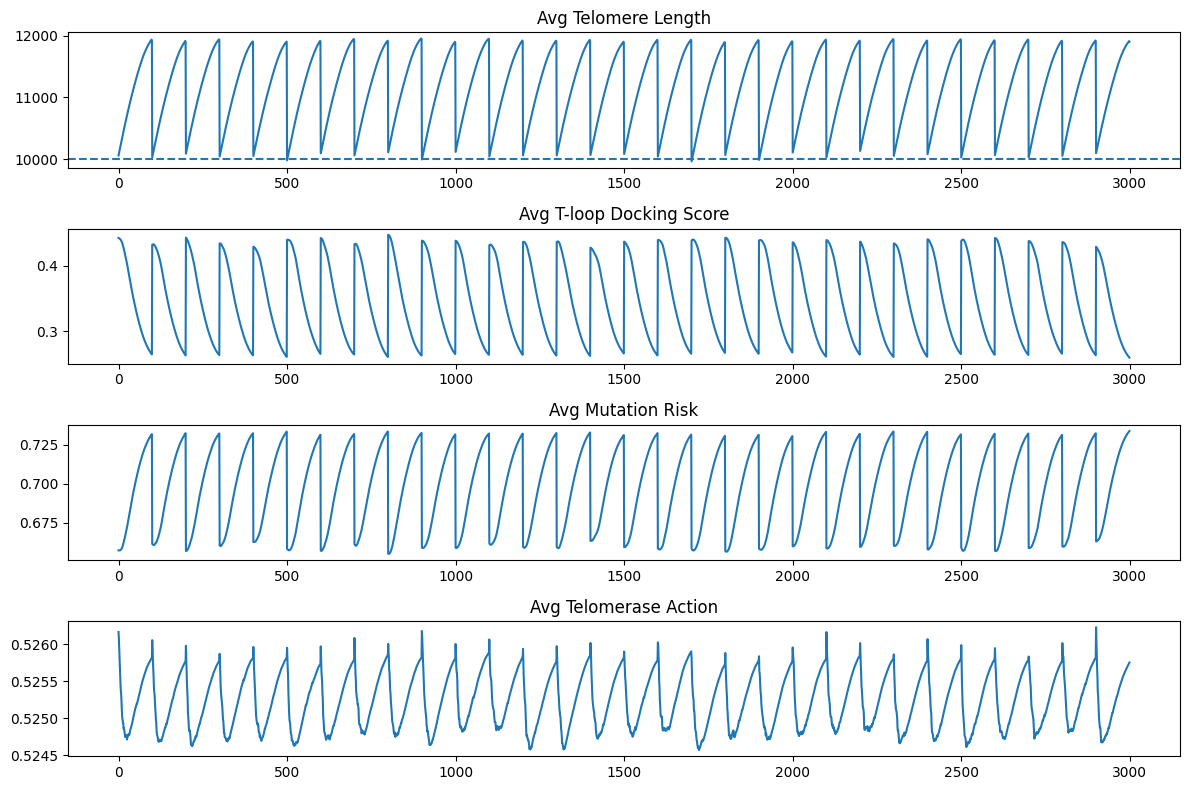

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ---------------------- GPU Setup ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------- Parameters ----------------------
SEED = 42
torch.manual_seed(SEED)

NUM_CELLS = 128         # Number of virtual cells
TIMESTEPS = 100         # Steps per episode
EPISODES = 30           # Number of episodes

TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85

ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5

OBS_DIM = 6  # tel_len deviation, debris, stress, avg_debris, tloop_mean, tloop_std

# ---------------------- Controller ----------------------
class TelomeraseController(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.GELU(),
            nn.Linear(64,64),
            nn.GELU(),
            nn.Linear(64,1),
            nn.Sigmoid()
        )
    def forward(self,x): return self.net(x).squeeze(-1)

controller = TelomeraseController(OBS_DIM).to(device)
optimizer = optim.AdamW(controller.parameters(), lr=3e-3)

# ---------------------- Initialization ----------------------
def init_cells(num_cells):
    return {
        'tel_len': torch.empty(num_cells, device=device).uniform_(TARGET_LENGTH-800, TARGET_LENGTH+800),
        'debris': torch.empty(num_cells, device=device).uniform_(0,0.5),
        'cumulative_mut': torch.zeros(num_cells, device=device),
        'stress': torch.randn(num_cells, device=device)*0.05,
        'tloop_vec': torch.randn(num_cells, 3, device=device)*0.1  # 3D folding proxy
    }

# ---------------------- T-loop and Telomerase ----------------------
def tloop_score(tloop_vec, tel_len, target_len=TARGET_LENGTH):
    fold_factor = torch.exp(-torch.abs(tel_len - target_len)/3000.0)
    docking_eff = torch.clamp(torch.sigmoid(tloop_vec.sum(dim=1)) * fold_factor, 0.0, 1.0)
    return docking_eff

def telomerase_action(base_action, tloop_score):
    return base_action * tloop_score * TELOM_REPAIR_SCALE

def mutation_risk(base, action, damage, tloop_score):
    risk = base + action*MUTATION_ACTION_FACTOR + damage/10000.0
    return risk*(1.0 + (1.0 - tloop_score))

# ---------------------- Multi-Cell Step ----------------------
def multi_cell_step(cells, actions):
    avg_debris = cells['debris'].mean()
    # Damage
    damage = BASE_DAMAGE_RATE + torch.abs(torch.randn_like(cells['stress'])*STRESS_VARIANCE)*(1.0+avg_debris)
    # T-loop
    tloop = tloop_score(cells['tloop_vec'], cells['tel_len'])
    # Telomerase repair
    repair = telomerase_action(actions, tloop)
    # Update telomeres
    cells['tel_len'] += repair - damage
    cells['tel_len'] = torch.clamp(cells['tel_len'], MIN_LENGTH, MAX_LENGTH)
    # Mutation
    mut = mutation_risk(MUTATION_BASE, actions, damage, tloop)
    cells['cumulative_mut'] += mut
    # Debris and phagocytosis
    cells['debris'] += damage*0.0005
    phago_mask = torch.rand_like(cells['debris']) < 0.1
    cells['debris'][phago_mask] *= (1.0-PHAGO_CLEARANCE_EFF)
    # Observations
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        torch.full_like(cells['debris'], avg_debris),
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1)
    ], dim=1)
    infos = {'tel_len': cells['tel_len'].detach().cpu().numpy(),
             'mut_risk': mut.detach().cpu().numpy(),
             'tloop_score': tloop.detach().cpu().numpy(),
             'debris': cells['debris'].detach().cpu().numpy()}
    return obs, infos

# ---------------------- Training Loop ----------------------
history = {'tel_len':[], 'mut_risk':[], 'tloop_score':[], 'action':[]}

for ep in range(EPISODES):
    cells = init_cells(NUM_CELLS)
    for t in range(TIMESTEPS):
        # Build observation
        obs = torch.stack([
            (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
            cells['debris'],
            cells['stress'],
            torch.full_like(cells['debris'], cells['debris'].mean()),
            cells['tloop_vec'].mean(dim=1),
            cells['tloop_vec'].std(dim=1)
        ], dim=1)
        # Actions
        actions = controller(obs).to(device)
        # Step
        obs_next, infos = multi_cell_step(cells, actions)
        # Store for visualization
        history['tel_len'].append(infos['tel_len'])
        history['mut_risk'].append(infos['mut_risk'])
        history['tloop_score'].append(infos['tloop_score'])
        history['action'].append(actions.detach().cpu().numpy())
    # Logging
    avg_tel = cells['tel_len'].mean().item()
    avg_mut = cells['cumulative_mut'].mean().item()
    print(f"Episode {ep+1}/{EPISODES}: Avg Telomere={avg_tel:.1f}, Avg Cumulative Mutation={avg_mut:.4f}")

# ---------------------- Visualization ----------------------
import numpy as np
tel_len_arr = np.array(history['tel_len'])
mut_arr = np.array(history['mut_risk'])
tloop_arr = np.array(history['tloop_score'])
action_arr = np.array(history['action'])

plt.figure(figsize=(12,8))
plt.subplot(4,1,1); plt.plot(tel_len_arr.mean(axis=1)); plt.title("Avg Telomere Length"); plt.axhline(TARGET_LENGTH, linestyle='--')
plt.subplot(4,1,2); plt.plot(tloop_arr.mean(axis=1)); plt.title("Avg T-loop Docking Score")
plt.subplot(4,1,3); plt.plot(mut_arr.mean(axis=1)); plt.title("Avg Mutation Risk")
plt.subplot(4,1,4); plt.plot(action_arr.mean(axis=1)); plt.title("Avg Telomerase Action")
plt.tight_layout(); plt.show()

Using device: cpu
Episode 1/30: Avg Telomere=11924.2, Avg Cumulative Mutation=69.6646
Episode 2/30: Avg Telomere=11903.6, Avg Cumulative Mutation=69.7272
Episode 3/30: Avg Telomere=11928.4, Avg Cumulative Mutation=69.7696
Episode 4/30: Avg Telomere=11894.7, Avg Cumulative Mutation=69.7862
Episode 5/30: Avg Telomere=11892.3, Avg Cumulative Mutation=69.9193
Episode 6/30: Avg Telomere=11904.6, Avg Cumulative Mutation=69.4693
Episode 7/30: Avg Telomere=11934.5, Avg Cumulative Mutation=69.7306
Episode 8/30: Avg Telomere=11906.8, Avg Cumulative Mutation=69.8985
Episode 9/30: Avg Telomere=11941.6, Avg Cumulative Mutation=69.8080
Episode 10/30: Avg Telomere=11888.2, Avg Cumulative Mutation=69.6038
Episode 11/30: Avg Telomere=11938.1, Avg Cumulative Mutation=69.8164
Episode 12/30: Avg Telomere=11909.8, Avg Cumulative Mutation=69.7065
Episode 13/30: Avg Telomere=11906.3, Avg Cumulative Mutation=69.7936
Episode 14/30: Avg Telomere=11919.2, Avg Cumulative Mutation=69.7852
Episode 15/30: Avg Telome

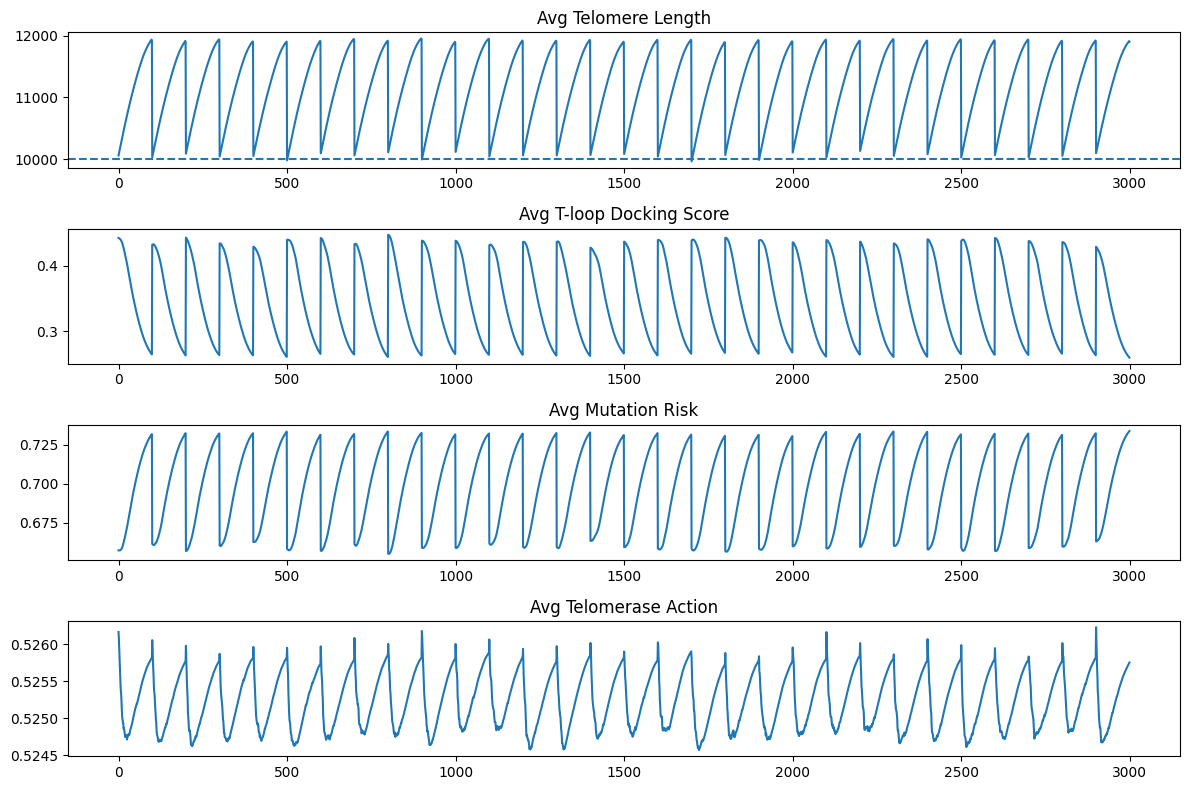

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ---------------------- GPU Setup ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------- Parameters ----------------------
SEED = 42
torch.manual_seed(SEED)

NUM_CELLS = 128         # Number of virtual cells
TIMESTEPS = 100         # Steps per episode
EPISODES = 30           # Number of training episodes

TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85

ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5

OBS_DIM = 6  # tel_len deviation, debris, stress, avg_debris, tloop_mean, tloop_std

# ---------------------- Controller ----------------------
class TelomeraseController(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.GELU(),
            nn.Linear(64,64),
            nn.GELU(),
            nn.Linear(64,1),
            nn.Sigmoid()
        )
    def forward(self,x): return self.net(x).squeeze(-1)

controller = TelomeraseController(OBS_DIM).to(device)
optimizer = optim.AdamW(controller.parameters(), lr=3e-3)

# ---------------------- Initialization ----------------------
def init_cells(num_cells):
    return {
        'tel_len': torch.empty(num_cells, device=device).uniform_(TARGET_LENGTH-800, TARGET_LENGTH+800),
        'debris': torch.empty(num_cells, device=device).uniform_(0,0.5),
        'cumulative_mut': torch.zeros(num_cells, device=device),
        'stress': torch.randn(num_cells, device=device)*0.05,
        'tloop_vec': torch.randn(num_cells, 3, device=device)*0.1  # 3D folding proxy
    }

# ---------------------- T-loop and Telomerase ----------------------
def tloop_score(tloop_vec, tel_len, target_len=TARGET_LENGTH):
    fold_factor = torch.exp(-torch.abs(tel_len - target_len)/3000.0)
    docking_eff = torch.clamp(torch.sigmoid(tloop_vec.sum(dim=1)) * fold_factor, 0.0, 1.0)
    return docking_eff

def telomerase_action(base_action, tloop_score):
    return base_action * tloop_score * TELOM_REPAIR_SCALE

def mutation_risk(base, action, damage, tloop_score):
    risk = base + action*MUTATION_ACTION_FACTOR + damage/10000.0
    return risk*(1.0 + (1.0 - tloop_score))

# ---------------------- Multi-Cell Step ----------------------
def multi_cell_step(cells, actions):
    avg_debris = cells['debris'].mean()
    # Damage
    damage = BASE_DAMAGE_RATE + torch.abs(torch.randn_like(cells['stress'])*STRESS_VARIANCE)*(1.0+avg_debris)
    # T-loop
    tloop = tloop_score(cells['tloop_vec'], cells['tel_len'])
    # Telomerase repair
    repair = telomerase_action(actions, tloop)
    # Update telomeres
    cells['tel_len'] += repair - damage
    cells['tel_len'] = torch.clamp(cells['tel_len'], MIN_LENGTH, MAX_LENGTH)
    # Mutation
    mut = mutation_risk(MUTATION_BASE, actions, damage, tloop)
    cells['cumulative_mut'] += mut
    # Debris and phagocytosis
    cells['debris'] += damage*0.0005
    phago_mask = torch.rand_like(cells['debris']) < 0.1
    cells['debris'][phago_mask] *= (1.0-PHAGO_CLEARANCE_EFF)
    # Observations
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        torch.full_like(cells['debris'], avg_debris),
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1)
    ], dim=1)
    infos = {'tel_len': cells['tel_len'].detach().cpu().numpy(),
             'mut_risk': mut.detach().cpu().numpy(),
             'tloop_score': tloop.detach().cpu().numpy(),
             'debris': cells['debris'].detach().cpu().numpy()}
    return obs, infos

# ---------------------- Training Loop ----------------------
history = {'tel_len':[], 'mut_risk':[], 'tloop_score':[], 'action':[]}

for ep in range(EPISODES):
    cells = init_cells(NUM_CELLS)
    for t in range(TIMESTEPS):
        # Build observation
        obs = torch.stack([
            (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
            cells['debris'],
            cells['stress'],
            torch.full_like(cells['debris'], cells['debris'].mean()),
            cells['tloop_vec'].mean(dim=1),
            cells['tloop_vec'].std(dim=1)
        ], dim=1)
        # Actions
        actions = controller(obs).to(device)
        # Step
        obs_next, infos = multi_cell_step(cells, actions)
        # Store for visualization
        history['tel_len'].append(infos['tel_len'])
        history['mut_risk'].append(infos['mut_risk'])
        history['tloop_score'].append(infos['tloop_score'])
        history['action'].append(actions.detach().cpu().numpy())
    # Logging
    avg_tel = cells['tel_len'].mean().item()
    avg_mut = cells['cumulative_mut'].mean().item()
    print(f"Episode {ep+1}/{EPISODES}: Avg Telomere={avg_tel:.1f}, Avg Cumulative Mutation={avg_mut:.4f}")

# ---------------------- Visualization ----------------------
import numpy as np
tel_len_arr = np.array(history['tel_len'])
mut_arr = np.array(history['mut_risk'])
tloop_arr = np.array(history['tloop_score'])
action_arr = np.array(history['action'])

plt.figure(figsize=(12,8))
plt.subplot(4,1,1); plt.plot(tel_len_arr.mean(axis=1)); plt.title("Avg Telomere Length"); plt.axhline(TARGET_LENGTH, linestyle='--')
plt.subplot(4,1,2); plt.plot(tloop_arr.mean(axis=1)); plt.title("Avg T-loop Docking Score")
plt.subplot(4,1,3); plt.plot(mut_arr.mean(axis=1)); plt.title("Avg Mutation Risk")
plt.subplot(4,1,4); plt.plot(action_arr.mean(axis=1)); plt.title("Avg Telomerase Action")
plt.tight_layout(); plt.show()

Using device: cpu
Episode 1/30: Avg Telomere=11921.7, Avg Cumulative Mutation=70.2286
Episode 2/30: Avg Telomere=11921.0, Avg Cumulative Mutation=69.8293
Episode 3/30: Avg Telomere=11909.9, Avg Cumulative Mutation=69.8911
Episode 4/30: Avg Telomere=11908.4, Avg Cumulative Mutation=69.8778
Episode 5/30: Avg Telomere=11925.3, Avg Cumulative Mutation=69.9596
Episode 6/30: Avg Telomere=11905.0, Avg Cumulative Mutation=69.6586
Episode 7/30: Avg Telomere=11908.9, Avg Cumulative Mutation=69.6530
Episode 8/30: Avg Telomere=11922.2, Avg Cumulative Mutation=69.8676
Episode 9/30: Avg Telomere=11905.3, Avg Cumulative Mutation=69.7743
Episode 10/30: Avg Telomere=11897.3, Avg Cumulative Mutation=69.8265
Episode 11/30: Avg Telomere=11901.9, Avg Cumulative Mutation=69.6898
Episode 12/30: Avg Telomere=11900.3, Avg Cumulative Mutation=69.6625
Episode 13/30: Avg Telomere=11897.8, Avg Cumulative Mutation=69.6414
Episode 14/30: Avg Telomere=11924.3, Avg Cumulative Mutation=69.8718
Episode 15/30: Avg Telome

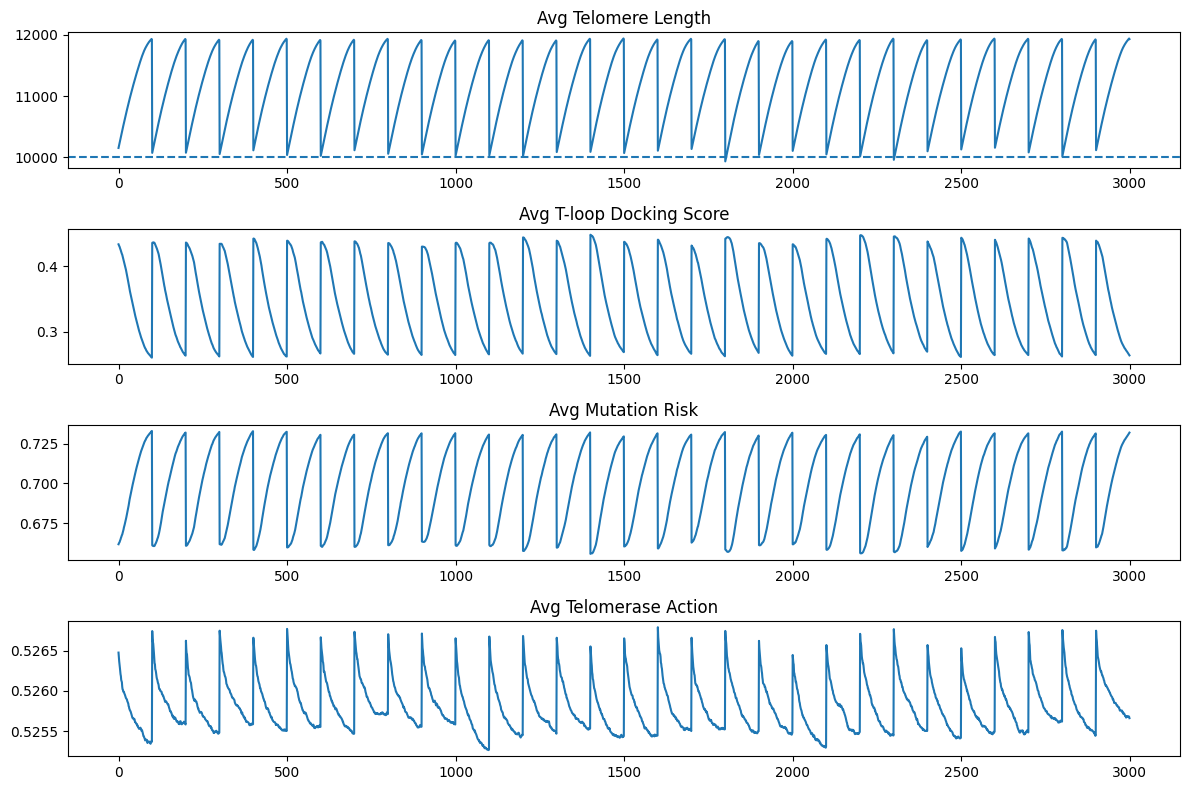

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ---------------------- GPU Setup ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------- Parameters ----------------------
SEED = 42
torch.manual_seed(SEED)

NUM_CELLS = 128
TIMESTEPS = 100
EPISODES = 30

TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85


ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5

TLOOP_DIM = 3  # 3D folding vector
OBS_DIM = 7    # tel_len deviation, debris, stress, neighbor_avg_debris, neighbor_avg_stress, tloop_mean, tloop_std

# ---------------------- Controller ----------------------
class TelomeraseController(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.GELU(),
            nn.Linear(64,64),
            nn.GELU(),
            nn.Linear(64,1),
            nn.Sigmoid()
        )
    def forward(self,x): return self.net(x).squeeze(-1)

controller = TelomeraseController(OBS_DIM).to(device)
optimizer = optim.AdamW(controller.parameters(), lr=3e-3)

# ---------------------- Initialization ----------------------
def init_cells(num_cells):
    return {
        'tel_len': torch.empty(num_cells, device=device).uniform_(TARGET_LENGTH-800, TARGET_LENGTH+800),
        'debris': torch.empty(num_cells, device=device).uniform_(0,0.5),
        'cumulative_mut': torch.zeros(num_cells, device=device),
        'stress': torch.randn(num_cells, device=device)*0.05,
        'tloop_vec': torch.randn(num_cells, TLOOP_DIM, device=device)*0.1
    }

# ---------------------- T-loop and Telomerase ----------------------
def tloop_score(tloop_vec, tel_len, target_len=TARGET_LENGTH):
    fold_factor = torch.exp(-torch.abs(tel_len - target_len)/3000.0)
    docking_eff = torch.clamp(torch.sigmoid(tloop_vec.sum(dim=1)) * fold_factor, 0.0, 1.0)
    return docking_eff

def telomerase_action(base_action, tloop_score):
    return base_action * tloop_score * TELOM_REPAIR_SCALE

def mutation_risk(base, action, damage, tloop_score):
    risk = base + action*MUTATION_ACTION_FACTOR + damage/10000.0
    return risk*(1.0 + (1.0 - tloop_score))

# ---------------------- Multi-Cell Step with Neighbor Signaling ----------------------
def multi_cell_step(cells, actions, neighbor_matrix):
    """
    neighbor_matrix: [num_cells, num_cells] adjacency weights for cell-cell signaling
    """
    # Compute neighbor-averaged stress/debris
    neighbor_debris = neighbor_matrix @ cells['debris']
    neighbor_stress = neighbor_matrix @ cells['stress']

    # Damage
    avg_debris = cells['debris'].mean()
    damage = BASE_DAMAGE_RATE + torch.abs(torch.randn_like(cells['stress'])*STRESS_VARIANCE)*(1.0+avg_debris)

    # T-loop
    tloop = tloop_score(cells['tloop_vec'], cells['tel_len'])

    # Telomerase repair
    repair = telomerase_action(actions, tloop)

    # Update telomeres
    cells['tel_len'] += repair - damage
    cells['tel_len'] = torch.clamp(cells['tel_len'], MIN_LENGTH, MAX_LENGTH)

    # Mutation
    mut = mutation_risk(MUTATION_BASE, actions, damage, tloop)
    cells['cumulative_mut'] += mut

    # Debris and phagocytosis
    cells['debris'] += damage*0.0005
    phago_mask = torch.rand_like(cells['debris']) < 0.1
    cells['debris'][phago_mask] *= (1.0-PHAGO_CLEARANCE_EFF)

    # Dynamic T-loop evolution
    cells['tloop_vec'] += torch.randn_like(cells['tloop_vec'])*0.01

    # Observation
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_debris,
        neighbor_stress,
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1)
    ], dim=1)

    infos = {'tel_len': cells['tel_len'].detach().cpu().numpy(),
             'mut_risk': mut.detach().cpu().numpy(),
             'tloop_score': tloop.detach().cpu().numpy(),
             'debris': cells['debris'].detach().cpu().numpy()}
    return obs, infos

# ---------------------- Neighbor Matrix (graph) ----------------------
def build_neighbor_matrix(num_cells, k=5):
    """
    Simple random neighbor graph: each cell connected to k neighbors
    """
    mat = torch.zeros(num_cells, num_cells, device=device)
    for i in range(num_cells):
        neighbors = torch.randperm(num_cells)[:k]
        mat[i, neighbors] = 1.0
    mat /= mat.sum(dim=1, keepdim=True)  # normalize
    return mat

# ---------------------- Training Loop ----------------------
history = {'tel_len':[], 'mut_risk':[], 'tloop_score':[], 'action':[]}
neighbor_matrix = build_neighbor_matrix(NUM_CELLS)

for ep in range(EPISODES):
    cells = init_cells(NUM_CELLS)
    for t in range(TIMESTEPS):
        # Build observation
        neighbor_debris = neighbor_matrix @ cells['debris']
        neighbor_stress = neighbor_matrix @ cells['stress']
        obs = torch.stack([
            (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
            cells['debris'],
            cells['stress'],
            neighbor_debris,
            neighbor_stress,
            cells['tloop_vec'].mean(dim=1),
            cells['tloop_vec'].std(dim=1)
        ], dim=1)
        # Actions
        actions = controller(obs).to(device)
        # Step environment
        obs_next, infos = multi_cell_step(cells, actions, neighbor_matrix)
        # Store for visualization
        history['tel_len'].append(infos['tel_len'])
        history['mut_risk'].append(infos['mut_risk'])
        history['tloop_score'].append(infos['tloop_score'])
        history['action'].append(actions.detach().cpu().numpy())
    # Logging
    avg_tel = cells['tel_len'].mean().item()
    avg_mut = cells['cumulative_mut'].mean().item()
    print(f"Episode {ep+1}/{EPISODES}: Avg Telomere={avg_tel:.1f}, Avg Cumulative Mutation={avg_mut:.4f}")

# ---------------------- 3D T-loop Visualization ----------------------
import numpy as np
tel_len_arr = np.array(history['tel_len'])
mut_arr = np.array(history['mut_risk'])
tloop_arr = np.array(history['tloop_score'])
action_arr = np.array(history['action'])

plt.figure(figsize=(12,8))
plt.subplot(4,1,1); plt.plot(tel_len_arr.mean(axis=1)); plt.title("Avg Telomere Length"); plt.axhline(TARGET_LENGTH, linestyle='--')
plt.subplot(4,1,2); plt.plot(tloop_arr.mean(axis=1)); plt.title("Avg T-loop Docking Score")
plt.subplot(4,1,3); plt.plot(mut_arr.mean(axis=1)); plt.title("Avg Mutation Risk")
plt.subplot(4,1,4); plt.plot(action_arr.mean(axis=1)); plt.title("Avg Telomerase Action")
plt.tight_layout(); plt.show()

In [ ]:
reward_per_cell = - ALPHA_length * torch.abs(cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH) \
                  - ALPHA_mut * mutation_risk \
                  - ALPHA_action * (telomerase_action**2)
reward = reward_per_cell.mean()  # tissue-level average

TypeError: unsupported operand type(s) for *: 'float' and 'function'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CELLS = 128
TIMESTEPS = 100
EPISODES = 50
GAMMA = 0.99  # Discount factor

# Controller: stochastic policy (outputs mean of Beta distribution)
class RLController(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim,64),
            nn.GELU(),
            nn.Linear(64,64),
            nn.GELU()
        )
        self.mu_head = nn.Linear(64,1)
        self.logstd_head = nn.Linear(64,1)
    def forward(self, x):
        h = self.net(x)
        mu = torch.sigmoid(self.mu_head(h))
        logstd = self.logstd_head(h)
        std = torch.exp(logstd)
        return mu, std

policy = RLController(7).to(device)
optimizer = optim.Adam(policy.parameters(), lr=3e-3)

# Initialize cells
def init_cells(num_cells):
    return {
        'tel_len': torch.empty(num_cells, device=device).uniform_(TARGET_LENGTH-800, TARGET_LENGTH+800),
        'debris': torch.empty(num_cells, device=device).uniform_(0,0.5),
        'cumulative_mut': torch.zeros(num_cells, device=device),
        'stress': torch.randn(num_cells, device=device)*0.05,
        'tloop_vec': torch.randn(num_cells, 3, device=device)*0.1  # 3D folding proxy
    }

def tloop_score(tloop_vec, tel_len, target_len=TARGET_LENGTH):
    fold_factor = torch.exp(-torch.abs(tel_len - target_len)/3000.0)
    docking_eff = torch.clamp(torch.sigmoid(tloop_vec.sum(dim=1)) * fold_factor, 0.0, 1.0)
    return docking_eff

def telomerase_action(base_action, tloop_score):
    return base_action * tloop_score * TELOM_REPAIR_SCALE

def mutation_risk(base, action, damage, tloop_score):
    risk = base + action*MUTATION_ACTION_FACTOR + damage/10000.0
    return risk*(1.0 + (1.0 - tloop_score))

def multi_cell_step(cells, actions, neighbor_matrix):
    neighbor_debris = neighbor_matrix @ cells['debris']
    neighbor_stress = neighbor_matrix @ cells['stress']
    avg_debris = cells['debris'].mean()
    # Damage: Ensure damage is calculated per cell and has shape [NUM_CELLS]
    random_stress_component = torch.abs(torch.randn(NUM_CELLS, device=device) * STRESS_VARIANCE) # Use NUM_CELLS directly
    damage = BASE_DAMAGE_RATE + random_stress_component * (1.0 + avg_debris) # damage should have shape [NUM_CELLS]

    # T-loop
    tloop = tloop_score(cells['tloop_vec'], cells['tel_len'])
    # Telomerase repair: Squeeze actions to remove the last dimension
    repair = telomerase_action(actions.squeeze(-1), tloop) # repair should have shape [NUM_CELLS]

    # Update telomeres
    cells['tel_len'] += repair - damage # Element-wise operation
    cells['tel_len'] = torch.clamp(cells['tel_len'], MIN_LENGTH, MAX_LENGTH)
    # Mutation
    mut = mutation_risk(MUTATION_BASE, actions.squeeze(-1), damage, tloop) # also squeeze actions here
    cells['cumulative_mut'] += mut
    cells['debris'] += damage*0.0005
    phago_mask = torch.rand_like(cells['debris']) < 0.1
    cells['debris'][phago_mask] *= (1.0-PHAGO_CLEARANCE_EFF)
    cells['tloop_vec'] += torch.randn_like(cells['tloop_vec'])*0.01
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_debris,
        neighbor_stress,
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1)
    ], dim=1)
    # Corrected reward calculation
    telomere_deviation_normalized = torch.abs(cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH)
    length_penalty = ALPHA_length * telomere_deviation_normalized
    mutation_penalty = ALPHA_mut * mut
    action_penalty = ALPHA_action * (actions.squeeze(-1)**2) # squeeze actions here too
    reward_per_cell = - length_penalty - mutation_penalty - action_penalty
    return obs, reward_per_cell, cells

def build_neighbor_matrix(num_cells, k=5):
    mat = torch.zeros(num_cells, num_cells, device=device)
    for i in range(num_cells):
        neighbors = torch.randperm(num_cells)[:k]
        mat[i, neighbors] = 1.0
    mat /= mat.sum(dim=1, keepdim=True)
    return mat

# ---------------------- RL Training Loop ----------------------
neighbor_matrix = build_neighbor_matrix(NUM_CELLS)
for ep in range(EPISODES):
    cells = init_cells(NUM_CELLS)
    log_probs = []
    rewards = []
    for t in range(TIMESTEPS):
        neighbor_debris = neighbor_matrix @ cells['debris']
        neighbor_stress = neighbor_matrix @ cells['stress']
        obs = torch.stack([
            (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
            cells['debris'],
            cells['stress'],
            neighbor_debris,
            neighbor_stress,
            cells['tloop_vec'].mean(dim=1),
            cells['tloop_vec'].std(dim=1)
        ], dim=1)
        mu, std = policy(obs)
        dist = torch.distributions.Normal(mu, std)
        actions = dist.sample()
        actions = torch.clamp(actions, 0.0, 1.0)
        log_prob = dist.log_prob(actions).sum()
        obs, reward_per_cell, cells = multi_cell_step(cells, actions, neighbor_matrix)
        log_probs.append(log_prob)
        rewards.append(reward_per_cell.mean())
    # Compute discounted returns
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + GAMMA*G
        returns.insert(0, G)
    returns = torch.tensor(returns, device=device)
    returns = (returns - returns.mean())/ (returns.std() + 1e-8)
    # Policy gradient update
    loss = 0
    for log_prob, Gt in zip(log_probs, returns):
        loss -= log_prob*Gt
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_tel = cells['tel_len'].mean().item()
    avg_mut = cells['cumulative_mut'].mean().item()
    print(f"Episode {ep+1}/{EPISODES}: Avg Telomere={avg_tel:.1f}, Avg Cumulative Mutation={avg_mut:.4f}")

Episode 1/50: Avg Telomere=11845.1, Avg Cumulative Mutation=64.5605
Episode 2/50: Avg Telomere=11866.1, Avg Cumulative Mutation=65.3683
Episode 3/50: Avg Telomere=11872.0, Avg Cumulative Mutation=66.4410
Episode 4/50: Avg Telomere=11838.8, Avg Cumulative Mutation=65.7675
Episode 5/50: Avg Telomere=11849.2, Avg Cumulative Mutation=66.8892
Episode 6/50: Avg Telomere=11844.0, Avg Cumulative Mutation=65.9081
Episode 7/50: Avg Telomere=11856.5, Avg Cumulative Mutation=66.5326
Episode 8/50: Avg Telomere=11852.8, Avg Cumulative Mutation=66.9347
Episode 9/50: Avg Telomere=11878.2, Avg Cumulative Mutation=66.3330
Episode 10/50: Avg Telomere=11841.0, Avg Cumulative Mutation=66.3684
Episode 11/50: Avg Telomere=11828.1, Avg Cumulative Mutation=65.3720
Episode 12/50: Avg Telomere=11870.8, Avg Cumulative Mutation=66.6147
Episode 13/50: Avg Telomere=11886.9, Avg Cumulative Mutation=66.8493
Episode 14/50: Avg Telomere=11882.1, Avg Cumulative Mutation=66.2558
Episode 15/50: Avg Telomere=11850.0, Avg Cu

In [ ]:
reward_per_cell = - ALPHA_length * telomere_deviation \
                  - ALPHA_mut * mutation_risk \
                  - ALPHA_action * (telomerase_action**2)
reward = reward_per_cell.mean()  # tissue-level average

NameError: name 'telomere_deviation' is not defined

In [ ]:
reward_per_cell = - ALPHA_length * telomere_deviation \
                  - ALPHA_mut * mutation_risk \
                  - ALPHA_action * (telomerase_action**2)
reward = reward_per_cell.mean()  # tissue-level reward

NameError: name 'telomere_deviation' is not defined

Using device: cpu
Episode 1/30: Avg Telomere=11698.3, Avg Cumulative Mutation=53.0840
Episode 2/30: Avg Telomere=11722.7, Avg Cumulative Mutation=53.8695
Episode 3/30: Avg Telomere=11688.0, Avg Cumulative Mutation=53.3811
Episode 4/30: Avg Telomere=11649.5, Avg Cumulative Mutation=53.0961
Episode 5/30: Avg Telomere=11656.2, Avg Cumulative Mutation=53.0963
Episode 6/30: Avg Telomere=11671.1, Avg Cumulative Mutation=53.6163
Episode 7/30: Avg Telomere=11664.2, Avg Cumulative Mutation=53.7240
Episode 8/30: Avg Telomere=11656.6, Avg Cumulative Mutation=52.8321
Episode 9/30: Avg Telomere=11724.8, Avg Cumulative Mutation=53.3646
Episode 10/30: Avg Telomere=11704.1, Avg Cumulative Mutation=53.6205
Episode 11/30: Avg Telomere=11676.5, Avg Cumulative Mutation=53.8542
Episode 12/30: Avg Telomere=11645.6, Avg Cumulative Mutation=53.3511
Episode 13/30: Avg Telomere=11712.9, Avg Cumulative Mutation=53.6292
Episode 14/30: Avg Telomere=11674.8, Avg Cumulative Mutation=53.4667
Episode 15/30: Avg Telome

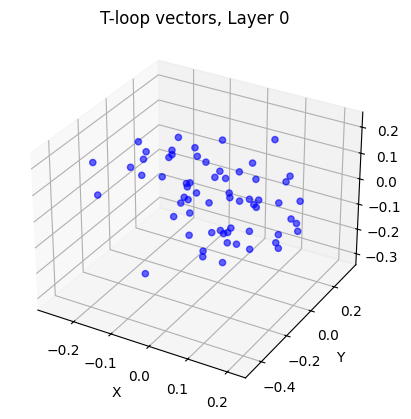

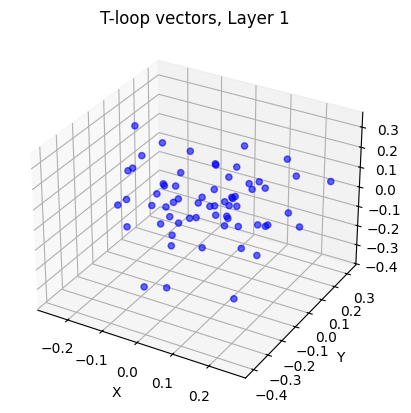

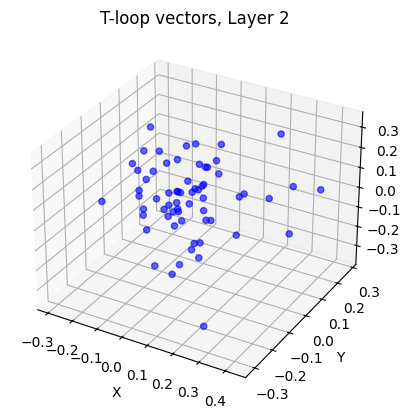

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# ---------------------- GPU Setup ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------- Parameters ----------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

NUM_LAYERS = 3
CELLS_PER_LAYER = 64
NUM_CELLS = NUM_LAYERS * CELLS_PER_LAYER
TIMESTEPS = 80
EPISODES = 30
GAMMA = 0.99  # discount factor

TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85

ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5

TLOOP_DIM = 3
OBS_DIM = 7  # tel_len deviation, debris, stress, neighbor_avg_debris, neighbor_avg_stress, tloop_mean, tloop_std

# ---------------------- Actor-Critic Network ----------------------
class ActorCritic(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.GELU(),
            nn.Linear(64,64),
            nn.GELU()
        )
        self.actor_mu = nn.Linear(64,1)
        self.actor_logstd = nn.Linear(64,1)
        self.critic = nn.Linear(64,1)
    def forward(self,x):
        h = self.shared(x)
        mu = torch.sigmoid(self.actor_mu(h))
        logstd = self.actor_logstd(h)
        std = torch.exp(logstd)
        value = self.critic(h)
        return mu, std, value

policy = ActorCritic(OBS_DIM).to(device)
optimizer = optim.Adam(policy.parameters(), lr=3e-3)

# ---------------------- Environment ----------------------
def init_cells(num_layers, cells_per_layer):
    num_cells = num_layers*cells_per_layer
    return {
        'tel_len': torch.empty(num_cells, device=device).uniform_(TARGET_LENGTH-800, TARGET_LENGTH+800),
        'debris': torch.empty(num_cells, device=device).uniform_(0,0.5),
        'cumulative_mut': torch.zeros(num_cells, device=device),
        'stress': torch.randn(num_cells, device=device)*0.05,
        'tloop_vec': torch.randn(num_cells, TLOOP_DIM, device=device)*0.1,
        'layers': torch.repeat_interleave(torch.arange(num_layers, device=device), cells_per_layer)
    }

def tloop_score(tloop_vec, tel_len, target_len=TARGET_LENGTH):
    fold_factor = torch.exp(-torch.abs(tel_len - target_len)/3000.0)
    docking_eff = torch.clamp(torch.sigmoid(tloop_vec.sum(dim=1))*fold_factor, 0.0, 1.0)
    return docking_eff

def telomerase_action(base_action, tloop_score):
    return base_action * tloop_score * TELOM_REPAIR_SCALE

def mutation_risk(base, action, damage, tloop_score):
    risk = base + action*MUTATION_ACTION_FACTOR + damage/10000.0
    return risk*(1.0 + (1.0 - tloop_score))

# ---------------------- Neighbor Matrix ----------------------
def build_neighbor_matrix(num_cells, layers, k=5):
    """
    Simple random neighbor graph: each cell connected to k neighbors
    """
    mat = torch.zeros(num_cells, num_cells, device=device)
    for i in range(num_cells):
        same_layer = (layers == layers[i]).nonzero(as_tuple=True)[0]
        adjacent_layer = ((layers == layers[i]-1) | (layers == layers[i]+1)).nonzero(as_tuple=True)[0]
        neighbors = torch.cat([same_layer, adjacent_layer])
        neighbors = neighbors[neighbors != i]
        if len(neighbors) > k:
            neighbors = neighbors[torch.randperm(len(neighbors))[:k]]
        mat[i, neighbors] = 1.0
    mat /= mat.sum(dim=1, keepdim=True)  # normalize
    return mat

# ---------------------- Multi-Cell Step ----------------------
def multi_cell_step(cells, actions, neighbor_matrix):
    neighbor_debris = neighbor_matrix @ cells['debris']
    neighbor_stress = neighbor_matrix @ cells['stress']
    avg_debris = cells['debris'].mean()
    damage = BASE_DAMAGE_RATE + torch.abs(torch.randn_like(cells['stress'])*STRESS_VARIANCE)*(1.0+avg_debris)
    tloop = tloop_score(cells['tloop_vec'], cells['tel_len'])
    repair = telomerase_action(actions.squeeze(-1), tloop)  # Squeeze actions here
    cells['tel_len'] += repair - damage
    cells['tel_len'] = torch.clamp(cells['tel_len'], MIN_LENGTH, MAX_LENGTH)
    mut = mutation_risk(MUTATION_BASE, actions.squeeze(-1), damage, tloop) # Squeeze actions here
    cells['cumulative_mut'] += mut
    cells['debris'] += damage*0.0005
    phago_mask = torch.rand_like(cells['debris']) < 0.1
    cells['debris'][phago_mask] *= (1.0-PHAGO_CLEARANCE_EFF)
    cells['tloop_vec'] += torch.randn_like(cells['tloop_vec'])*0.01
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_debris,
        neighbor_stress,
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1)
    ], dim=1)
    reward_per_cell = - ALPHA_length*torch.abs(cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH) \
                      - ALPHA_mut*mut - ALPHA_action*(actions.squeeze(-1)**2) # Squeeze actions here
    return obs, reward_per_cell, cells

# ---------------------- RL Training Loop ----------------------
neighbor_matrix = None
history = {'tel_len':[], 'mut_risk':[], 'tloop_vec':[], 'action':[]}

for ep in range(EPISODES):
    cells = init_cells(NUM_LAYERS, CELLS_PER_LAYER)
    if neighbor_matrix is None:
        neighbor_matrix = build_neighbor_matrix(NUM_CELLS, cells['layers'])
    log_probs = []
    values = []
    rewards = []
    actions_list = []

    for t in range(TIMESTEPS):
        obs = torch.stack([
            (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
            cells['debris'],
            cells['stress'],
            neighbor_matrix @ cells['debris'],
            neighbor_matrix @ cells['stress'],
            cells['tloop_vec'].mean(dim=1),
            cells['tloop_vec'].std(dim=1)
        ], dim=1)
        mu, std, value = policy(obs)
        dist = torch.distributions.Normal(mu, std)
        actions = torch.clamp(dist.sample(), 0.0, 1.0)
        log_prob = dist.log_prob(actions).sum(dim=0)
        obs, reward_per_cell, cells = multi_cell_step(cells, actions, neighbor_matrix)
        log_probs.append(log_prob)
        values.append(value.mean())
        rewards.append(reward_per_cell.mean())
        actions_list.append(actions.detach().cpu().numpy())
        history['tel_len'].append(cells['tel_len'].cpu().numpy())
        history['mut_risk'].append(cells['cumulative_mut'].cpu().numpy())
        history['tloop_vec'].append(cells['tloop_vec'].cpu().numpy())
        history['action'].append(actions.detach().cpu().numpy())

    # Compute discounted returns
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + GAMMA*G
        returns.insert(0, G)
    returns = torch.tensor(returns, device=device)
    values_tensor = torch.stack(values)
    advantages = returns - values_tensor

    # Actor-Critic loss
    actor_loss = -(torch.stack(log_probs) * advantages.detach()).mean()
    critic_loss = advantages.pow(2).mean()
    loss = actor_loss + 0.5*critic_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    avg_tel = cells['tel_len'].mean().item()
    avg_mut = cells['cumulative_mut'].mean().item()
    print(f"Episode {ep+1}/{EPISODES}: Avg Telomere={avg_tel:.1f}, Avg Cumulative Mutation={avg_mut:.4f}")

# ---------------------- 3D T-loop Visualization ----------------------
for layer in range(NUM_LAYERS):
    tloop_layer = np.array([tvec for idx,tvec in enumerate(history['tloop_vec'][-1]) if cells['layers'][idx]==layer])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tloop_layer[:,0], tloop_layer[:,1], tloop_layer[:,2], c='blue', alpha=0.6)
    ax.set_title(f"T-loop vectors, Layer {layer}")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    plt.show()

Using device: cpu


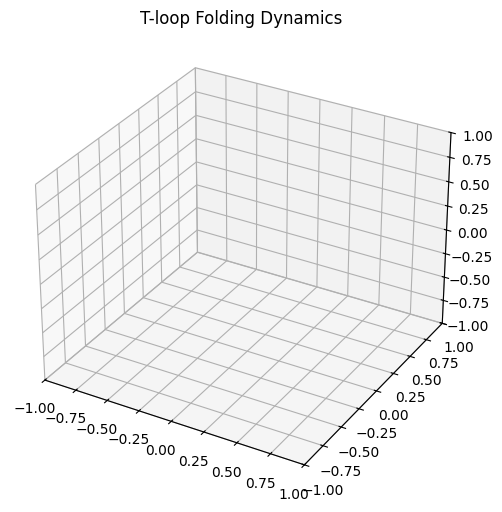

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# ---------------------- GPU Setup ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------- Parameters ----------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

NUM_LAYERS = 3
CELLS_PER_LAYER = 50
NUM_CELLS = NUM_LAYERS * CELLS_PER_LAYER
TIMESTEPS = 80
EPISODES = 20
GAMMA = 0.99

TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85

ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5

TLOOP_DIM = 3
OBS_DIM = 8  # tel_len deviation, debris, stress, neighbor_debris, neighbor_stress, tloop_mean, tloop_std, cell_type

# ---------------------- Actor-Critic ----------------------
class ActorCritic(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim,64),
            nn.GELU(),
            nn.Linear(64,64),
            nn.GELU()
        )
        self.actor_mu = nn.Linear(64,1)
        self.actor_logstd = nn.Linear(64,1)
        self.critic = nn.Linear(64,1)
    def forward(self,x):
        h = self.shared(x)
        mu = torch.sigmoid(self.actor_mu(h))
        logstd = self.actor_logstd(h)
        std = torch.exp(logstd)
        value = self.critic(h)
        return mu, std, value

policy = ActorCritic(OBS_DIM).to(device)
optimizer = optim.Adam(policy.parameters(), lr=3e-3)

# ---------------------- Environment ----------------------
def init_cells(num_layers, cells_per_layer):
    num_cells = num_layers*cells_per_layer
    types = torch.randint(0,3,(num_cells,), device=device)  # 0:stem,1:progenitor,2:diff
    return {
        'tel_len': torch.empty(num_cells, device=device).uniform_(TARGET_LENGTH-800, TARGET_LENGTH+800),
        'debris': torch.empty(num_cells, device=device).uniform_(0,0.5),
        'cumulative_mut': torch.zeros(num_cells, device=device),
        'stress': torch.randn(num_cells, device=device)*0.05,
        'tloop_vec': torch.randn(num_cells, TLOOP_DIM, device=device)*0.1,
        'layers': torch.repeat_interleave(torch.arange(num_layers, device=device), cells_per_layer),
        'types': types
    }

def tloop_score(tloop_vec, tel_len):
    fold_factor = torch.exp(-torch.abs(tel_len - TARGET_LENGTH)/3000.0)
    docking_eff = torch.clamp(torch.sigmoid(tloop_vec.sum(dim=1))*fold_factor, 0.0, 1.0)
    return docking_eff

def telomerase_action(base_action, tloop_score, cell_types):
    sensitivity = torch.tensor([1.2,1.0,0.6], device=device)  # stem more responsive
    return base_action * tloop_score * TELOM_REPAIR_SCALE * sensitivity[cell_types]

def mutation_risk(base, action, damage, tloop_score):
    risk = base + action*MUTATION_ACTION_FACTOR + damage/10000.0
    return risk*(1.0 + (1.0 - tloop_score))

def build_neighbor_matrix(num_cells, layers, k=5):
    mat = torch.zeros(num_cells, num_cells, device=device)
    for i in range(num_cells):
        same_layer = (layers==layers[i]).nonzero(as_tuple=True)[0]
        adj_layer = ((layers==layers[i]-1)|(layers==layers[i]+1)).nonzero(as_tuple=True)[0]
        neighbors = torch.cat([same_layer, adj_layer])
        neighbors = neighbors[neighbors!=i]
        if len(neighbors) > k:
            neighbors = neighbors[torch.randperm(len(neighbors))[:k]]
        mat[i, neighbors] = 1.0
    mat /= mat.sum(dim=1, keepdim=True)
    return mat

def multi_cell_step(cells, actions, neighbor_matrix):
    neighbor_debris = neighbor_matrix @ cells['debris']
    neighbor_stress = neighbor_matrix @ cells['stress']
    avg_debris = cells['debris'].mean()
    damage = BASE_DAMAGE_RATE + torch.abs(torch.randn_like(cells['stress'])*STRESS_VARIANCE)*(1.0+avg_debris)
    # Random DNA damage events
    damage += (torch.rand_like(damage)<0.01).float()*500
    tloop = tloop_score(cells['tloop_vec'], cells['tel_len'])
    repair = telomerase_action(actions, tloop, cells['types'])
    cells['tel_len'] += repair - damage
    cells['tel_len'] = torch.clamp(cells['tel_len'], MIN_LENGTH, MAX_LENGTH)
    mut = mutation_risk(MUTATION_BASE, actions, damage, tloop)
    cells['cumulative_mut'] += mut
    cells['debris'] += damage*0.0005
    phago_mask = torch.rand_like(cells['debris'])<0.1
    cells['debris'][phago_mask] *= (1.0-PHAGO_CLEARANCE_EFF)
    cells['tloop_vec'] += torch.randn_like(cells['tloop_vec'])*0.01
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_debris,
        neighbor_stress,
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0
    ], dim=1)
    reward_per_cell = - ALPHA_length*torch.abs(cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH) \
                      - ALPHA_mut*mut - ALPHA_action*(actions**2)
    return obs, reward_per_cell, cells

# ---------------------- RL Training Loop with Real-Time Animation ----------------------
cells = init_cells(NUM_LAYERS, CELLS_PER_LAYER)
neighbor_matrix = build_neighbor_matrix(NUM_CELLS, cells['layers'])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter([], [], [], c=[], cmap='viridis', s=[], alpha=0.7)
ax.set_xlim(-1,1); ax.set_ylim(-1,1); ax.set_zlim(-1,1)
ax.set_title("T-loop Folding Dynamics")

def init_anim():
    scat._offsets3d = ([],[],[])
    return scat,

def animate(frame):
    global cells
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_matrix @ cells['debris'],
        neighbor_matrix @ cells['stress'],
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0
    ], dim=1)
    mu, std, value = policy(obs)
    dist = torch.distributions.Normal(mu,std)
    actions = torch.clamp(dist.sample(),0,1)
    obs, reward_per_cell, cells = multi_cell_step(cells, actions, neighbor_matrix)
    tloop = cells['tloop_vec'].cpu().numpy()
    colors = cells['types'].cpu().numpy()
    sizes = ((cells['tel_len']-MIN_LENGTH)/(MAX_LENGTH-MIN_LENGTH)*50+10).cpu().numpy()
    scat._offsets3d = (tloop[:,0], tloop[:,1], tloop[:,2])
    scat.set_array(colors)
    scat.set_sizes(sizes)
    ax.set_title(f"Timestep {frame}")
    return scat,

ani = animation.FuncAnimation(fig, animate, frames=TIMESTEPS, init_func=init_anim,
                              interval=200, blit=False, repeat=False)
plt.show()

Using device: cpu


/usr/local/lib/python3.12/dist-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


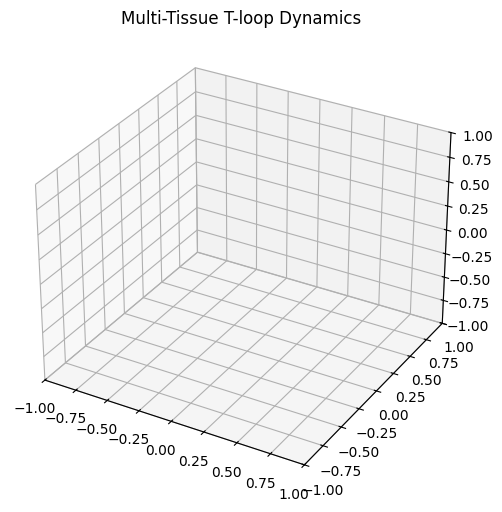

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# ---------------------- GPU Setup ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------- Parameters ----------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

NUM_TISSUES = 2
NUM_LAYERS = 2
CELLS_PER_LAYER = 40
NUM_CELLS = NUM_TISSUES * NUM_LAYERS * CELLS_PER_LAYER

TIMESTEPS = 60
EPISODES = 15
GAMMA = 0.99

TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85

ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5

TLOOP_DIM = 3
OBS_DIM = 9  # tel_len deviation, debris, stress, neighbor_debris, neighbor_stress, tloop_mean, tloop_std, cell_type, tissue_id

# ---------------------- Actor-Critic ----------------------
class ActorCritic(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim,64),
            nn.GELU(),
            nn.Linear(64,64),
            nn.GELU()
        )
        self.actor_mu = nn.Linear(64,1)
        self.actor_logstd = nn.Linear(64,1)
        self.critic = nn.Linear(64,1)
    def forward(self,x):
        h = self.shared(x)
        mu = torch.sigmoid(self.actor_mu(h))
        logstd = self.actor_logstd(h)
        std = torch.exp(logstd)
        value = self.critic(h)
        return mu, std, value

policy = ActorCritic(OBS_DIM).to(device)
optimizer = optim.Adam(policy.parameters(), lr=3e-3)

# ---------------------- Environment ----------------------
def init_cells(num_tissues, num_layers, cells_per_layer):
    num_cells = num_tissues*num_layers*cells_per_layer
    tissue_ids = torch.repeat_interleave(torch.arange(num_tissues, device=device), num_layers*cells_per_layer)
    layers = torch.tile(torch.arange(num_layers, device=device), (num_tissues, cells_per_layer)).flatten()
    types = torch.randint(0,3,(num_cells,), device=device)  # 0:stem,1:progenitor,2:diff
    return {
        'tel_len': torch.empty(num_cells, device=device).uniform_(TARGET_LENGTH-800, TARGET_LENGTH+800),
        'debris': torch.empty(num_cells, device=device).uniform_(0,0.5),
        'cumulative_mut': torch.zeros(num_cells, device=device),
        'stress': torch.randn(num_cells, device=device)*0.05,
        'tloop_vec': torch.randn(num_cells, TLOOP_DIM, device=device)*0.1,
        'layers': layers,
        'types': types,
        'tissues': tissue_ids
    }

def tloop_score(tloop_vec, tel_len):
    fold_factor = torch.exp(-torch.abs(tel_len - TARGET_LENGTH)/3000.0)
    docking_eff = torch.clamp(torch.sigmoid(tloop_vec.sum(dim=1))*fold_factor, 0.0, 1.0)
    return docking_eff

def telomerase_action(base_action, tloop_score, cell_types):
    sensitivity = torch.tensor([1.2,1.0,0.6], device=device)
    return base_action * tloop_score * TELOM_REPAIR_SCALE * sensitivity[cell_types]

def mutation_risk(base, action, damage, tloop_score):
    risk = base + action*MUTATION_ACTION_FACTOR + damage/10000.0
    return risk*(1.0 + (1.0 - tloop_score))

def build_neighbor_matrix(num_cells, layers, tissues, k=5):
    mat = torch.zeros(num_cells, num_cells, device=device)
    for i in range(num_cells):
        same_layer = (layers==layers[i]) & (tissues==tissues[i])
        adj_layer = ((layers==layers[i]-1)|(layers==layers[i]+1)) & (tissues==tissues[i])
        neighbors = (same_layer|adj_layer).nonzero(as_tuple=True)[0]
        neighbors = neighbors[neighbors!=i]
        if len(neighbors)>k:
            neighbors = neighbors[torch.randperm(len(neighbors))[:k]]
        mat[i, neighbors] = 1.0
    mat /= mat.sum(dim=1, keepdim=True)
    return mat

def multi_cell_step(cells, actions, neighbor_matrix):
    neighbor_debris = neighbor_matrix @ cells['debris']
    neighbor_stress = neighbor_matrix @ cells['stress']
    avg_debris = cells['debris'].mean()
    damage = BASE_DAMAGE_RATE + torch.abs(torch.randn_like(cells['stress'])*STRESS_VARIANCE)*(1.0+avg_debris)
    damage += (torch.rand_like(damage)<0.01).float()*500  # random DNA damage
    tloop = tloop_score(cells['tloop_vec'], cells['tel_len'])
    repair = telomerase_action(actions, tloop, cells['types'])
    cells['tel_len'] += repair - damage
    cells['tel_len'] = torch.clamp(cells['tel_len'], MIN_LENGTH, MAX_LENGTH)
    mut = mutation_risk(MUTATION_BASE, actions, damage, tloop)
    cells['cumulative_mut'] += mut
    cells['debris'] += damage*0.0005
    phago_mask = torch.rand_like(cells['debris'])<0.1
    cells['debris'][phago_mask] *= (1.0-PHAGO_CLEARANCE_EFF)
    cells['tloop_vec'] += torch.randn_like(cells['tloop_vec'])*0.01
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_debris,
        neighbor_stress,
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1)
    ], dim=1)
    reward_per_cell = - ALPHA_length*torch.abs(cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH) \
                      - ALPHA_mut*mut - ALPHA_action*(actions**2)
    return obs, reward_per_cell, cells

# ---------------------- Real-Time Animation Setup ----------------------
cells = init_cells(NUM_TISSUES, NUM_LAYERS, CELLS_PER_LAYER)
neighbor_matrix = build_neighbor_matrix(NUM_CELLS, cells['layers'], cells['tissues'])

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter([], [], [], c=[], cmap='viridis', s=[], alpha=0.7)
ax.set_xlim(-1,1); ax.set_ylim(-1,1); ax.set_zlim(-1,1)
ax.set_title("Multi-Tissue T-loop Dynamics")

def init_anim():
    scat._offsets3d = ([],[],[])
    return scat,

def animate(frame):
    global cells
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_matrix @ cells['debris'],
        neighbor_matrix @ cells['stress'],
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1)
    ], dim=1)
    mu, std, value = policy(obs)
    dist = torch.distributions.Normal(mu,std)
    actions = torch.clamp(dist.sample(),0,1)
    obs, reward_per_cell, cells = multi_cell_step(cells, actions, neighbor_matrix)
    tloop = cells['tloop_vec'].cpu().numpy()
    colors = cells['types'].cpu().numpy()
    sizes = ((cells['tel_len']-MIN_LENGTH)/(MAX_LENGTH-MIN_LENGTH)*50+10).cpu().numpy()
    scat._offsets3d = (tloop[:,0], tloop[:,1], tloop[:,2])
    scat.set_array(colors)
    scat.set_sizes(sizes)
    ax.set_title(f"Timestep {frame}")
    return scat,

ani = animation.FuncAnimation(fig, animate, frames=TIMESTEPS, init_func=init_anim,
                              interval=200, blit=False, repeat=False)
plt.show()

Using device: cpu


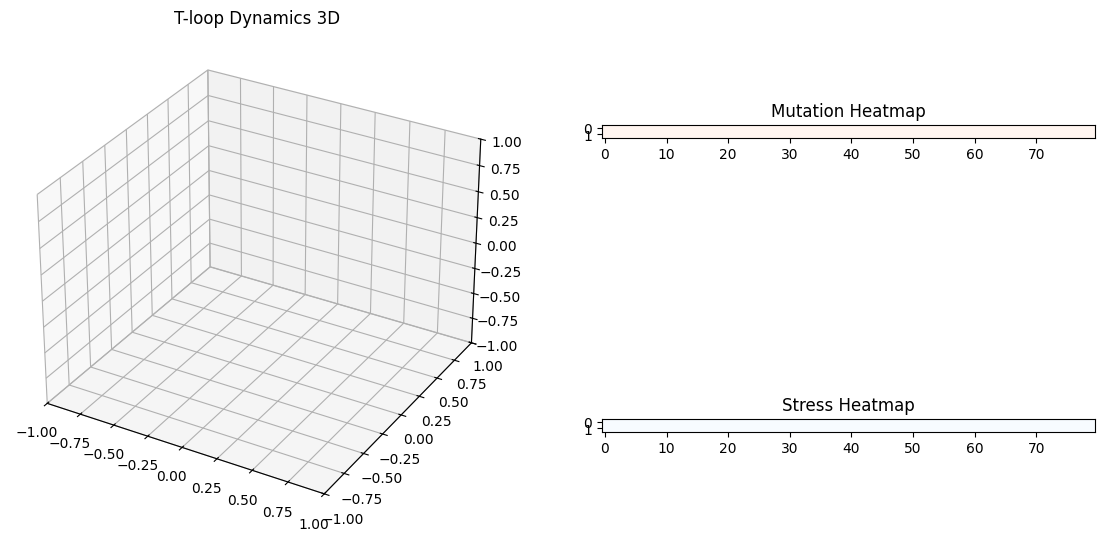

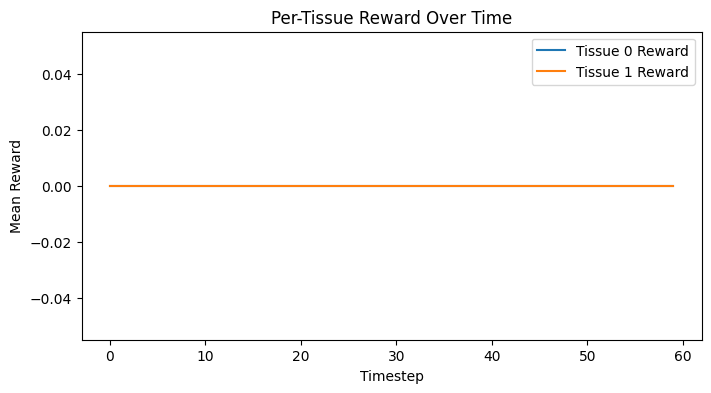

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# ---------------------- GPU Setup ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------- Parameters ----------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

NUM_TISSUES = 2
NUM_LAYERS = 2
CELLS_PER_LAYER = 40
NUM_CELLS = NUM_TISSUES * NUM_LAYERS * CELLS_PER_LAYER

TIMESTEPS = 60
GAMMA = 0.99

TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85

ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5

TLOOP_DIM = 3
OBS_DIM = 9  # tel_len deviation, debris, stress, neighbor_debris, neighbor_stress, tloop_mean, tloop_std, cell_type, tissue_id

# ---------------------- Actor-Critic ----------------------
class ActorCritic(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim,64),
            nn.GELU(),
            nn.Linear(64,64),
            nn.GELU()
        )
        self.actor_mu = nn.Linear(64,1)
        self.actor_logstd = nn.Linear(64,1)
        self.critic = nn.Linear(64,1)
    def forward(self,x):
        h = self.shared(x)
        mu = torch.sigmoid(self.actor_mu(h))
        logstd = self.actor_logstd(h)
        std = torch.exp(logstd)
        value = self.critic(h)
        return mu, std, value

policy = ActorCritic(OBS_DIM).to(device)
optimizer = optim.Adam(policy.parameters(), lr=3e-3)

# ---------------------- Environment ----------------------
def init_cells(num_tissues, num_layers, cells_per_layer):
    num_cells = num_tissues*num_layers*cells_per_layer
    tissue_ids = torch.repeat_interleave(torch.arange(num_tissues, device=device), num_layers*cells_per_layer)
    layers = torch.tile(torch.arange(num_layers, device=device), (num_tissues, cells_per_layer)).flatten()
    types = torch.randint(0,3,(num_cells,), device=device)
    return {
        'tel_len': torch.empty(num_cells, device=device).uniform_(TARGET_LENGTH-800, TARGET_LENGTH+800),
        'debris': torch.empty(num_cells, device=device).uniform_(0,0.5),
        'cumulative_mut': torch.zeros(num_cells, device=device),
        'stress': torch.randn(num_cells, device=device)*0.05,
        'tloop_vec': torch.randn(num_cells, TLOOP_DIM, device=device)*0.1,
        'layers': layers,
        'types': types,
        'tissues': tissue_ids
    }

def tloop_score(tloop_vec, tel_len):
    fold_factor = torch.exp(-torch.abs(tel_len - TARGET_LENGTH)/3000.0)
    docking_eff = torch.clamp(torch.sigmoid(tloop_vec.sum(dim=1))*fold_factor, 0.0, 1.0)
    return docking_eff

def telomerase_action(base_action, tloop_score, cell_types):
    sensitivity = torch.tensor([1.2,1.0,0.6], device=device)
    return base_action * tloop_score * TELOM_REPAIR_SCALE * sensitivity[cell_types]

def mutation_risk(base, action, damage, tloop_score):
    risk = base + action*MUTATION_ACTION_FACTOR + damage/10000.0
    return risk*(1.0 + (1.0 - tloop_score))

def build_neighbor_matrix(num_cells, layers, tissues, k=5):
    mat = torch.zeros(num_cells, num_cells, device=device)
    for i in range(num_cells):
        same_layer = (layers==layers[i]) & (tissues==tissues[i])
        adj_layer = ((layers==layers[i]-1)|(layers==layers[i]+1)) & (tissues==tissues[i])
        neighbors = (same_layer|adj_layer).nonzero(as_tuple=True)[0]
        neighbors = neighbors[neighbors!=i]
        if len(neighbors)>k:
            neighbors = neighbors[torch.randperm(len(neighbors))[:k]]
        mat[i, neighbors] = 1.0
    mat /= mat.sum(dim=1, keepdim=True)
    return mat

def multi_cell_step(cells, actions, neighbor_matrix):
    neighbor_debris = neighbor_matrix @ cells['debris']
    neighbor_stress = neighbor_matrix @ cells['stress']
    avg_debris = cells['debris'].mean()
    damage = BASE_DAMAGE_RATE + torch.abs(torch.randn_like(cells['stress'])*STRESS_VARIANCE)*(1.0+avg_debris)
    damage += (torch.rand_like(damage)<0.01).float()*500
    tloop = tloop_score(cells['tloop_vec'], cells['tel_len'])
    repair = telomerase_action(actions, tloop, cells['types'])
    cells['tel_len'] += repair - damage
    cells['tel_len'] = torch.clamp(cells['tel_len'], MIN_LENGTH, MAX_LENGTH)
    mut = mutation_risk(0.001, actions, damage, tloop)
    cells['cumulative_mut'] += mut
    cells['debris'] += damage*0.0005
    phago_mask = torch.rand_like(cells['debris'])<0.1
    cells['debris'][phago_mask] *= (1.0-PHAGO_CLEARANCE_EFF)
    cells['tloop_vec'] += torch.randn_like(cells['tloop_vec'])*0.01
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_matrix @ cells['debris'],
        neighbor_matrix @ cells['stress'],
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1)
    ], dim=1)
    reward_per_cell = - ALPHA_length*torch.abs(cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH) \
                      - ALPHA_mut*mut - ALPHA_action*(actions**2)
    return obs, reward_per_cell, cells

# ---------------------- Animation and Heatmap ----------------------
cells = init_cells(NUM_TISSUES, NUM_LAYERS, CELLS_PER_LAYER)
neighbor_matrix = build_neighbor_matrix(NUM_CELLS, cells['layers'], cells['tissues'])

fig = plt.figure(figsize=(14,7))
ax3d = fig.add_subplot(121, projection='3d')
ax_mut = fig.add_subplot(222)
ax_stress = fig.add_subplot(224)

scat = ax3d.scatter([], [], [], c=[], cmap='viridis', s=[], alpha=0.7)
ax3d.set_xlim(-1,1); ax3d.set_ylim(-1,1); ax3d.set_zlim(-1,1)
ax3d.set_title("T-loop Dynamics 3D")

# Initialize heatmaps
heat_mut = ax_mut.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='Reds', vmin=0, vmax=0.05)
ax_mut.set_title("Mutation Heatmap")
heat_stress = ax_stress.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='Blues', vmin=0, vmax=0.5)
ax_stress.set_title("Stress Heatmap")

reward_history = np.zeros((NUM_TISSUES,TIMESTEPS))

def init_anim():
    scat._offsets3d = ([],[],[])
    heat_mut.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    heat_stress.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    return scat, heat_mut, heat_stress

def animate(frame):
    global cells, reward_history
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_matrix @ cells['debris'],
        neighbor_matrix @ cells['stress'],
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1)
    ], dim=1)
    mu, std, value = policy(obs)
    dist = torch.distributions.Normal(mu,std)
    actions = torch.clamp(dist.sample(),0,1)
    obs, reward_per_cell, cells = multi_cell_step(cells, actions, neighbor_matrix)

    # 3D scatter
    tloop = cells['tloop_vec'].cpu().numpy()
    colors = cells['types'].cpu().numpy()
    sizes = ((cells['tel_len']-MIN_LENGTH)/(MAX_LENGTH-MIN_LENGTH)*50+10).cpu().numpy()
    scat._offsets3d = (tloop[:,0], tloop[:,1], tloop[:,2])
    scat.set_array(colors)
    scat.set_sizes(sizes)
    ax3d.set_title(f"Timestep {frame}")

    # Heatmaps per tissue
    mut_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    stress_map = np.zeros_like(mut_map)
    for t in range(NUM_TISSUES):
        mask = (cells['tissues']==t).cpu().numpy()
        mut_map[t,:mask.sum()] = cells['cumulative_mut'][mask].cpu().numpy()
        stress_map[t,:mask.sum()] = cells['stress'][mask].cpu().numpy()
        reward_history[t,frame] = reward_per_cell[mask].mean().item()

    heat_mut.set_data(mut_map)
    heat_stress.set_data(stress_map)

    return scat, heat_mut, heat_stress

ani = animation.FuncAnimation(fig, animate, frames=TIMESTEPS, init_func=init_anim,
                              interval=200, blit=False, repeat=False)
plt.show()

# Plot per-tissue cumulative reward after simulation
plt.figure(figsize=(8,4))
for t in range(NUM_TISSUES):
    plt.plot(reward_history[t], label=f"Tissue {t} Reward")
plt.xlabel("Timestep")
plt.ylabel("Mean Reward")
plt.title("Per-Tissue Reward Over Time")
plt.legend()
plt.show()

Using device: cpu


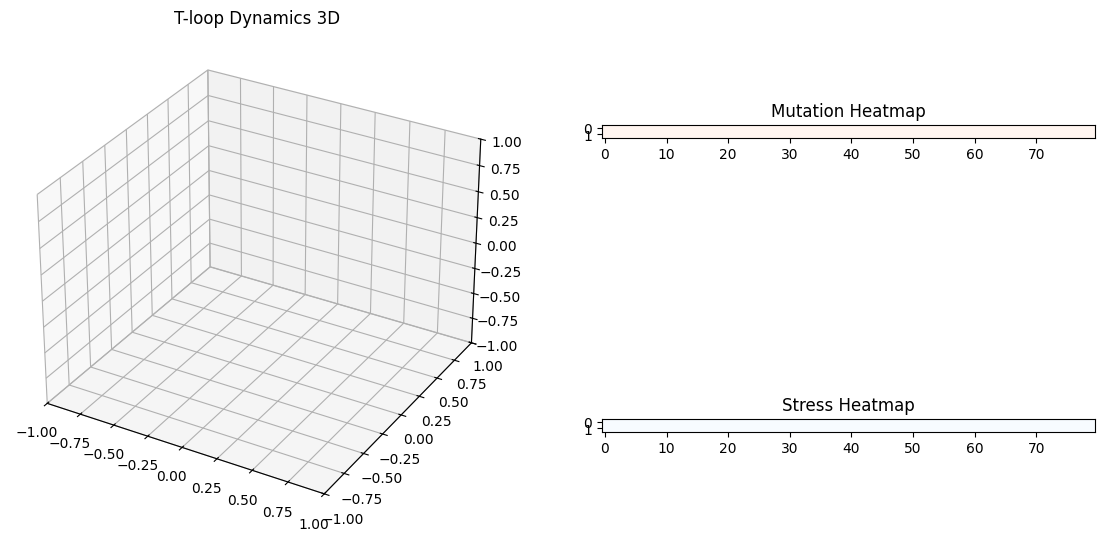

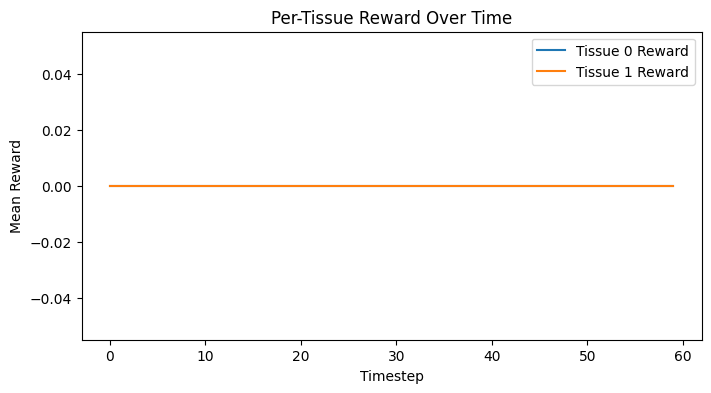

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# ---------------------- GPU Setup ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------- Parameters ----------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

NUM_TISSUES = 2
NUM_LAYERS = 2
CELLS_PER_LAYER = 40
NUM_CELLS = NUM_TISSUES * NUM_LAYERS * CELLS_PER_LAYER
TIMESTEPS = 60

TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85

ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5
ALPHA_diff = 2.0

TLOOP_DIM = 3
OBS_DIM = 10  # added cross-tissue signal

# ---------------------- Actor-Critic ----------------------
class ActorCritic(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim,64),
            nn.GELU(),
            nn.Linear(64,64),
            nn.GELU()
        )
        self.actor_mu = nn.Linear(64,1)
        self.actor_logstd = nn.Linear(64,1)
        self.critic = nn.Linear(64,1)
    def forward(self,x):
        h = self.shared(x)
        mu = torch.sigmoid(self.actor_mu(h))
        logstd = self.actor_logstd(h)
        std = torch.exp(logstd)
        value = self.critic(h)
        return mu, std, value

policy = ActorCritic(OBS_DIM).to(device)
optimizer = optim.Adam(policy.parameters(), lr=3e-3)

# ---------------------- Environment ----------------------
def init_cells(num_tissues, num_layers, cells_per_layer):
    tissue_ids = torch.repeat_interleave(torch.arange(num_tissues, device=device), num_layers*cells_per_layer)
    layers = torch.tile(torch.arange(num_layers, device=device), (num_tissues, cells_per_layer)).flatten()
    types = torch.zeros(NUM_CELLS, dtype=torch.long, device=device)  # 0: stem, 1: progenitor, 2: diff
    return {
        'tel_len': torch.empty(NUM_CELLS, device=device).uniform_(TARGET_LENGTH-800, TARGET_LENGTH+800),
        'debris': torch.empty(NUM_CELLS, device=device).uniform_(0,0.5),
        'cumulative_mut': torch.zeros(NUM_CELLS, device=device),
        'stress': torch.randn(NUM_CELLS, device=device)*0.05,
        'tloop_vec': torch.randn(NUM_CELLS, TLOOP_DIM, device=device)*0.1,
        'layers': layers,
        'types': types,
        'tissues': tissue_ids
    }

def tloop_score(tloop_vec, tel_len):
    fold_factor = torch.exp(-torch.abs(tel_len - TARGET_LENGTH)/3000.0)
    docking_eff = torch.clamp(torch.sigmoid(tloop_vec.sum(dim=1))*fold_factor, 0.0, 1.0)
    return docking_eff

def telomerase_action(base_action, tloop_score, cell_types):
    sensitivity = torch.tensor([1.2,1.0,0.6], device=device)
    return base_action * tloop_score * TELOM_REPAIR_SCALE * sensitivity[cell_types]

def mutation_risk(base, action, damage, tloop_score):
    risk = base + action*MUTATION_ACTION_FACTOR + damage/10000.0
    return risk*(1.0 + (1.0 - tloop_score))

def build_neighbor_matrix(num_cells, layers, tissues, k=5):
    mat = torch.zeros(num_cells, num_cells, device=device)
    for i in range(num_cells):
        same_layer = (layers==layers[i]) & (tissues==tissues[i])
        adj_layer = ((layers==layers[i]-1)|(layers==layers[i]+1)) & (tissues==tissues[i])
        neighbors = (same_layer|adj_layer).nonzero(as_tuple=True)[0]
        neighbors = neighbors[neighbors!=i]
        if len(neighbors)>k:
            neighbors = neighbors[torch.randperm(len(neighbors))[:k]]
        mat[i, neighbors] = 1.0
    mat /= mat.sum(dim=1, keepdim=True)
    return mat

def multi_cell_step(cells, actions, neighbor_matrix, cross_signal):
    neighbor_debris = neighbor_matrix @ cells['debris']
    neighbor_stress = neighbor_matrix @ cells['stress']
    avg_debris = cells['debris'].mean()
    damage = BASE_DAMAGE_RATE + torch.abs(torch.randn_like(cells['stress'])*STRESS_VARIANCE)*(1.0+avg_debris)
    damage += (torch.rand_like(damage)<0.01).float()*500
    tloop = tloop_score(cells['tloop_vec'], cells['tel_len'])
    repair = telomerase_action(actions, tloop, cells['types'])
    # cross-tissue signal effect
    repair += cross_signal[cells['tissues']]*0.5
    cells['tel_len'] += repair - damage
    cells['tel_len'] = torch.clamp(cells['tel_len'], MIN_LENGTH, MAX_LENGTH)
    mut = mutation_risk(MUTATION_BASE, actions, damage, tloop)
    cells['cumulative_mut'] += mut
    cells['debris'] += damage*0.0005
    phago_mask = torch.rand_like(cells['debris'])<0.1
    cells['debris'][phago_mask] *= (1.0-PHAGO_CLEARANCE_EFF)
    cells['tloop_vec'] += torch.randn_like(cells['tloop_vec'])*0.01

    # ----------------- Differentiation -----------------
    # Stem -> Progenitor -> Differentiated
    diff_prob = torch.zeros_like(cells['types'], dtype=torch.float)
    diff_prob[cells['types']==0] = 0.02 + (TARGET_LENGTH - cells['tel_len'][cells['types']==0])/20000.0 + cross_signal[cells['tissues'][cells['types']==0]]*0.05
    diff_prob[cells['types']==1] = 0.01 + cross_signal[cells['tissues'][cells['types']==1]]*0.02
    rand_vals = torch.rand_like(diff_prob)
    cells['types'][(cells['types']==0) & (rand_vals<diff_prob)] = 1
    cells['types'][(cells['types']==1) & (rand_vals<diff_prob)] = 2

    # Update observation
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_debris,
        neighbor_stress,
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1),
        cross_signal[cells['tissues']]
    ], dim=1)
    reward_per_cell = - ALPHA_length*torch.abs(cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH) \
                      - ALPHA_mut*mut - ALPHA_action*(actions**2) \
                      - ALPHA_diff*(cells['types']==2).float()*0.01
    return obs, reward_per_cell, cells

# ---------------------- Simulation Setup ----------------------
cells = init_cells(NUM_TISSUES, NUM_LAYERS, CELLS_PER_LAYER)
neighbor_matrix = build_neighbor_matrix(NUM_CELLS, cells['layers'], cells['tissues'], k=5)
cross_signal = torch.zeros(NUM_TISSUES, device=device)

# ---------------------- Animation ----------------------
fig = plt.figure(figsize=(14,7))
ax3d = fig.add_subplot(121, projection='3d')
ax_mut = fig.add_subplot(222)
ax_stress = fig.add_subplot(224)

scat = ax3d.scatter([], [], [], c=[], cmap='viridis', s=[], alpha=0.7)
ax3d.set_xlim(-1,1); ax3d.set_ylim(-1,1); ax3d.set_zlim(-1,1)
ax3d.set_title("T-loop Dynamics 3D")

heat_mut = ax_mut.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='Reds', vmin=0, vmax=0.05)
ax_mut.set_title("Mutation Heatmap")
heat_stress = ax_stress.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='Blues', vmin=0, vmax=0.5)
ax_stress.set_title("Stress Heatmap")

reward_history = np.zeros((NUM_TISSUES,TIMESTEPS))

def init_anim():
    scat._offsets3d = ([],[],[])
    heat_mut.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    heat_stress.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    return scat, heat_mut, heat_stress

def animate(frame):
    global cells, reward_history, cross_signal
    # update cross-tissue signal based on avg stress per tissue
    for t in range(NUM_TISSUES):
        cross_signal[t] = cells['stress'][cells['tissues']==t].mean()*0.1

    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_matrix @ cells['debris'],
        neighbor_matrix @ cells['stress'],
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1),
        cross_signal[cells['tissues']]
    ], dim=1)
    mu, std, value = policy(obs)
    dist = torch.distributions.Normal(mu,std)
    actions = torch.clamp(dist.sample(),0,1)

    obs, reward_per_cell, cells = multi_cell_step(cells, actions, neighbor_matrix, cross_signal)

    # 3D T-loop scatter
    tloop = cells['tloop_vec'].cpu().numpy()
    colors = cells['types'].cpu().numpy()
    sizes = ((cells['tel_len']-MIN_LENGTH)/(MAX_LENGTH-MIN_LENGTH)*50+10).cpu().numpy()
    scat._offsets3d = (tloop[:,0], tloop[:,1], tloop[:,2])
    scat.set_array(colors)
    scat.set_sizes(sizes)
    ax3d.set_title(f"Timestep {frame}")

    # Heatmaps
    mut_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    stress_map = np.zeros_like(mut_map)
    for t in range(NUM_TISSUES):
        mask = (cells['tissues']==t).cpu().numpy()
        mut_map[t,:mask.sum()] = cells['cumulative_mut'][mask].cpu().numpy()
        stress_map[t,:mask.sum()] = cells['stress'][mask].cpu().numpy()
        reward_history[t,frame] = reward_per_cell[mask].mean().item()

    heat_mut.set_data(mut_map)
    heat_stress.set_data(stress_map)

    return scat, heat_mut, heat_stress

ani = animation.FuncAnimation(fig, animate, frames=TIMESTEPS, init_func=init_anim,
                              interval=200, blit=False, repeat=False)
plt.show()

# Plot per-tissue cumulative reward
plt.figure(figsize=(8,4))
for t in range(NUM_TISSUES):
    plt.plot(reward_history[t], label=f"Tissue {t} Reward")
plt.xlabel("Timestep")
plt.ylabel("Mean Reward")
plt.title("Per-Tissue Reward Over Time")
plt.legend()
plt.show()

Using device: cpu


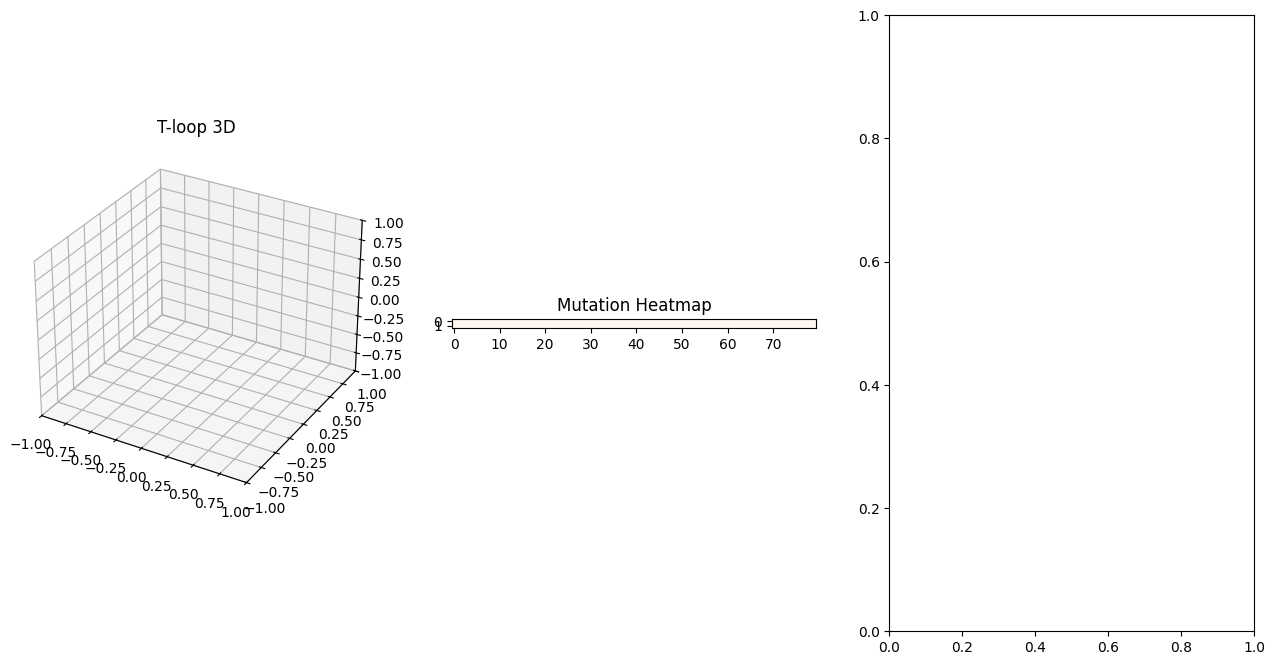

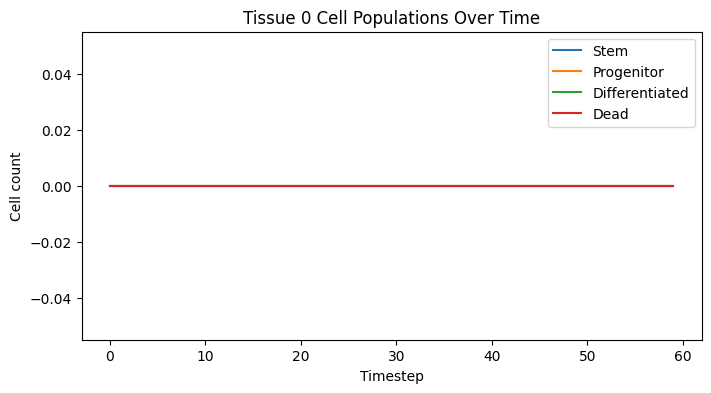

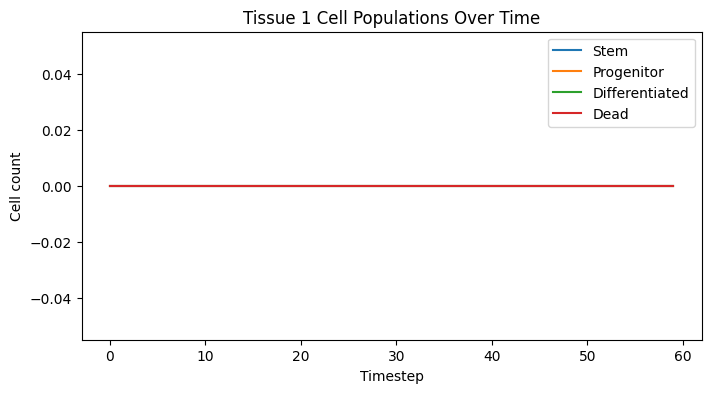

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

# ------------------- Device -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------- Parameters -------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

NUM_TISSUES = 2
NUM_LAYERS = 2
CELLS_PER_LAYER = 40
NUM_CELLS = NUM_TISSUES * NUM_LAYERS * CELLS_PER_LAYER
TIMESTEPS = 60

TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85

DEATH_TELOM = 6800.0
DEATH_MUTATION = 0.05
DEATH_STRESS = 0.8

ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5
ALPHA_diff = 2.0
ALPHA_vitality = 5.0

TLOOP_DIM = 3
OBS_DIM = 10  # includes cross-tissue signal

# ------------------- Actor-Critic -------------------
class ActorCritic(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim,64),
            nn.GELU(),
            nn.Linear(64,64),
            nn.GELU()
        )
        self.actor_mu = nn.Linear(64,1)
        self.actor_logstd = nn.Linear(64,1)
        self.critic = nn.Linear(64,1)
    def forward(self,x):
        h = self.shared(x)
        mu = torch.sigmoid(self.actor_mu(h))
        logstd = self.actor_logstd(h)
        std = torch.exp(logstd)
        value = self.critic(h)
        return mu, std, value

policy = ActorCritic(OBS_DIM).to(device)
optimizer = optim.Adam(policy.parameters(), lr=3e-3)

# ------------------- Initialize Cells -------------------
def init_cells(num_tissues, num_layers, cells_per_layer):
    tissue_ids = torch.repeat_interleave(torch.arange(num_tissues, device=device), num_layers*cells_per_layer)
    layers = torch.tile(torch.arange(num_layers, device=device), (num_tissues, cells_per_layer)).flatten()
    types = torch.zeros(NUM_CELLS, dtype=torch.long, device=device)  # 0: stem, 1: progenitor, 2: diff
    return {
        'tel_len': torch.empty(NUM_CELLS, device=device).uniform_(TARGET_LENGTH-800, TARGET_LENGTH+800),
        'debris': torch.empty(NUM_CELLS, device=device).uniform_(0,0.5),
        'cumulative_mut': torch.zeros(NUM_CELLS, device=device),
        'stress': torch.randn(NUM_CELLS, device=device)*0.05,
        'tloop_vec': torch.randn(NUM_CELLS, TLOOP_DIM, device=device)*0.1,
        'layers': layers,
        'types': types,
        'tissues': tissue_ids,
        'alive': torch.ones(NUM_CELLS, dtype=torch.bool, device=device)
    }

# ------------------- Functions -------------------
def tloop_score(tloop_vec, tel_len):
    fold_factor = torch.exp(-torch.abs(tel_len - TARGET_LENGTH)/3000.0)
    docking_eff = torch.clamp(torch.sigmoid(tloop_vec.sum(dim=1))*fold_factor, 0.0, 1.0)
    return docking_eff

def telomerase_action(base_action, tloop_score, cell_types):
    sensitivity = torch.tensor([1.2,1.0,0.6], device=device)
    return base_action * tloop_score * TELOM_REPAIR_SCALE * sensitivity[cell_types]

def mutation_risk(base, action, damage, tloop_score):
    risk = base + action*MUTATION_ACTION_FACTOR + damage/10000.0
    return risk*(1.0 + (1.0 - tloop_score))

def build_neighbor_matrix(num_cells, layers, tissues, k=5):
    mat = torch.zeros(num_cells, num_cells, device=device)
    for i in range(num_cells):
        same_layer = (layers==layers[i]) & (tissues==tissues[i])
        adj_layer = ((layers==layers[i]-1)|(layers==layers[i]+1)) & (tissues==tissues[i])
        neighbors = (same_layer|adj_layer).nonzero(as_tuple=True)[0]
        neighbors = neighbors[neighbors!=i]
        if len(neighbors)>k:
            neighbors = neighbors[torch.randperm(len(neighbors))[:k]]
        mat[i, neighbors] = 1.0
    mat /= mat.sum(dim=1, keepdim=True)
    return mat

def multi_cell_step(cells, actions, neighbor_matrix, cross_signal):
    alive_mask = cells['alive']
    neighbor_debris = neighbor_matrix @ cells['debris']
    neighbor_stress = neighbor_matrix @ cells['stress']
    avg_debris = cells['debris'].mean()
    damage = BASE_DAMAGE_RATE + torch.abs(torch.randn_like(cells['stress'])*STRESS_VARIANCE)*(1.0+avg_debris)
    damage += (torch.rand_like(damage)<0.01).float()*500
    tloop = tloop_score(cells['tloop_vec'], cells['tel_len'])
    repair = telomerase_action(actions, tloop, cells['types'])
    repair += cross_signal[cells['tissues']]*0.5
    cells['tel_len'] += repair - damage
    cells['tel_len'] = torch.clamp(cells['tel_len'], MIN_LENGTH, MAX_LENGTH)
    mut = mutation_risk(MUTATION_BASE, actions, damage, tloop)
    cells['cumulative_mut'] += mut
    cells['debris'] += damage*0.0005
    phago_mask = torch.rand_like(cells['debris'])<0.1
    cells['debris'][phago_mask] *= (1.0-PHAGO_CLEARANCE_EFF)
    cells['tloop_vec'] += torch.randn_like(cells['tloop_vec'])*0.01

    # ----------------- Cell Death -----------------
    death_mask = alive_mask & ((cells['tel_len']<DEATH_TELOM) |
                               (cells['cumulative_mut']>DEATH_MUTATION) |
                               (cells['stress']>DEATH_STRESS))
    cells['alive'][death_mask] = False
    cells['debris'][death_mask] += 0.05  # dead cells add debris

    # ----------------- Differentiation -----------------
    diff_prob = torch.zeros_like(cells['types'], dtype=torch.float)
    diff_prob[cells['types']==0] = 0.02 + (TARGET_LENGTH - cells['tel_len'][cells['types']==0])/20000.0 + cross_signal[cells['tissues'][cells['types']==0]]*0.05
    diff_prob[cells['types']==1] = 0.01 + cross_signal[cells['tissues'][cells['types']==1]]*0.02
    rand_vals = torch.rand_like(diff_prob)
    cells['types'][(cells['types']==0) & (rand_vals<diff_prob)] = 1
    cells['types'][(cells['types']==1) & (rand_vals<diff_prob)] = 2

    # ----------------- Regeneration -----------------
    for t in range(NUM_TISSUES):
        tissue_mask = (cells['tissues']==t) & (~cells['alive'])
        if tissue_mask.sum()>0:
            stem_pool = (cells['tissues']==t) & (cells['types']==0) & (cells['alive'])
            if stem_pool.sum()>0:
                # randomly revive dead cell
                revive_idx = tissue_mask.nonzero(as_tuple=True)[0][0]
                donor_idx = stem_pool.nonzero(as_tuple=True)[0][torch.randint(0,len(stem_pool.nonzero()),(1,)).item()]
                cells['tel_len'][revive_idx] = cells['tel_len'][donor_idx].clone()
                cells['types'][revive_idx] = 0
                cells['tloop_vec'][revive_idx] = cells['tloop_vec'][donor_idx].clone()
                cells['cumulative_mut'][revive_idx] = cells['cumulative_mut'][donor_idx]*0.5
                cells['stress'][revive_idx] = 0.0
                cells['alive'][revive_idx] = True

    # ----------------- Observation & Reward -----------------
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_debris,
        neighbor_stress,
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1),
        cross_signal[cells['tissues']]
    ], dim=1)
    reward_per_cell = - ALPHA_length*torch.abs(cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH) \
                      - ALPHA_mut*mut - ALPHA_action*(actions**2) \
                      - ALPHA_diff*(cells['types']==2).float()*0.01 \
                      + ALPHA_vitality*cells['alive'].float()*0.01
    return obs, reward_per_cell, cells

# ------------------- Simulation -------------------
cells = init_cells(NUM_TISSUES, NUM_LAYERS, CELLS_PER_LAYER)
neighbor_matrix = build_neighbor_matrix(NUM_CELLS, cells['layers'], cells['tissues'], k=5)
cross_signal = torch.zeros(NUM_TISSUES, device=device)

# ------------------- Visualization -------------------
fig = plt.figure(figsize=(16,8))
ax3d = fig.add_subplot(131, projection='3d')
ax_mut = fig.add_subplot(132)
ax_pop = fig.add_subplot(133)

scat = ax3d.scatter([], [], [], c=[], cmap='viridis', s=[], alpha=0.7)
ax3d.set_xlim(-1,1); ax3d.set_ylim(-1,1); ax3d.set_zlim(-1,1)
ax3d.set_title("T-loop 3D")

heat_mut = ax_mut.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='Reds', vmin=0, vmax=0.05)
ax_mut.set_title("Mutation Heatmap")

pop_history = np.zeros((NUM_TISSUES, TIMESTEPS, 4)) # stem, progenitor, diff, dead

def init_anim():
    scat._offsets3d = ([],[],[])
    heat_mut.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    return scat, heat_mut

def animate(frame):
    global cells, cross_signal, pop_history
    for t in range(NUM_TISSUES):
        cross_signal[t] = cells['stress'][cells['tissues']==t].mean()*0.1
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_matrix @ cells['debris'],
        neighbor_matrix @ cells['stress'],
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1),
        cross_signal[cells['tissues']]
    ], dim=1)
    mu,std,value = policy(obs)
    dist = torch.distributions.Normal(mu,std)
    actions = torch.clamp(dist.sample(),0,1)
    obs, reward_per_cell, cells = multi_cell_step(cells, actions, neighbor_matrix, cross_signal)

    # 3D scatter
    tloop = cells['tloop_vec'].cpu().numpy()
    colors = cells['types'].cpu().numpy()
    sizes = ((cells['tel_len']-MIN_LENGTH)/(MAX_LENGTH-MIN_LENGTH)*50+10).cpu().numpy()
    scat._offsets3d = (tloop[:,0], tloop[:,1], tloop[:,2])
    scat.set_array(colors)
    scat.set_sizes(sizes)
    ax3d.set_title(f"Timestep {frame}")

    # Mutation heatmap
    mut_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t in range(NUM_TISSUES):
        mask = (cells['tissues']==t).cpu().numpy()
        mut_map[t,:mask.sum()] = cells['cumulative_mut'][mask].cpu().numpy()
        # population tracking
        tissue_cells = cells['tissues']==t
        pop_history[t,frame,0] = ((cells['types']==0)&cells['alive']).sum().item()
        pop_history[t,frame,1] = ((cells['types']==1)&cells['alive']).sum().item()
        pop_history[t,frame,2] = ((cells['types']==2)&cells['alive']).sum().item()
        pop_history[t,frame,3] = ((~cells['alive']) & tissue_cells).sum().item()

    heat_mut.set_data(mut_map)
    return scat, heat_mut

ani = animation.FuncAnimation(fig, animate, frames=TIMESTEPS, init_func=init_anim,
                              interval=200, blit=False, repeat=False)
plt.show()

# ------------------- Population Plots -------------------
for t in range(NUM_TISSUES):
    plt.figure(figsize=(8,4))
    plt.plot(pop_history[t,:,0], label='Stem')
    plt.plot(pop_history[t,:,1], label='Progenitor')
    plt.plot(pop_history[t,:,2], label='Differentiated')
    plt.plot(pop_history[t,:,3], label='Dead')
    plt.xlabel("Timestep")
    plt.ylabel("Cell count")
    plt.title(f"Tissue {t} Cell Populations Over Time")
    plt.legend()
    plt.show()

Using device: cpu


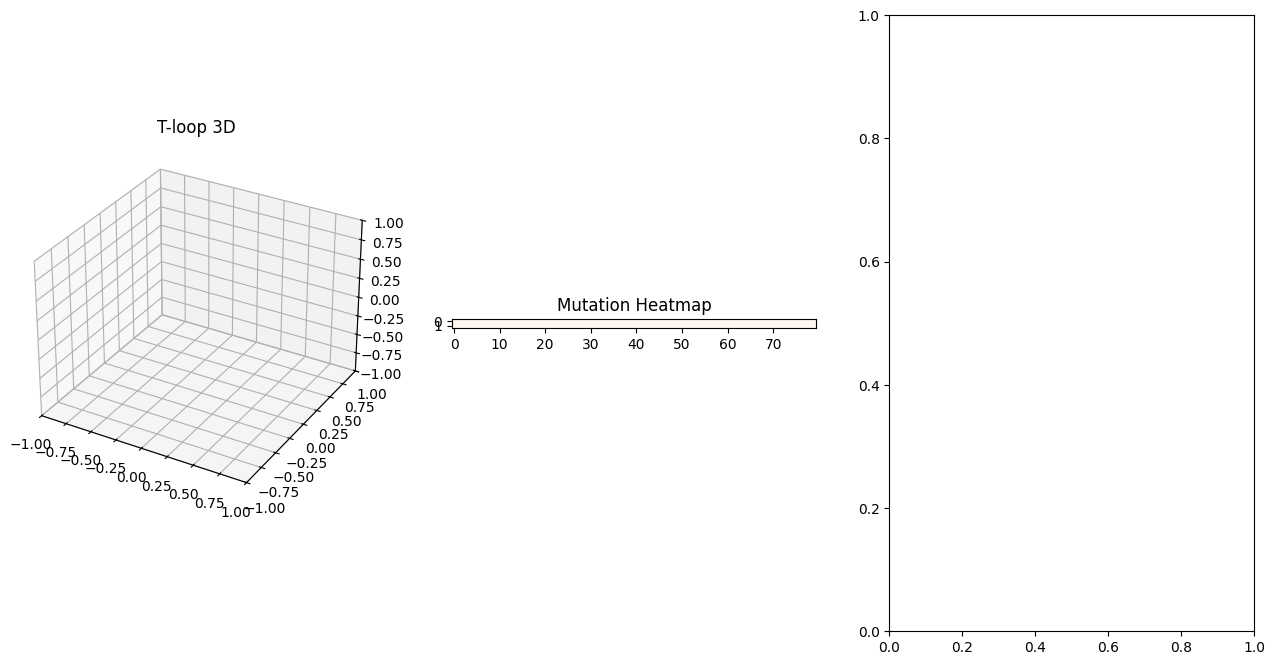

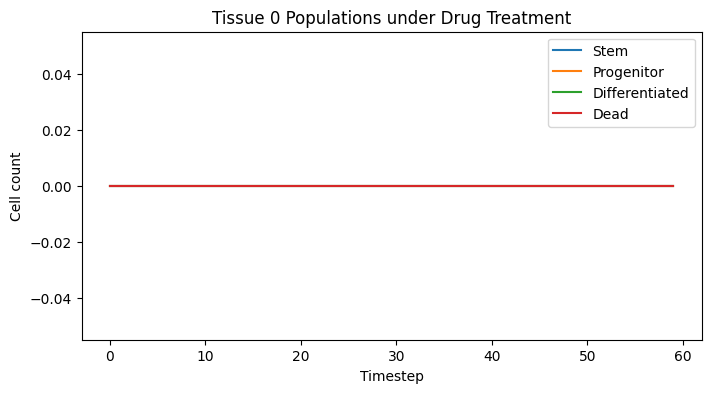

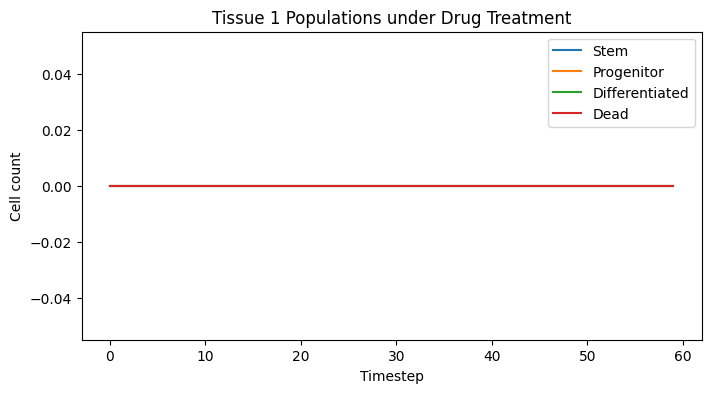

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

# ------------------- Device -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------- Parameters -------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

NUM_TISSUES = 2
NUM_LAYERS = 2
CELLS_PER_LAYER = 40
NUM_CELLS = NUM_TISSUES * NUM_LAYERS * CELLS_PER_LAYER
TIMESTEPS = 60

TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85

DEATH_TELOM = 6800.0
DEATH_MUTATION = 0.05
DEATH_STRESS = 0.8

ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5
ALPHA_diff = 2.0
ALPHA_vitality = 5.0
ALPHA_drug = 3.0

TLOOP_DIM = 3
OBS_DIM = 11  # includes cross-tissue signal + drug effect

# ------------------- Actor-Critic -------------------
class ActorCritic(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim,64),
            nn.GELU(),
            nn.Linear(64,64),
            nn.GELU()
        )
        self.actor_mu = nn.Linear(64,1)
        self.actor_logstd = nn.Linear(64,1)
        self.critic = nn.Linear(64,1)
    def forward(self,x):
        h = self.shared(x)
        mu = torch.sigmoid(self.actor_mu(h))
        logstd = self.actor_logstd(h)
        std = torch.exp(logstd)
        value = self.critic(h)
        return mu, std, value

policy = ActorCritic(OBS_DIM).to(device)
optimizer = optim.Adam(policy.parameters(), lr=3e-3)

# ------------------- Initialize Cells -------------------
def init_cells(num_tissues, num_layers, cells_per_layer):
    tissue_ids = torch.repeat_interleave(torch.arange(num_tissues, device=device), num_layers*cells_per_layer)
    layers = torch.tile(torch.arange(num_layers, device=device), (num_tissues, cells_per_layer)).flatten()
    types = torch.zeros(NUM_CELLS, dtype=torch.long, device=device)  # 0: stem, 1: progenitor, 2: diff
    return {
        'tel_len': torch.empty(NUM_CELLS, device=device).uniform_(TARGET_LENGTH-800, TARGET_LENGTH+800),
        'debris': torch.empty(NUM_CELLS, device=device).uniform_(0,0.5),
        'cumulative_mut': torch.zeros(NUM_CELLS, device=device),
        'stress': torch.randn(NUM_CELLS, device=device)*0.05,
        'tloop_vec': torch.randn(NUM_CELLS, TLOOP_DIM, device=device)*0.1,
        'layers': layers,
        'types': types,
        'tissues': tissue_ids,
        'alive': torch.ones(NUM_CELLS, dtype=torch.bool, device=device),
        'drug_binding': torch.zeros(NUM_CELLS, device=device)  # 0=none, 1=bound
    }

# ------------------- Drug Definition -------------------
class Drug:
    def __init__(self, target_types, effect_strength):
        self.target_types = target_types  # list of cell types [0,1,2]
        self.effect_strength = effect_strength  # modifies telomerase repair
    def bind(self, cells):
        mask = torch.zeros_like(cells['drug_binding'], dtype=torch.bool)
        for t in self.target_types:
            mask |= (cells['types']==t) & cells['alive']
        bind_chance = 0.3  # 30% chance to bind per timestep
        new_binding = (torch.rand_like(cells['drug_binding'])<bind_chance) & mask
        cells['drug_binding'][new_binding] = self.effect_strength
        # decay previous bindings
        cells['drug_binding'] *= 0.9

# ------------------- Functions -------------------
def tloop_score(tloop_vec, tel_len):
    fold_factor = torch.exp(-torch.abs(tel_len - TARGET_LENGTH)/3000.0)
    docking_eff = torch.clamp(torch.sigmoid(tloop_vec.sum(dim=1))*fold_factor, 0.0, 1.0)
    return docking_eff

def telomerase_action(base_action, tloop_score, cell_types, drug_effect):
    sensitivity = torch.tensor([1.2,1.0,0.6], device=device)
    repair = base_action * tloop_score * TELOM_REPAIR_SCALE * sensitivity[cell_types]
    repair += drug_effect  # drug modifies telomerase repair
    return repair

def mutation_risk(base, action, damage, tloop_score, drug_effect):
    risk = base + action*MUTATION_ACTION_FACTOR + damage/10000.0
    risk *= (1.0 + (1.0 - tloop_score))
    risk += drug_effect*0.05  # off-target drug stress
    return risk

def build_neighbor_matrix(num_cells, layers, tissues, k=5):
    mat = torch.zeros(num_cells, num_cells, device=device)
    for i in range(num_cells):
        same_layer = (layers==layers[i]) & (tissues==tissues[i])
        adj_layer = ((layers==layers[i]-1)|(layers==layers[i]+1)) & (tissues==tissues[i])
        neighbors = (same_layer|adj_layer).nonzero(as_tuple=True)[0]
        neighbors = neighbors[neighbors!=i]
        if len(neighbors)>k:
            neighbors = neighbors[torch.randperm(len(neighbors))[:k]]
        mat[i, neighbors] = 1.0
    mat /= mat.sum(dim=1, keepdim=True)
    return mat

def multi_cell_step(cells, actions, neighbor_matrix, cross_signal):
    alive_mask = cells['alive']
    neighbor_debris = neighbor_matrix @ cells['debris']
    neighbor_stress = neighbor_matrix @ cells['stress']
    avg_debris = cells['debris'].mean()
    damage = BASE_DAMAGE_RATE + torch.abs(torch.randn_like(cells['stress'])*STRESS_VARIANCE)*(1.0+avg_debris)
    damage += (torch.rand_like(damage)<0.01).float()*500
    tloop = tloop_score(cells['tloop_vec'], cells['tel_len'])
    repair = telomerase_action(actions, tloop, cells['types'], cells['drug_binding'])
    repair += cross_signal[cells['tissues']]*0.5
    cells['tel_len'] += repair - damage
    cells['tel_len'] = torch.clamp(cells['tel_len'], MIN_LENGTH, MAX_LENGTH)
    mut = mutation_risk(MUTATION_BASE, actions, damage, tloop, cells['drug_binding'])
    cells['cumulative_mut'] += mut
    cells['debris'] += damage*0.0005
    phago_mask = torch.rand_like(cells['debris'])<0.1
    cells['debris'][phago_mask] *= (1.0-PHAGO_CLEARANCE_EFF)
    cells['tloop_vec'] += torch.randn_like(cells['tloop_vec'])*0.01
    # ----------------- Cell Death -----------------
    death_mask = alive_mask & ((cells['tel_len']<DEATH_TELOM) |
                               (cells['cumulative_mut']>DEATH_MUTATION) |
                               (cells['stress']>DEATH_STRESS))
    cells['alive'][death_mask] = False
    cells['debris'][death_mask] += 0.05
    # ----------------- Differentiation -----------------
    diff_prob = torch.zeros_like(cells['types'], dtype=torch.float)
    diff_prob[cells['types']==0] = 0.02 + (TARGET_LENGTH - cells['tel_len'][cells['types']==0])/20000.0 + cross_signal[cells['tissues'][cells['types']==0]]*0.05
    diff_prob[cells['types']==1] = 0.01 + cross_signal[cells['tissues'][cells['types']==1]]*0.02
    rand_vals = torch.rand_like(diff_prob)
    cells['types'][(cells['types']==0) & (rand_vals<diff_prob)] = 1
    cells['types'][(cells['types']==1) & (rand_vals<diff_prob)] = 2
    # ----------------- Regeneration -----------------
    for t in range(NUM_TISSUES):
        tissue_mask = (cells['tissues']==t) & (~cells['alive'])
        if tissue_mask.sum()>0:
            stem_pool = (cells['tissues']==t) & (cells['types']==0) & (cells['alive'])
            if stem_pool.sum()>0:
                revive_idx = tissue_mask.nonzero(as_tuple=True)[0][0]
                donor_idx = stem_pool.nonzero(as_tuple=True)[0][torch.randint(0,len(stem_pool.nonzero()),(1,)).item()]
                cells['tel_len'][revive_idx] = cells['tel_len'][donor_idx].clone()
                cells['types'][revive_idx] = 0
                cells['tloop_vec'][revive_idx] = cells['tloop_vec'][donor_idx].clone()
                cells['cumulative_mut'][revive_idx] = cells['cumulative_mut'][donor_idx]*0.5
                cells['stress'][revive_idx] = 0.0
                cells['alive'][revive_idx] = True
    # ----------------- Observation & Reward -----------------
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_debris,
        neighbor_stress,
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1),
        cross_signal[cells['tissues']],
        cells['drug_binding']
    ], dim=1)
    reward_per_cell = - ALPHA_length*torch.abs(cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH) \
                      - ALPHA_mut*mut - ALPHA_action*(actions**2) \
                      - ALPHA_diff*(cells['types']==2).float()*0.01 \
                      + ALPHA_vitality*cells['alive'].float()*0.01 \
                      + ALPHA_drug*cells['drug_binding']
    return obs, reward_per_cell, cells

# ------------------- Simulation Setup -------------------
cells = init_cells(NUM_TISSUES, NUM_LAYERS, CELLS_PER_LAYER)
neighbor_matrix = build_neighbor_matrix(NUM_CELLS, cells['layers'], cells['tissues'], k=5)
cross_signal = torch.zeros(NUM_TISSUES, device=device)
drug = Drug(target_types=[0,1], effect_strength=50.0)  # affects stem & progenitor cells
pop_history = np.zeros((NUM_TISSUES, TIMESTEPS, 4)) # stem, progenitor, diff, dead

# ------------------- Animation -------------------
fig = plt.figure(figsize=(16,8))
ax3d = fig.add_subplot(131, projection='3d')
ax_mut = fig.add_subplot(132)
ax_pop = fig.add_subplot(133)
scat = ax3d.scatter([], [], [], c=[], cmap='viridis', s=[], alpha=0.7)
ax3d.set_xlim(-1,1); ax3d.set_ylim(-1,1); ax3d.set_zlim(-1,1)
ax3d.set_title("T-loop 3D")
heat_mut = ax_mut.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='Reds', vmin=0, vmax=0.05)
ax_mut.set_title("Mutation Heatmap")

def init_anim():
    scat._offsets3d = ([],[],[])
    heat_mut.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    return scat, heat_mut

def animate(frame):
    global cells, cross_signal, pop_history, drug
    # ----------------- Cross-Tissue Signals -----------------
    for t in range(NUM_TISSUES):
        cross_signal[t] = cells['stress'][cells['tissues']==t].mean()*0.1
    # ----------------- Drug Binding -----------------
    drug.bind(cells)
    # ----------------- RL Actions -----------------
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_matrix @ cells['debris'],
        neighbor_matrix @ cells['stress'],
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1),
        cross_signal[cells['tissues']],
        cells['drug_binding']
    ], dim=1)
    mu,std,value = policy(obs)
    dist = torch.distributions.Normal(mu,std)
    actions = torch.clamp(dist.sample(),0,1)
    obs, reward_per_cell, cells = multi_cell_step(cells, actions, neighbor_matrix, cross_signal)
    # ----------------- Visualization -----------------
    tloop = cells['tloop_vec'].cpu().numpy()
    colors = cells['types'].cpu().numpy()
    sizes = ((cells['tel_len']-MIN_LENGTH)/(MAX_LENGTH-MIN_LENGTH)*50+10).cpu().numpy()
    scat._offsets3d = (tloop[:,0], tloop[:,1], tloop[:,2])
    scat.set_array(colors)
    scat.set_sizes(sizes)
    ax3d.set_title(f"Timestep {frame}")
    # Mutation heatmap
    mut_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t in range(NUM_TISSUES):
        mask = (cells['tissues']==t).cpu().numpy()
        mut_map[t,:mask.sum()] = cells['cumulative_mut'][mask].cpu().numpy()
        tissue_cells = cells['tissues']==t
        pop_history[t,frame,0] = ((cells['types']==0)&cells['alive']).sum().item()
        pop_history[t,frame,1] = ((cells['types']==1)&cells['alive']).sum().item()
        pop_history[t,frame,2] = ((cells['types']==2)&cells['alive']).sum().item()
        pop_history[t,frame,3] = ((~cells['alive']) & tissue_cells).sum().item()
    heat_mut.set_data(mut_map)
    return scat, heat_mut

ani = animation.FuncAnimation(fig, animate, frames=TIMESTEPS, init_func=init_anim,
                              interval=200, blit=False, repeat=False)
plt.show()

# ------------------- Population Plots -------------------
for t in range(NUM_TISSUES):
    plt.figure(figsize=(8,4))
    plt.plot(pop_history[t,:,0], label='Stem')
    plt.plot(pop_history[t,:,1], label='Progenitor')
    plt.plot(pop_history[t,:,2], label='Differentiated')
    plt.plot(pop_history[t,:,3], label='Dead')
    plt.xlabel("Timestep")
    plt.ylabel("Cell count")
    plt.title(f"Tissue {t} Populations under Drug Treatment")
    plt.legend()
    plt.show()

Using device: cpu


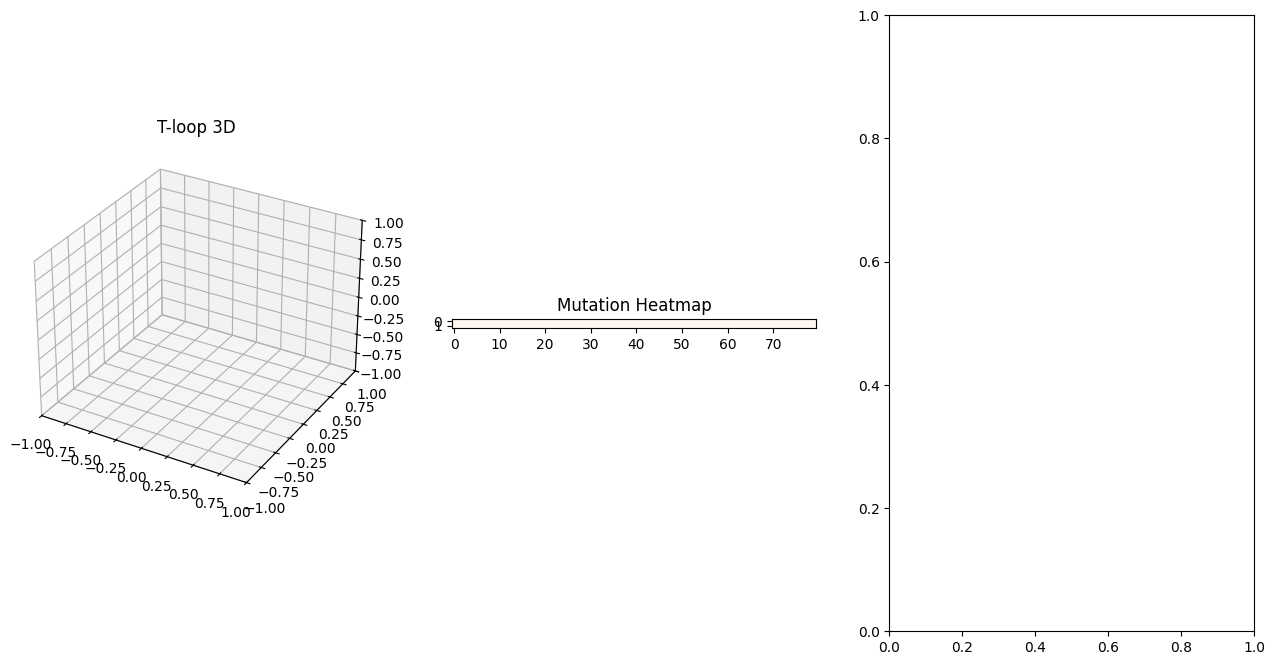

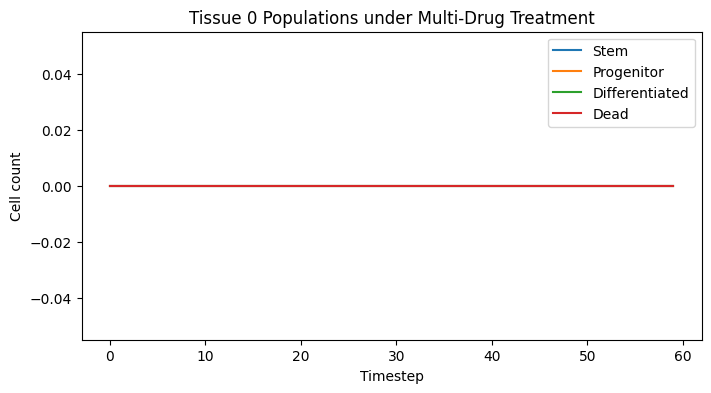

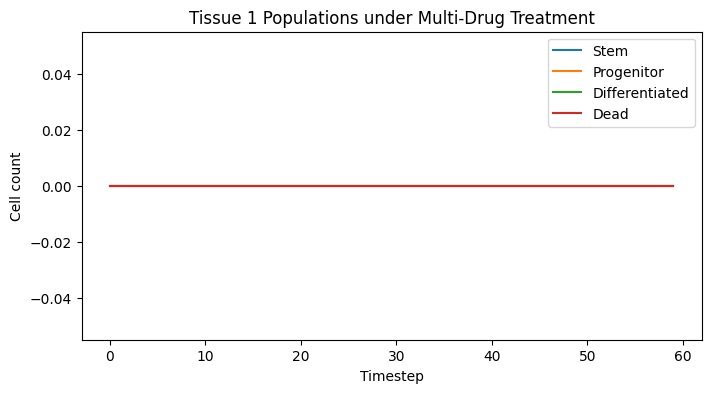

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

# ------------------- Device -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------- Parameters -------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

NUM_TISSUES = 2
NUM_LAYERS = 2
CELLS_PER_LAYER = 40
NUM_CELLS = NUM_TISSUES * NUM_LAYERS * CELLS_PER_LAYER
TIMESTEPS = 60

TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85

DEATH_TELOM = 6800.0
DEATH_MUTATION = 0.05
DEATH_STRESS = 0.8

ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5
ALPHA_diff = 2.0
ALPHA_vitality = 5.0
ALPHA_drug = 3.0

TLOOP_DIM = 3
OBS_DIM = 12  # cross-signal + sum of drug effects

# ------------------- Actor-Critic -------------------
class ActorCritic(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim,64),
            nn.GELU(),
            nn.Linear(64,64),
            nn.GELU()
        )
        self.actor_mu = nn.Linear(64,1)
        self.actor_logstd = nn.Linear(64,1)
        self.critic = nn.Linear(64,1)
    def forward(self,x):
        h = self.shared(x)
        mu = torch.sigmoid(self.actor_mu(h))
        logstd = self.actor_logstd(h)
        std = torch.exp(logstd)
        value = self.critic(h)
        return mu, std, value

policy = ActorCritic(OBS_DIM).to(device)
optimizer = optim.Adam(policy.parameters(), lr=3e-3)

# ------------------- Initialize Cells -------------------
def init_cells(num_tissues, num_layers, cells_per_layer):
    tissue_ids = torch.repeat_interleave(torch.arange(num_tissues, device=device), num_layers*cells_per_layer)
    layers = torch.tile(torch.arange(num_layers, device=device), (num_tissues, cells_per_layer)).flatten()
    types = torch.zeros(NUM_CELLS, dtype=torch.long, device=device)  # 0: stem, 1: progenitor, 2: diff
    return {
        'tel_len': torch.empty(NUM_CELLS, device=device).uniform_(TARGET_LENGTH-800, TARGET_LENGTH+800),
        'debris': torch.empty(NUM_CELLS, device=device).uniform_(0,0.5),
        'cumulative_mut': torch.zeros(NUM_CELLS, device=device),
        'stress': torch.randn(NUM_CELLS, device=device)*0.05,
        'tloop_vec': torch.randn(NUM_CELLS, TLOOP_DIM, device=device)*0.1,
        'layers': layers,
        'types': types,
        'tissues': tissue_ids,
        'alive': torch.ones(NUM_CELLS, dtype=torch.bool, device=device),
        'drug_bindings': torch.zeros((NUM_CELLS,0), device=device)  # initialized later with number of drugs
    }

# ------------------- Drug Definition -------------------
class Drug:
    def __init__(self, target_types, effect_strength, half_life, dose_schedule):
        self.target_types = target_types  # list of cell types
        self.effect_strength = effect_strength
        self.half_life = half_life  # decay per timestep
        self.dose_schedule = dose_schedule  # list of timesteps to dose
    def bind(self, cells, timestep, drug_idx):
        # apply dosing
        if timestep in self.dose_schedule:
            mask = torch.zeros(cells['types'].shape, dtype=torch.bool, device=device)
            for t in self.target_types:
                mask |= (cells['types']==t) & cells['alive']
            bind_chance = 0.3
            new_binding = (torch.rand_like(cells['drug_bindings'][:,0])<bind_chance) & mask
            cells['drug_bindings'][new_binding, drug_idx] = self.effect_strength
        # decay previous binding
        cells['drug_bindings'][:, drug_idx] *= (1.0 - 1.0/self.half_life)

# ------------------- Functions -------------------
def tloop_score(tloop_vec, tel_len):
    fold_factor = torch.exp(-torch.abs(tel_len - TARGET_LENGTH)/3000.0)
    docking_eff = torch.clamp(torch.sigmoid(tloop_vec.sum(dim=1))*fold_factor, 0.0, 1.0)
    return docking_eff

def telomerase_action(base_action, tloop_score, cell_types, total_drug_effect):
    sensitivity = torch.tensor([1.2,1.0,0.6], device=device)
    repair = base_action * tloop_score * TELOM_REPAIR_SCALE * sensitivity[cell_types]
    repair += total_drug_effect  # sum of all drug effects
    return repair

def mutation_risk(base, action, damage, tloop_score, total_drug_effect):
    risk = base + action*MUTATION_ACTION_FACTOR + damage/10000.0
    risk *= (1.0 + (1.0 - tloop_score))
    risk += total_drug_effect*0.05  # off-target stress
    return risk

def build_neighbor_matrix(num_cells, layers, tissues, k=5):
    mat = torch.zeros(num_cells, num_cells, device=device)
    for i in range(num_cells):
        same_layer = (layers==layers[i]) & (tissues==tissues[i])
        adj_layer = ((layers==layers[i]-1)|(layers==layers[i]+1)) & (tissues==tissues[i])
        neighbors = (same_layer|adj_layer).nonzero(as_tuple=True)[0]
        neighbors = neighbors[neighbors!=i]
        if len(neighbors)>k:
            neighbors = neighbors[torch.randperm(len(neighbors))[:k]]
        mat[i, neighbors] = 1.0
    mat /= mat.sum(dim=1, keepdim=True)
    return mat

def multi_cell_step(cells, actions, neighbor_matrix, cross_signal):
    alive_mask = cells['alive']
    neighbor_debris = neighbor_matrix @ cells['debris']
    neighbor_stress = neighbor_matrix @ cells['stress']
    avg_debris = cells['debris'].mean()
    damage = BASE_DAMAGE_RATE + torch.abs(torch.randn_like(cells['stress'])*STRESS_VARIANCE)*(1.0+avg_debris)
    damage += (torch.rand_like(damage)<0.01).float()*500
    tloop = tloop_score(cells['tloop_vec'], cells['tel_len'])
    total_drug_effect = cells['drug_bindings'].sum(dim=1)
    repair = telomerase_action(actions, tloop, cells['types'], total_drug_effect)
    repair += cross_signal[cells['tissues']]*0.5
    cells['tel_len'] += repair - damage
    cells['tel_len'] = torch.clamp(cells['tel_len'], MIN_LENGTH, MAX_LENGTH)
    mut = mutation_risk(MUTATION_BASE, actions, damage, tloop, total_drug_effect)
    cells['cumulative_mut'] += mut
    cells['debris'] += damage*0.0005
    phago_mask = torch.rand_like(cells['debris'])<0.1
    cells['debris'][phago_mask] *= (1.0-PHAGO_CLEARANCE_EFF)
    cells['tloop_vec'] += torch.randn_like(cells['tloop_vec'])*0.01

    # ----------------- Cell Death -----------------
    death_mask = alive_mask & ((cells['tel_len']<DEATH_TELOM) |
                               (cells['cumulative_mut']>DEATH_MUTATION) |
                               (cells['stress']>DEATH_STRESS))
    cells['alive'][death_mask] = False
    cells['debris'][death_mask] += 0.05

    # ----------------- Differentiation -----------------
    diff_prob = torch.zeros_like(cells['types'], dtype=torch.float)
    diff_prob[cells['types']==0] = 0.02 + (TARGET_LENGTH - cells['tel_len'][cells['types']==0])/20000.0 + cross_signal[cells['tissues'][cells['types']==0]]*0.05
    diff_prob[cells['types']==1] = 0.01 + cross_signal[cells['tissues'][cells['types']==1]]*0.02
    rand_vals = torch.rand_like(diff_prob)
    cells['types'][(cells['types']==0) & (rand_vals<diff_prob)] = 1
    cells['types'][(cells['types']==1) & (rand_vals<diff_prob)] = 2

    # ----------------- Regeneration -----------------
    for t in range(NUM_TISSUES):
        tissue_mask = (cells['tissues']==t) & (~cells['alive'])
        if tissue_mask.sum()>0:
            stem_pool = (cells['tissues']==t) & (cells['types']==0) & (cells['alive'])
            if stem_pool.sum()>0:
                revive_idx = tissue_mask.nonzero(as_tuple=True)[0][0]
                donor_idx = stem_pool.nonzero(as_tuple=True)[0][torch.randint(0,len(stem_pool.nonzero()),(1,)).item()]
                cells['tel_len'][revive_idx] = cells['tel_len'][donor_idx].clone()
                cells['types'][revive_idx] = 0
                cells['tloop_vec'][revive_idx] = cells['tloop_vec'][donor_idx].clone()
                cells['cumulative_mut'][revive_idx] = cells['cumulative_mut'][donor_idx]*0.5
                cells['stress'][revive_idx] = 0.0
                cells['alive'][revive_idx] = True

    # ----------------- Observation & Reward -----------------
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_debris,
        neighbor_stress,
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1),
        cross_signal[cells['tissues']],
        total_drug_effect,
        cells['drug_bindings'].mean(dim=1)
    ], dim=1)
    reward_per_cell = - ALPHA_length*torch.abs(cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH) \
                      - ALPHA_mut*mut - ALPHA_action*(actions**2) \
                      - ALPHA_diff*(cells['types']==2).float()*0.01 \
                      + ALPHA_vitality*cells['alive'].float()*0.01 \
                      + ALPHA_drug*total_drug_effect
    return obs, reward_per_cell, cells

# ------------------- Simulation Setup -------------------
cells = init_cells(NUM_TISSUES, NUM_LAYERS, CELLS_PER_LAYER)
neighbor_matrix = build_neighbor_matrix(NUM_CELLS, cells['layers'], cells['tissues'], k=5)
cross_signal = torch.zeros(NUM_TISSUES, device=device)

# Define multiple drugs
drugs = [
    Drug(target_types=[0,1], effect_strength=50.0, half_life=5, dose_schedule=[0,10,20,30,40,50]),
    Drug(target_types=[1,2], effect_strength=-30.0, half_life=10, dose_schedule=[5,15,25,35,45,55])
]
cells['drug_bindings'] = torch.zeros((NUM_CELLS,len(drugs)), device=device)

pop_history = np.zeros((NUM_TISSUES, TIMESTEPS, 4)) # stem, progenitor, diff, dead

# ------------------- Animation & Visualization -------------------
fig = plt.figure(figsize=(16,8))
ax3d = fig.add_subplot(131, projection='3d')
ax_mut = fig.add_subplot(132)
ax_pop = fig.add_subplot(133)
scat = ax3d.scatter([], [], [], c=[], cmap='viridis', s=[], alpha=0.7)
ax3d.set_xlim(-1,1); ax3d.set_ylim(-1,1); ax3d.set_zlim(-1,1)
ax3d.set_title("T-loop 3D")
heat_mut = ax_mut.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='Reds', vmin=0, vmax=0.05)
ax_mut.set_title("Mutation Heatmap")

def init_anim():
    scat._offsets3d = ([],[],[])
    heat_mut.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    return scat, heat_mut

def animate(frame):
    global cells, cross_signal, pop_history, drugs
    # ----------------- Cross-Tissue Signals -----------------
    for t in range(NUM_TISSUES):
        cross_signal[t] = cells['stress'][cells['tissues']==t].mean()*0.1
    # ----------------- Drug Binding -----------------
    for idx, d in enumerate(drugs):
        d.bind(cells, frame, idx)
    # ----------------- RL Actions -----------------
    total_drug_effect = cells['drug_bindings'].sum(dim=1)
    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_matrix @ cells['debris'],
        neighbor_matrix @ cells['stress'],
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1),
        cross_signal[cells['tissues']],
        total_drug_effect,
        cells['drug_bindings'].mean(dim=1)
    ], dim=1)
    mu,std,value = policy(obs)
    dist = torch.distributions.Normal(mu,std)
    actions = torch.clamp(dist.sample(),0,1)
    obs, reward_per_cell, cells = multi_cell_step(cells, actions, neighbor_matrix, cross_signal)
    # ----------------- Visualization -----------------
    tloop = cells['tloop_vec'].cpu().numpy()
    colors = cells['types'].cpu().numpy()
    sizes = ((cells['tel_len']-MIN_LENGTH)/(MAX_LENGTH-MIN_LENGTH)*50+10).cpu().numpy()
    scat._offsets3d = (tloop[:,0], tloop[:,1], tloop[:,2])
    scat.set_array(colors)
    scat.set_sizes(sizes)
    ax3d.set_title(f"Timestep {frame}")
    # Mutation heatmap
    mut_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t in range(NUM_TISSUES):
        mask = (cells['tissues']==t).cpu().numpy()
        mut_map[t,:mask.sum()] = cells['cumulative_mut'][mask].cpu().numpy()
        tissue_cells = cells['tissues']==t
        pop_history[t,frame,0] = ((cells['types']==0)&cells['alive']).sum().item()
        pop_history[t,frame,1] = ((cells['types']==1)&cells['alive']).sum().item()
        pop_history[t,frame,2] = ((cells['types']==2)&cells['alive']).sum().item()
        pop_history[t,frame,3] = ((~cells['alive']) & tissue_cells).sum().item()
    heat_mut.set_data(mut_map)
    return scat, heat_mut

ani = animation.FuncAnimation(fig, animate, frames=TIMESTEPS, init_func=init_anim,
                              interval=200, blit=False, repeat=False)
plt.show()

# ------------------- Population Plots -------------------
for t in range(NUM_TISSUES):
    plt.figure(figsize=(8,4))
    plt.plot(pop_history[t,:,0], label='Stem')
    plt.plot(pop_history[t,:,1], label='Progenitor')
    plt.plot(pop_history[t,:,2], label='Differentiated')
    plt.plot(pop_history[t,:,3], label='Dead')
    plt.xlabel("Timestep")
    plt.ylabel("Cell count")
    plt.title(f"Tissue {t} Populations under Multi-Drug Treatment")
    plt.legend()
    plt.show()

Using device: cpu


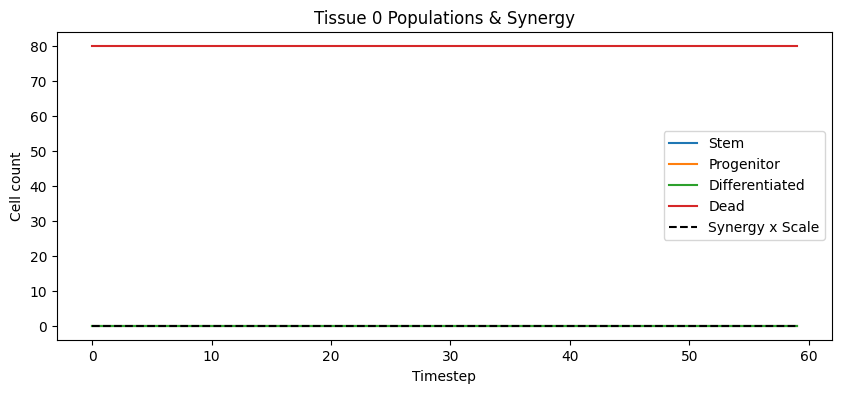

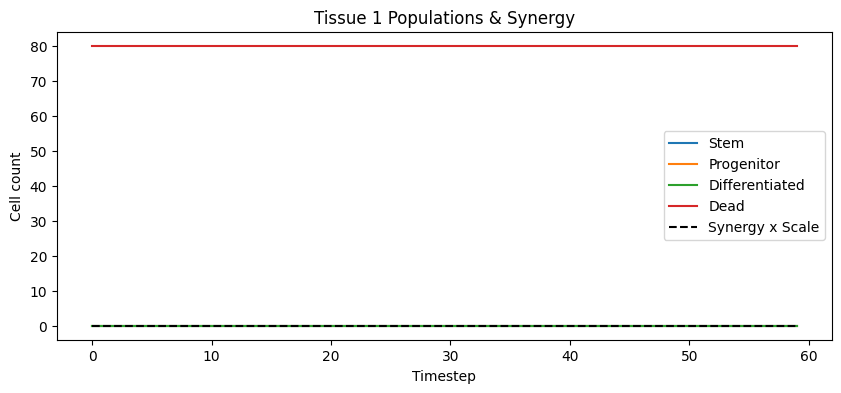

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

# ------------------- Device -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------- Parameters -------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

NUM_TISSUES = 2
NUM_LAYERS = 2
CELLS_PER_LAYER = 40
NUM_CELLS = NUM_TISSUES * NUM_LAYERS * CELLS_PER_LAYER
TIMESTEPS = 60

TARGET_LENGTH = 10000.0
MIN_LENGTH = 7000.0
MAX_LENGTH = 12000.0

BASE_DAMAGE_RATE = 0.5
STRESS_VARIANCE = 0.6
TELOM_REPAIR_SCALE = 120.0
MUTATION_BASE = 0.001
MUTATION_ACTION_FACTOR = 0.8
PHAGO_CLEARANCE_EFF = 0.85

DEATH_TELOM = 6800.0
DEATH_MUTATION = 0.05
DEATH_STRESS = 0.8

ALPHA_length = 1.0
ALPHA_mut = 2000.0
ALPHA_action = 0.5
ALPHA_diff = 2.0
ALPHA_vitality = 5.0
ALPHA_drug = 3.0
ALPHA_synergy = 5.0

TLOOP_DIM = 3
NUM_DRUGS = 2
OBS_DIM = 13  # includes total_drug_effect + synergy

# ------------------- Actor-Critic -------------------
class ActorCritic(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim,64),
            nn.GELU(),
            nn.Linear(64,64),
            nn.GELU()
        )
        self.actor_mu = nn.Linear(64,NUM_DRUGS)  # drug dosing actions
        self.actor_logstd = nn.Linear(64,NUM_DRUGS)
        self.critic = nn.Linear(64,1)
    def forward(self,x):
        h = self.shared(x)
        mu = torch.sigmoid(self.actor_mu(h))
        logstd = self.actor_logstd(h)
        std = torch.exp(logstd)
        value = self.critic(h)
        return mu, std, value

policy = ActorCritic(OBS_DIM).to(device)
optimizer = optim.Adam(policy.parameters(), lr=3e-3)

# ------------------- Initialize Cells -------------------
def init_cells(num_tissues, num_layers, cells_per_layer):
    tissue_ids = torch.repeat_interleave(torch.arange(num_tissues, device=device), num_layers*cells_per_layer)
    layers = torch.tile(torch.arange(num_layers, device=device), (num_tissues, cells_per_layer)).flatten()
    types = torch.zeros(NUM_CELLS, dtype=torch.long, device=device)  # 0: stem, 1: progenitor, 2: diff
    return {
        'tel_len': torch.empty(NUM_CELLS, device=device).uniform_(TARGET_LENGTH-800, TARGET_LENGTH+800),
        'debris': torch.empty(NUM_CELLS, device=device).uniform_(0,0.5),
        'cumulative_mut': torch.zeros(NUM_CELLS, device=device),
        'stress': torch.randn(NUM_CELLS, device=device)*0.05,
        'tloop_vec': torch.randn(NUM_CELLS, TLOOP_DIM, device=device)*0.1,
        'layers': layers,
        'types': types,
        'tissues': tissue_ids,
        'alive': torch.ones(NUM_CELLS, dtype=torch.bool, device=device),
        'drug_bindings': torch.zeros((NUM_CELLS,NUM_DRUGS), device=device)
    }

# ------------------- Drug Definition -------------------
class Drug:
    def __init__(self, target_types, effect_strength, half_life, dose_schedule):
        self.target_types = target_types
        self.effect_strength = effect_strength
        self.half_life = half_life
        self.dose_schedule = dose_schedule
    def bind(self, cells, dose_actions, drug_idx):
        mask = torch.zeros(cells['types'].shape, dtype=torch.bool, device=device)
        for t in self.target_types:
            mask |= (cells['types']==t) & cells['alive']
        # adaptive dosing using AI action
        dose = dose_actions[drug_idx]
        cells['drug_bindings'][mask, drug_idx] = dose * self.effect_strength + cells['drug_bindings'][mask, drug_idx]
        # decay previous binding
        cells['drug_bindings'][:, drug_idx] *= (1.0 - 1.0/self.half_life)

# ------------------- Helper Functions -------------------
def tloop_score(tloop_vec, tel_len):
    fold_factor = torch.exp(-torch.abs(tel_len - TARGET_LENGTH)/3000.0)
    docking_eff = torch.clamp(torch.sigmoid(tloop_vec.sum(dim=1))*fold_factor, 0.0, 1.0)
    return docking_eff

def telomerase_action(base_action, tloop_score, cell_types, total_drug_effect):
    sensitivity = torch.tensor([1.2,1.0,0.6], device=device)
    repair = base_action * tloop_score * TELOM_REPAIR_SCALE * sensitivity[cell_types]
    repair += total_drug_effect
    return repair

def mutation_risk(base, action, damage, tloop_score, total_drug_effect):
    risk = base + action*MUTATION_ACTION_FACTOR + damage/10000.0
    risk *= (1.0 + (1.0 - tloop_score))
    risk += total_drug_effect*0.05
    return risk

def build_neighbor_matrix(num_cells, layers, tissues, k=5):
    mat = torch.zeros(num_cells, num_cells, device=device)
    for i in range(num_cells):
        same_layer = (layers==layers[i]) & (tissues==tissues[i])
        adj_layer = ((layers==layers[i]-1)|(layers==layers[i]+1)) & (tissues==tissues[i])
        neighbors = (same_layer|adj_layer).nonzero(as_tuple=True)[0]
        neighbors = neighbors[neighbors!=i]
        if len(neighbors)>k:
            neighbors = neighbors[torch.randperm(len(neighbors))[:k]]
        mat[i, neighbors] = 1.0
    mat /= mat.sum(dim=1, keepdim=True)
    return mat

# ------------------- Multi-Cell Step with Synergy -------------------
def multi_cell_step(cells, dose_actions, neighbor_matrix, cross_signal, drugs):
    alive_mask = cells['alive']
    neighbor_debris = neighbor_matrix @ cells['debris']
    neighbor_stress = neighbor_matrix @ cells['stress']
    avg_debris = cells['debris'].mean()
    damage = BASE_DAMAGE_RATE + torch.abs(torch.randn_like(cells['stress'])*STRESS_VARIANCE)*(1.0+avg_debris)
    damage += (torch.rand_like(damage)<0.01).float()*500
    tloop = tloop_score(cells['tloop_vec'], cells['tel_len'])

    # ---------------- Drug Binding ----------------
    for idx, d in enumerate(drugs):
        d.bind(cells, dose_actions, idx)
    total_drug_effect = cells['drug_bindings'].sum(dim=1)

    repair = telomerase_action(dose_actions.sum(), tloop, cells['types'], total_drug_effect)
    repair += cross_signal[cells['tissues']]*0.5
    cells['tel_len'] += repair - damage
    cells['tel_len'] = torch.clamp(cells['tel_len'], MIN_LENGTH, MAX_LENGTH)

    mut = mutation_risk(MUTATION_BASE, dose_actions.sum(), damage, tloop, total_drug_effect)
    cells['cumulative_mut'] += mut
    cells['debris'] += damage*0.0005
    phago_mask = torch.rand_like(cells['debris'])<0.1
    cells['debris'][phago_mask] *= (1.0-PHAGO_CLEARANCE_EFF)
    cells['tloop_vec'] += torch.randn_like(cells['tloop_vec'])*0.01

    # ---------------- Cell Death ----------------
    death_mask = alive_mask & ((cells['tel_len']<DEATH_TELOM) |
                               (cells['cumulative_mut']>DEATH_MUTATION) |
                               (cells['stress']>DEATH_STRESS))
    cells['alive'][death_mask] = False
    cells['debris'][death_mask] += 0.05

    # ---------------- Differentiation ----------------
    diff_prob = torch.zeros_like(cells['types'], dtype=torch.float)
    diff_prob[cells['types']==0] = 0.02 + (TARGET_LENGTH - cells['tel_len'][cells['types']==0])/20000.0 + cross_signal[cells['tissues'][cells['types']==0]]*0.05
    diff_prob[cells['types']==1] = 0.01 + cross_signal[cells['tissues'][cells['types']==1]]*0.02
    rand_vals = torch.rand_like(diff_prob)
    cells['types'][(cells['types']==0) & (rand_vals<diff_prob)] = 1
    cells['types'][(cells['types']==1) & (rand_vals<diff_prob)] = 2

    # ---------------- Regeneration ----------------
    for t in range(NUM_TISSUES):
        tissue_mask = (cells['tissues']==t) & (~cells['alive'])
        if tissue_mask.sum()>0:
            stem_pool = (cells['tissues']==t) & (cells['types']==0) & (cells['alive'])
            if stem_pool.sum()>0:
                revive_idx = tissue_mask.nonzero(as_tuple=True)[0][0]
                donor_idx = stem_pool.nonzero(as_tuple=True)[0][torch.randint(0,len(stem_pool.nonzero()),(1,)).item()]
                cells['tel_len'][revive_idx] = cells['tel_len'][donor_idx].clone()
                cells['types'][revive_idx] = 0
                cells['tloop_vec'][revive_idx] = cells['tloop_vec'][donor_idx].clone()
                cells['cumulative_mut'][revive_idx] = cells['cumulative_mut'][donor_idx]*0.5
                cells['stress'][revive_idx] = 0.0
                cells['alive'][revive_idx] = True

    # ---------------- Synergy Score ----------------
    synergy = torch.zeros(NUM_TISSUES, device=device)
    for t in range(NUM_TISSUES):
        tissue_mask = (cells['tissues']==t) & (cells['alive'])
        if tissue_mask.sum()>0:
            mean_tel = cells['tel_len'][tissue_mask].mean()
            mean_mut = cells['cumulative_mut'][tissue_mask].mean()
            synergy[t] = 2.0*(mean_tel/TARGET_LENGTH) - 1.0*mean_mut*1000.0
            synergy[t] = torch.clamp(synergy[t], -1.0, 1.0)

    obs = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_debris,
        neighbor_stress,
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1),
        cross_signal[cells['tissues']],
        total_drug_effect,
        cells['drug_bindings'].mean(dim=1),
        synergy[cells['tissues']]
    ], dim=1)

    reward_per_cell = - ALPHA_length*torch.abs(cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH) \
                      - ALPHA_mut*mut \
                      - ALPHA_action*(dose_actions.sum()) \
                      - ALPHA_diff*(cells['types']==2).float()*0.01 \
                      + ALPHA_vitality*cells['alive'].float()*0.01 \
                      + ALPHA_synergy*synergy[cells['tissues']]
    return obs, reward_per_cell, cells, synergy

# ------------------- Simulation Setup -------------------
cells = init_cells(NUM_TISSUES, NUM_LAYERS, CELLS_PER_LAYER)
neighbor_matrix = build_neighbor_matrix(NUM_CELLS, cells['layers'], cells['tissues'], k=5)
cross_signal = torch.zeros(NUM_TISSUES, device=device)

# Define drugs
drugs = [
    Drug(target_types=[0,1], effect_strength=50.0, half_life=5, dose_schedule=[]),
    Drug(target_types=[1,2], effect_strength=-30.0, half_life=10, dose_schedule=[])
]

pop_history = np.zeros((NUM_TISSUES, TIMESTEPS, 4))
synergy_history = np.zeros((NUM_TISSUES, TIMESTEPS))

# ------------------- Simulation Loop -------------------
for t in range(TIMESTEPS):
    # cross-tissue signal
    for i in range(NUM_TISSUES):
        cross_signal[i] = cells['stress'][cells['tissues']==i].mean()*0.1
    # RL-based dosing
    obs_sample = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_matrix @ cells['debris'],
        neighbor_matrix @ cells['stress'],
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1),
        cross_signal[cells['tissues']],
        cells['drug_bindings'].sum(dim=1),
        cells['drug_bindings'].mean(dim=1),
        torch.zeros(NUM_CELLS, device=device)  # placeholder synergy
    ], dim=1)
    mu,std,value = policy(obs_sample)
    dist = torch.distributions.Normal(mu,std)
    dose_actions = torch.clamp(dist.sample().mean(dim=0),0,1)  # average across cells
    obs, reward, cells, synergy = multi_cell_step(cells, dose_actions, neighbor_matrix, cross_signal, drugs)
    for i in range(NUM_TISSUES):
        tissue_mask = (cells['tissues']==i)
        pop_history[i,t,0] = ((cells['types']==0)&cells['alive']).sum().item()
        pop_history[i,t,1] = ((cells['types']==1)&cells['alive']).sum().item()
        pop_history[i,t,2] = ((cells['types']==2)&cells['alive']).sum().item()
        pop_history[i,t,3] = ((~cells['alive']) & tissue_mask).sum().item()
        synergy_history[i,t] = synergy[i].item()

# ------------------- Population & Synergy Plots -------------------
for t in range(NUM_TISSUES):
    plt.figure(figsize=(10,4))
    plt.plot(pop_history[t,:,0], label='Stem')
    plt.plot(pop_history[t,:,1], label='Progenitor')
    plt.plot(pop_history[t,:,2], label='Differentiated')
    plt.plot(pop_history[t,:,3], label='Dead')
    plt.plot(synergy_history[t,:]*pop_history[t,:,:].sum(axis=1).max(), label='Synergy x Scale', linestyle='--', color='k')
    plt.xlabel("Timestep")
    plt.ylabel("Cell count")
    plt.title(f"Tissue {t} Populations & Synergy")
    plt.legend()
    plt.show()

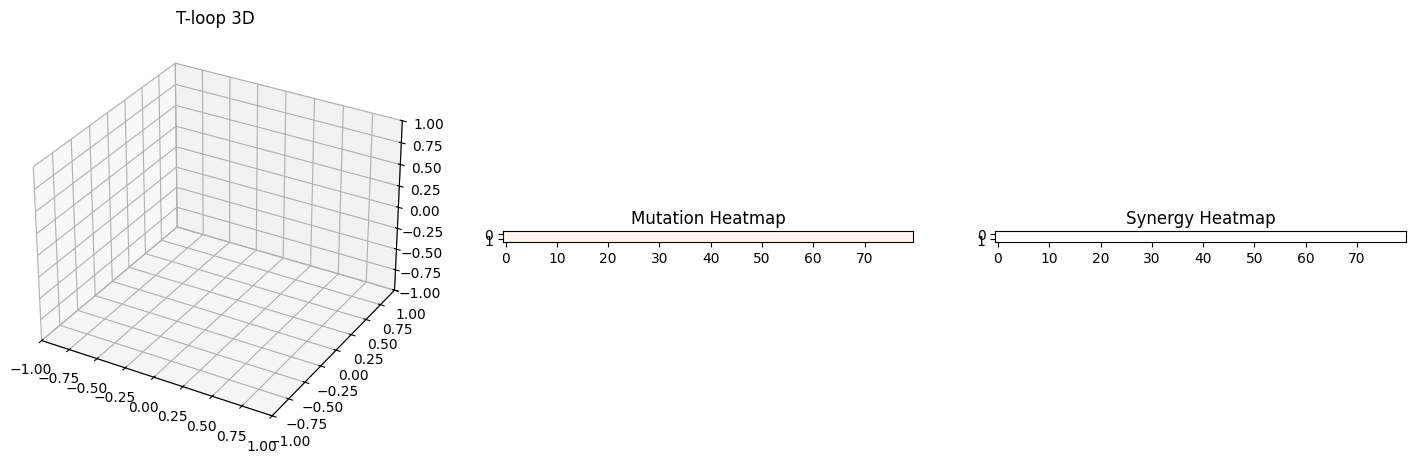

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# ------------------- Setup 3D Animation -------------------
fig = plt.figure(figsize=(18,6))
ax3d = fig.add_subplot(131, projection='3d')
ax_mut = fig.add_subplot(132)
ax_synergy = fig.add_subplot(133)

ax3d.set_xlim(-1,1); ax3d.set_ylim(-1,1); ax3d.set_zlim(-1,1)
ax3d.set_title("T-loop 3D")
ax_mut.set_title("Mutation Heatmap")
ax_synergy.set_title("Synergy Heatmap")

scat3d = ax3d.scatter([],[],[],c=[], cmap='viridis', s=[], alpha=0.7)
mut_heat = ax_mut.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='Reds', vmin=0, vmax=0.05)
syn_heat = ax_synergy.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='bwr', vmin=-1, vmax=1)

# ------------------- Animation Functions -------------------
def init_anim():
    scat3d._offsets3d = ([],[],[])
    mut_heat.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    syn_heat.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    return scat3d, mut_heat, syn_heat

def animate(frame):
    global cells, drugs, neighbor_matrix, cross_signal
    # ---------------- Cross-Tissue Signal ----------------
    for t in range(NUM_TISSUES):
        cross_signal[t] = cells['stress'][cells['tissues']==t].mean()*0.1
    # RL-based dosing
    obs_sample = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_matrix @ cells['debris'],
        neighbor_matrix @ cells['stress'],
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1),
        cross_signal[cells['tissues']],
        cells['drug_bindings'].sum(dim=1),
        cells['drug_bindings'].mean(dim=1),
        torch.zeros(NUM_CELLS, device=device)
    ], dim=1)
    mu,std,value = policy(obs_sample)
    dist = torch.distributions.Normal(mu,std)
    dose_actions = torch.clamp(dist.sample().mean(dim=0),0,1)
    obs, reward, cells, synergy = multi_cell_step(cells, dose_actions, neighbor_matrix, cross_signal, drugs)

    # ---------------- 3D T-loop ----------------
    tloop = cells['tloop_vec'].cpu().numpy()
    colors = cells['types'].cpu().numpy()
    sizes = ((cells['tel_len']-MIN_LENGTH)/(MAX_LENGTH-MIN_LENGTH)*50+10).cpu().numpy()
    scat3d._offsets3d = (tloop[:,0], tloop[:,1], tloop[:,2])
    scat3d.set_array(colors)
    scat3d.set_sizes(sizes)
    ax3d.set_title(f"T-loop 3D - Timestep {frame}")

    # ---------------- Mutation Heatmap ----------------
    mut_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t_idx in range(NUM_TISSUES):
        mask = (cells['tissues']==t_idx).cpu().numpy()
        mut_map[t_idx,:mask.sum()] = cells['cumulative_mut'][mask].cpu().numpy()
    mut_heat.set_data(mut_map)

    # ---------------- Synergy Heatmap ----------------
    syn_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t_idx in range(NUM_TISSUES):
        mask = (cells['tissues']==t_idx).cpu().numpy()
        syn_map[t_idx,:mask.sum()] = synergy[t_idx].cpu().numpy()
    syn_heat.set_data(syn_map)

    return scat3d, mut_heat, syn_heat

# ------------------- Run Animation -------------------
ani = animation.FuncAnimation(fig, animate, frames=TIMESTEPS, init_func=init_anim,
                              interval=200, blit=False, repeat=False)
plt.show()

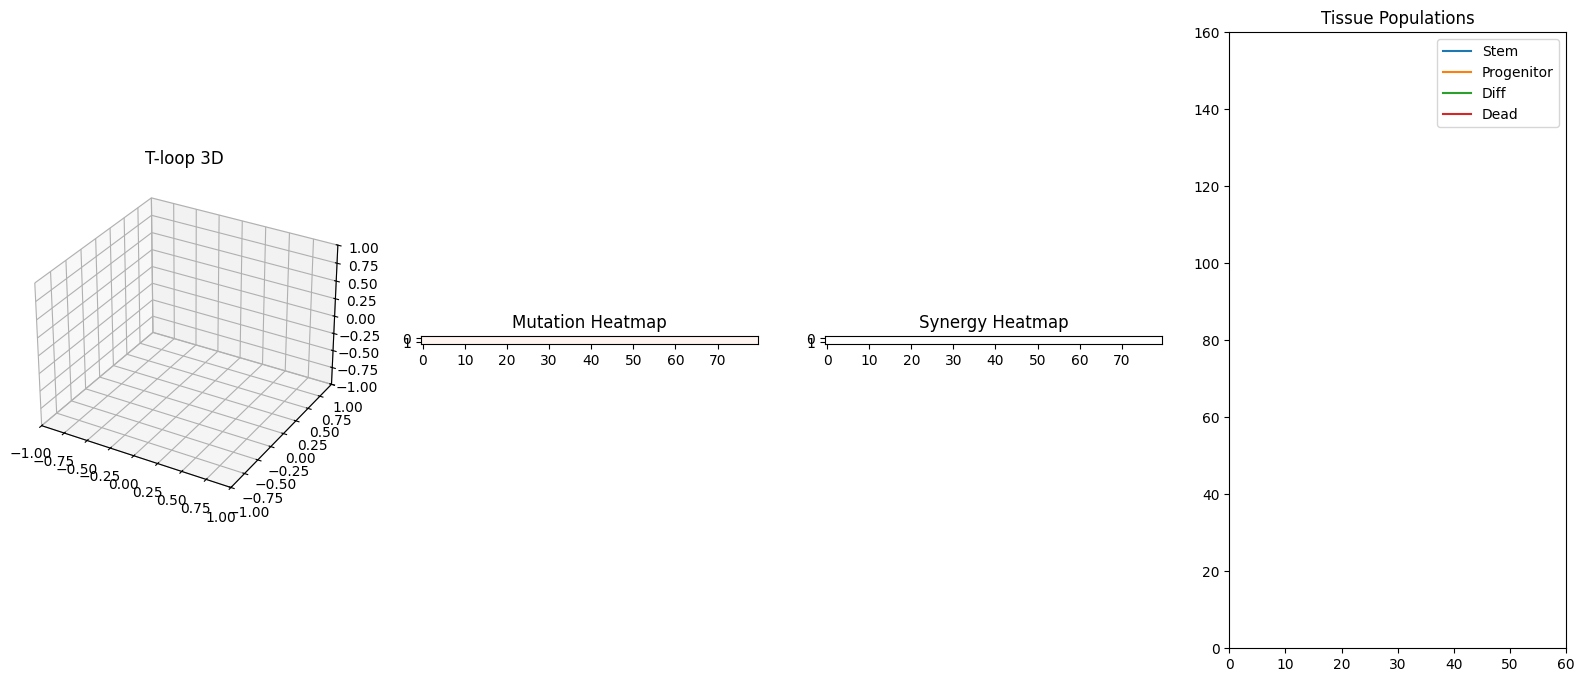

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# ------------------- Setup Figures -------------------
fig = plt.figure(figsize=(20,8))
ax3d = fig.add_subplot(141, projection='3d')
ax_mut = fig.add_subplot(142)
ax_syn = fig.add_subplot(143)
ax_pop = fig.add_subplot(144)

ax3d.set_xlim(-1,1); ax3d.set_ylim(-1,1); ax3d.set_zlim(-1,1)
ax3d.set_title("T-loop 3D")
ax_mut.set_title("Mutation Heatmap")
ax_syn.set_title("Synergy Heatmap")
ax_pop.set_title("Tissue Populations")

scat3d = ax3d.scatter([],[],[],c=[], cmap='viridis', s=[], alpha=0.7)
mut_heat = ax_mut.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='Reds', vmin=0, vmax=0.05)
syn_heat = ax_syn.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='bwr', vmin=-1, vmax=1)
pop_lines = [ax_pop.plot([],[],label=label)[0] for label in ['Stem','Progenitor','Diff','Dead']]

ax_pop.set_xlim(0,TIMESTEPS)
ax_pop.set_ylim(0,CELLS_PER_LAYER*NUM_LAYERS*NUM_TISSUES)
ax_pop.legend()

# ------------------- Animation Functions -------------------
def init_anim():
    scat3d._offsets3d = ([],[],[])
    mut_heat.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    syn_heat.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    for line in pop_lines:
        line.set_data([],[])
    return scat3d, mut_heat, syn_heat, *pop_lines

def animate(frame):
    global cells, drugs, neighbor_matrix, cross_signal, pop_history
    # Cross-tissue signal
    for t in range(NUM_TISSUES):
        cross_signal[t] = cells['stress'][cells['tissues']==t].mean()*0.1
    # RL-based dosing
    obs_sample = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_matrix @ cells['debris'],
        neighbor_matrix @ cells['stress'],
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1),
        cross_signal[cells['tissues']],
        cells['drug_bindings'].sum(dim=1),
        cells['drug_bindings'].mean(dim=1),
        torch.zeros(NUM_CELLS, device=device)
    ], dim=1)
    mu,std,value = policy(obs_sample)
    dist = torch.distributions.Normal(mu,std)
    dose_actions = torch.clamp(dist.sample().mean(dim=0),0,1)
    obs, reward, cells, synergy = multi_cell_step(cells, dose_actions, neighbor_matrix, cross_signal, drugs)

    # ---------------- 3D T-loop ----------------
    tloop = cells['tloop_vec'].cpu().numpy()
    colors = cells['types'].cpu().numpy()
    sizes = ((cells['tel_len']-MIN_LENGTH)/(MAX_LENGTH-MIN_LENGTH)*50+10).cpu().numpy()
    scat3d._offsets3d = (tloop[:,0], tloop[:,1], tloop[:,2])
    scat3d.set_array(colors)
    scat3d.set_sizes(sizes)
    ax3d.set_title(f"T-loop 3D - Timestep {frame}")

    # ---------------- Mutation Heatmap ----------------
    mut_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t_idx in range(NUM_TISSUES):
        mask = (cells['tissues']==t_idx).cpu().numpy()
        mut_map[t_idx,:mask.sum()] = cells['cumulative_mut'][mask].cpu().numpy()
    mut_heat.set_data(mut_map)

    # ---------------- Synergy Heatmap ----------------
    syn_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t_idx in range(NUM_TISSUES):
        mask = (cells['tissues']==t_idx).cpu().numpy()
        syn_map[t_idx,:mask.sum()] = synergy[t_idx].cpu().numpy()
    syn_heat.set_data(syn_map)

    # ---------------- Population Plot ----------------
    for t_idx in range(NUM_TISSUES):
        tissue_mask = (cells['tissues']==t_idx)
        pop_history[t_idx,frame,0] = ((cells['types']==0)&cells['alive']).sum().item()
        pop_history[t_idx,frame,1] = ((cells['types']==1)&cells['alive']).sum().item()
        pop_history[t_idx,frame,2] = ((cells['types']==2)&cells['alive']).sum().item()
        pop_history[t_idx,frame,3] = ((~cells['alive']) & tissue_mask).sum().item()
    # update lines
    for idx, line in enumerate(pop_lines):
        line.set_data(np.arange(frame+1), pop_history[0,:frame+1,idx]+pop_history[1,:frame+1,idx])
    return scat3d, mut_heat, syn_heat, *pop_lines

# ------------------- Run Animation -------------------
ani = animation.FuncAnimation(fig, animate, frames=TIMESTEPS, init_func=init_anim,
                              interval=200, blit=False, repeat=False)
plt.show()

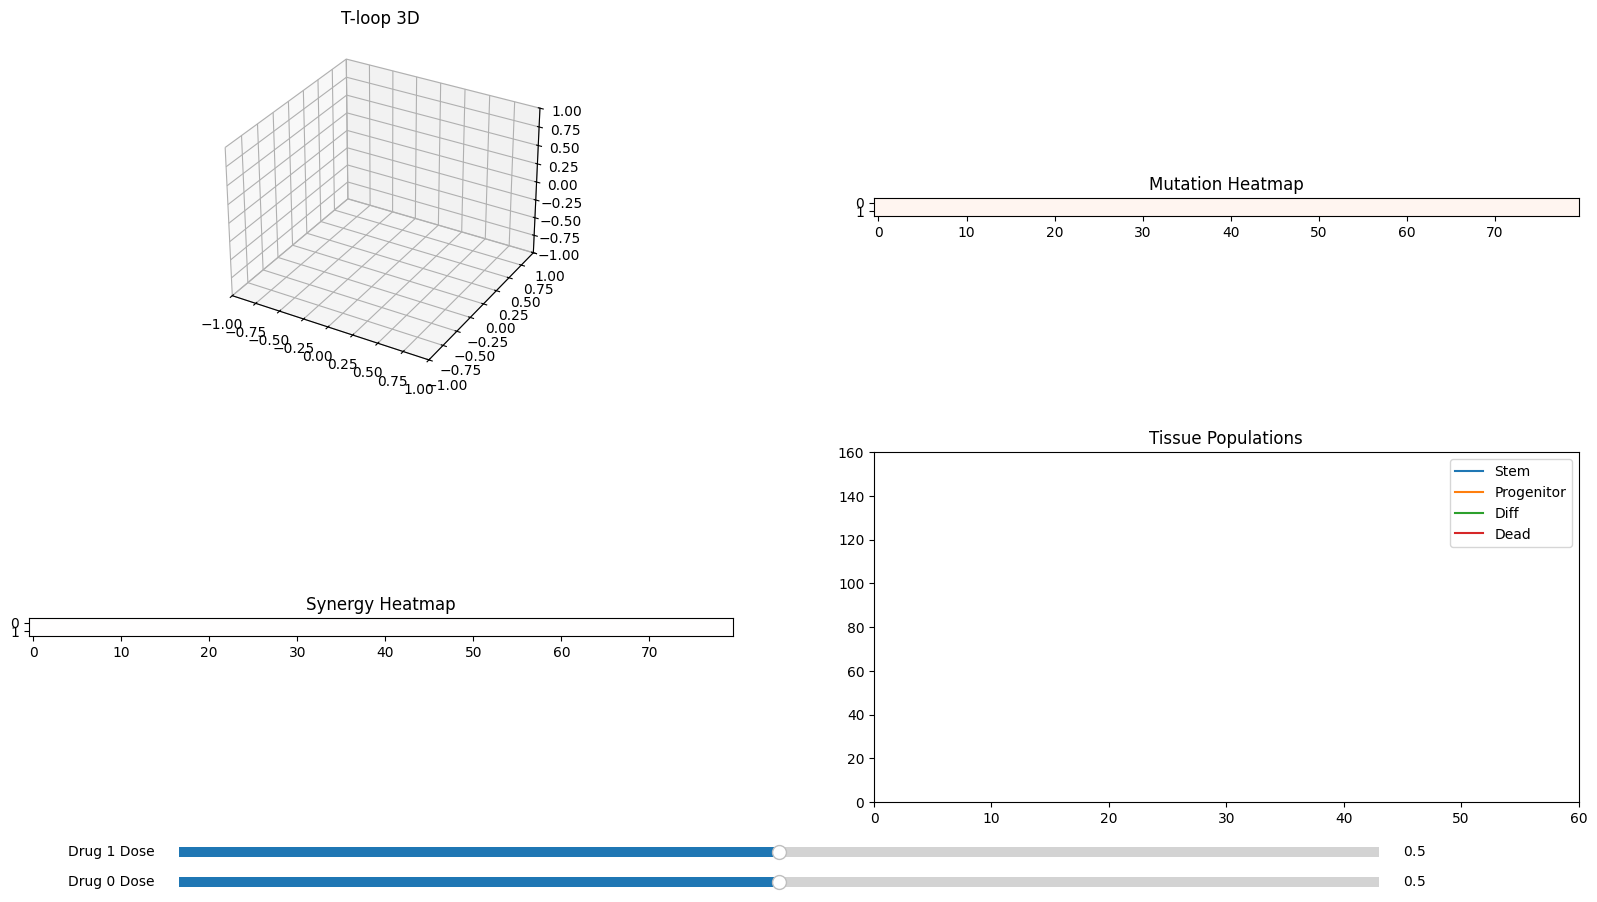

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# ------------------- Setup Figures -------------------
fig = plt.figure(figsize=(20,10))
ax3d = fig.add_subplot(221, projection='3d')
ax_mut = fig.add_subplot(222)
ax_syn = fig.add_subplot(223)
ax_pop = fig.add_subplot(224)

ax3d.set_xlim(-1,1); ax3d.set_ylim(-1,1); ax3d.set_zlim(-1,1)
ax3d.set_title("T-loop 3D")
ax_mut.set_title("Mutation Heatmap")
ax_syn.set_title("Synergy Heatmap")
ax_pop.set_title("Tissue Populations")

scat3d = ax3d.scatter([],[],[],c=[], cmap='viridis', s=[], alpha=0.7)
mut_heat = ax_mut.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='Reds', vmin=0, vmax=0.05)
syn_heat = ax_syn.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='bwr', vmin=-1, vmax=1)
pop_lines = [ax_pop.plot([],[],label=label)[0] for label in ['Stem','Progenitor','Diff','Dead']]
ax_pop.set_xlim(0,TIMESTEPS)
ax_pop.set_ylim(0,CELLS_PER_LAYER*NUM_LAYERS*NUM_TISSUES)
ax_pop.legend()

# ------------------- Sliders for Drug Doses -------------------
axcolor = 'lightgoldenrodyellow'
slider_axes = [fig.add_axes([0.2,0.02+i*0.03,0.6,0.02], facecolor=axcolor) for i in range(NUM_DRUGS)]
sliders = [Slider(ax, f'Drug {i} Dose', 0.0, 1.0, valinit=0.5) for i, ax in enumerate(slider_axes)]

# ------------------- Animation Setup -------------------
def init_anim():
    scat3d._offsets3d = ([],[],[])
    mut_heat.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    syn_heat.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    for line in pop_lines:
        line.set_data([],[])
    return scat3d, mut_heat, syn_heat, *pop_lines

def animate(frame):
    global cells, neighbor_matrix, cross_signal, pop_history
    # Read slider values
    dose_actions = torch.tensor([s.val for s in sliders], device=device)

    # Cross-tissue signal
    for t in range(NUM_TISSUES):
        cross_signal[t] = cells['stress'][cells['tissues']==t].mean()*0.1

    # Multi-cell step with current drug doses
    obs, reward, cells, synergy = multi_cell_step(cells, dose_actions, neighbor_matrix, cross_signal, drugs)

    # ---------------- 3D T-loop ----------------
    tloop = cells['tloop_vec'].cpu().numpy()
    colors = cells['types'].cpu().numpy()
    sizes = ((cells['tel_len']-MIN_LENGTH)/(MAX_LENGTH-MIN_LENGTH)*50+10).cpu().numpy()
    scat3d._offsets3d = (tloop[:,0], tloop[:,1], tloop[:,2])
    scat3d.set_array(colors)
    scat3d.set_sizes(sizes)
    ax3d.set_title(f"T-loop 3D - Timestep {frame}")

    # ---------------- Mutation Heatmap ----------------
    mut_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t_idx in range(NUM_TISSUES):
        mask = (cells['tissues']==t_idx).cpu().numpy()
        mut_map[t_idx,:mask.sum()] = cells['cumulative_mut'][mask].cpu().numpy()
    mut_heat.set_data(mut_map)

    # ---------------- Synergy Heatmap ----------------
    syn_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t_idx in range(NUM_TISSUES):
        mask = (cells['tissues']==t_idx).cpu().numpy()
        syn_map[t_idx,:mask.sum()] = synergy[t_idx].cpu().numpy()
    syn_heat.set_data(syn_map)

    # ---------------- Population Plot ----------------
    for t_idx in range(NUM_TISSUES):
        tissue_mask = (cells['tissues']==t_idx)
        pop_history[t_idx,frame,0] = ((cells['types']==0)&cells['alive']).sum().item()
        pop_history[t_idx,frame,1] = ((cells['types']==1)&cells['alive']).sum().item()
        pop_history[t_idx,frame,2] = ((cells['types']==2)&cells['alive']).sum().item()
        pop_history[t_idx,frame,3] = ((~cells['alive']) & tissue_mask).sum().item()
    # update lines
    for idx, line in enumerate(pop_lines):
        line.set_data(np.arange(frame+1), pop_history[0,:frame+1,idx]+pop_history[1,:frame+1,idx])

    return scat3d, mut_heat, syn_heat, *pop_lines

# ------------------- Run Interactive Animation -------------------
ani = animation.FuncAnimation(fig, animate, frames=TIMESTEPS, init_func=init_anim,
                              interval=200, blit=False, repeat=False)
plt.show()

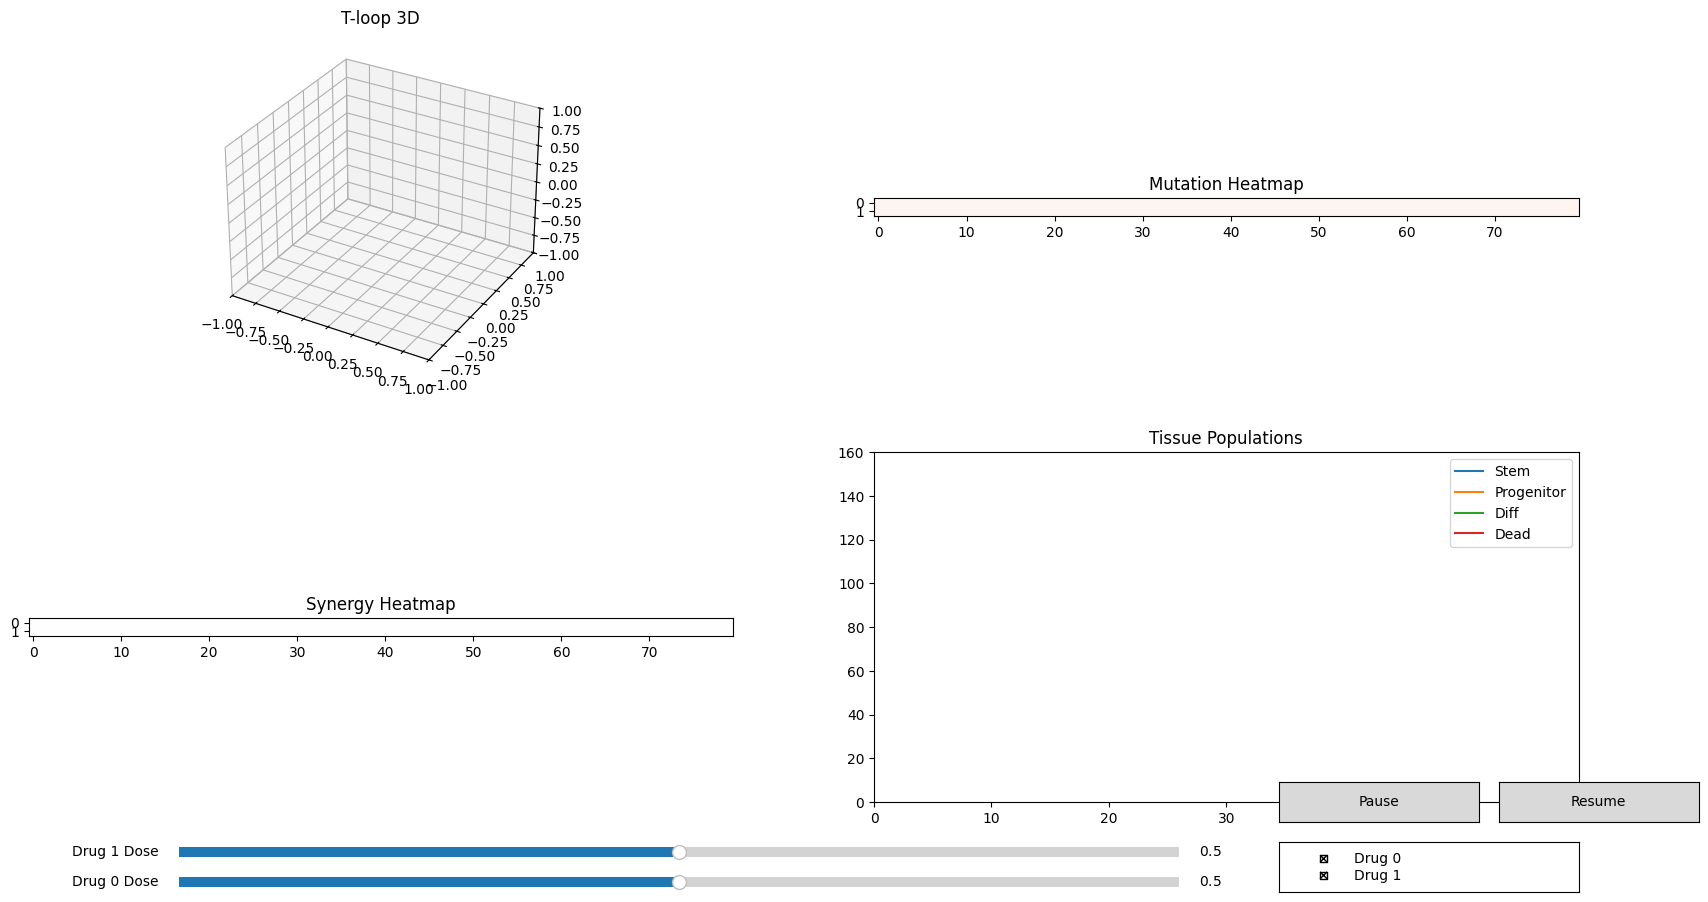

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, CheckButtons
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# ------------------- Setup Figures -------------------
fig = plt.figure(figsize=(20,10))
ax3d = fig.add_subplot(221, projection='3d')
ax_mut = fig.add_subplot(222)
ax_syn = fig.add_subplot(223)
ax_pop = fig.add_subplot(224)

ax3d.set_xlim(-1,1); ax3d.set_ylim(-1,1); ax3d.set_zlim(-1,1)
ax3d.set_title("T-loop 3D")
ax_mut.set_title("Mutation Heatmap")
ax_syn.set_title("Synergy Heatmap")
ax_pop.set_title("Tissue Populations")

scat3d = ax3d.scatter([],[],[],c=[], cmap='viridis', s=[], alpha=0.7)
mut_heat = ax_mut.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='Reds', vmin=0, vmax=0.05)
syn_heat = ax_syn.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='bwr', vmin=-1, vmax=1)
pop_lines = [ax_pop.plot([],[],label=label)[0] for label in ['Stem','Progenitor','Diff','Dead']]
ax_pop.set_xlim(0,TIMESTEPS)
ax_pop.set_ylim(0,CELLS_PER_LAYER*NUM_LAYERS*NUM_TISSUES)
ax_pop.legend()

# ------------------- Sliders for Drug Doses -------------------
axcolor = 'lightgoldenrodyellow'
slider_axes = [fig.add_axes([0.2,0.02+i*0.03,0.5,0.02], facecolor=axcolor) for i in range(NUM_DRUGS)]
sliders = [Slider(ax, f'Drug {i} Dose', 0.0, 1.0, valinit=0.5) for i, ax in enumerate(slider_axes)]

# ------------------- CheckButtons for Drug Enable/Disable -------------------
check_ax = fig.add_axes([0.75, 0.02, 0.15, 0.05])
check = CheckButtons(check_ax, [f'Drug {i}' for i in range(NUM_DRUGS)], [True]*NUM_DRUGS)
drug_active = [True]*NUM_DRUGS
def toggle_drug(label):
    idx = int(label.split()[-1])
    drug_active[idx] = not drug_active[idx]
check.on_clicked(toggle_drug)

# ------------------- Buttons for Pause/Resume -------------------
pause_ax = fig.add_axes([0.75, 0.09, 0.1, 0.04])
pause_button = Button(pause_ax, 'Pause')
resume_ax = fig.add_axes([0.86, 0.09, 0.1, 0.04])
resume_button = Button(resume_ax, 'Resume')

paused = False
def pause(event):
    global paused
    paused = True
def resume(event):
    global paused
    paused = False
pause_button.on_clicked(pause)
resume_button.on_clicked(resume)

# ------------------- Animation Setup -------------------
def init_anim():
    scat3d._offsets3d = ([],[],[])
    mut_heat.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    syn_heat.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    for line in pop_lines:
        line.set_data([],[])
    return scat3d, mut_heat, syn_heat, *pop_lines

def animate(frame):
    global cells, neighbor_matrix, cross_signal, pop_history, paused
    if paused:
        return scat3d, mut_heat, syn_heat, *pop_lines

    # Read slider values but apply only if drug is active
    dose_actions = torch.tensor([s.val if drug_active[i] else 0.0 for i,s in enumerate(sliders)], device=device)

    # Cross-tissue signal
    for t in range(NUM_TISSUES):
        cross_signal[t] = cells['stress'][cells['tissues']==t].mean()*0.1

    # Multi-cell step with current drug doses
    obs, reward, cells, synergy = multi_cell_step(cells, dose_actions, neighbor_matrix, cross_signal, drugs)

    # ---------------- 3D T-loop ----------------
    tloop = cells['tloop_vec'].cpu().numpy()
    colors = cells['types'].cpu().numpy()
    sizes = ((cells['tel_len']-MIN_LENGTH)/(MAX_LENGTH-MIN_LENGTH)*50+10).cpu().numpy()
    scat3d._offsets3d = (tloop[:,0], tloop[:,1], tloop[:,2])
    scat3d.set_array(colors)
    scat3d.set_sizes(sizes)
    ax3d.set_title(f"T-loop 3D - Timestep {frame}")

    # ---------------- Mutation Heatmap ----------------
    mut_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t_idx in range(NUM_TISSUES):
        mask = (cells['tissues']==t_idx).cpu().numpy()
        mut_map[t_idx,:mask.sum()] = cells['cumulative_mut'][mask].cpu().numpy()
    mut_heat.set_data(mut_map)

    # ---------------- Synergy Heatmap ----------------
    syn_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t_idx in range(NUM_TISSUES):
        mask = (cells['tissues']==t_idx).cpu().numpy()
        syn_map[t_idx,:mask.sum()] = synergy[t_idx].cpu().numpy()
    syn_heat.set_data(syn_map)

    # ---------------- Population Plot ----------------
    for t_idx in range(NUM_TISSUES):
        tissue_mask = (cells['tissues']==t_idx)
        pop_history[t_idx,frame,0] = ((cells['types']==0)&cells['alive']).sum().item()
        pop_history[t_idx,frame,1] = ((cells['types']==1)&cells['alive']).sum().item()
        pop_history[t_idx,frame,2] = ((cells['types']==2)&cells['alive']).sum().item()
        pop_history[t_idx,frame,3] = ((~cells['alive']) & tissue_mask).sum().item()
    # update lines
    for idx, line in enumerate(pop_lines):
        line.set_data(np.arange(frame+1), pop_history[0,:frame+1,idx]+pop_history[1,:frame+1,idx])

    return scat3d, mut_heat, syn_heat, *pop_lines

# ------------------- Run Interactive Animation -------------------
ani = animation.FuncAnimation(fig, animate, frames=TIMESTEPS, init_func=init_anim,
                              interval=200, blit=False, repeat=False)
plt.show()

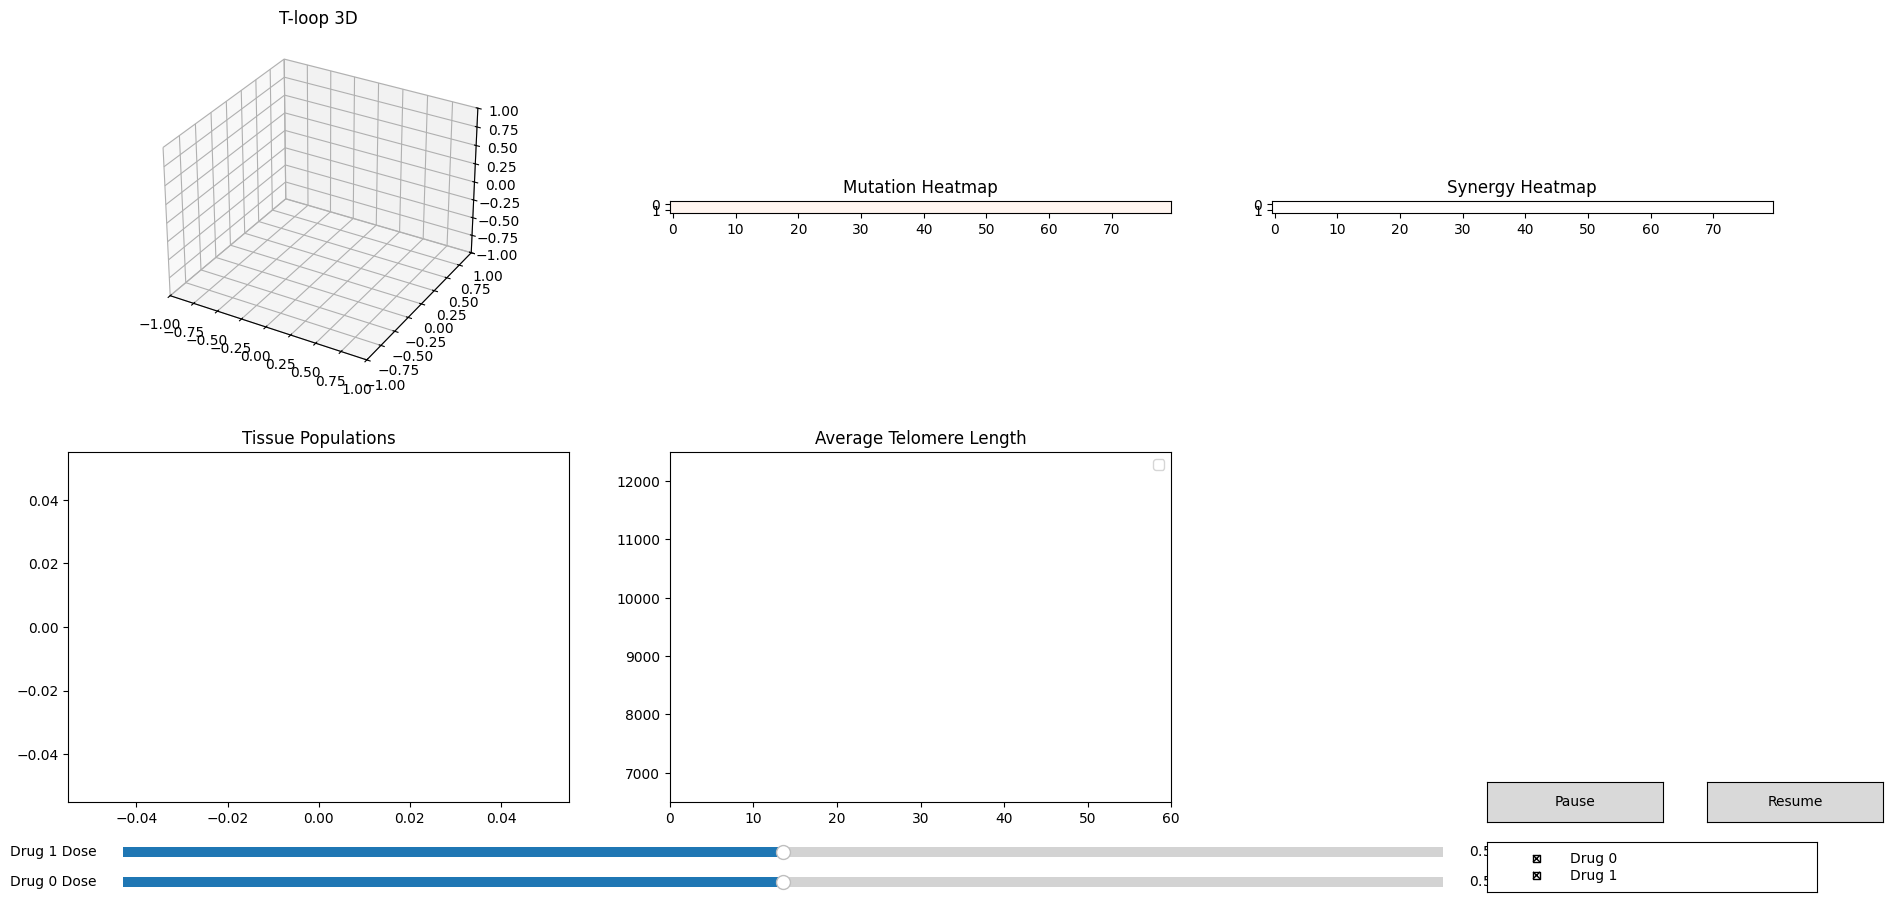

In [ ]:
# ------------------- Additional Telomere Plot -------------------
fig = plt.figure(figsize=(22,10))
ax3d = fig.add_subplot(231, projection='3d')
ax_mut = fig.add_subplot(232)
ax_syn = fig.add_subplot(233)
ax_pop = fig.add_subplot(234)
ax_tel = fig.add_subplot(235)  # New telomere plot

# ------------------- Axes setup -------------------
ax3d.set_xlim(-1,1); ax3d.set_ylim(-1,1); ax3d.set_zlim(-1,1)
ax3d.set_title("T-loop 3D")
ax_mut.set_title("Mutation Heatmap")
ax_syn.set_title("Synergy Heatmap")
ax_pop.set_title("Tissue Populations")
ax_tel.set_title("Average Telomere Length")
ax_tel.set_xlim(0,TIMESTEPS)
ax_tel.set_ylim(MIN_LENGTH-500,MAX_LENGTH+500)
ax_tel.legend([f'Tissue {t}' for t in range(NUM_TISSUES)])

# ------------------- Scatter and line objects -------------------
scat3d = ax3d.scatter([],[],[],c=[], cmap='viridis', s=[], alpha=0.7)
mut_heat = ax_mut.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='Reds', vmin=0, vmax=0.05)
syn_heat = ax_syn.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='bwr', vmin=-1, vmax=1)
pop_lines = [ax_pop.plot([],[],label=label)[0] for label in ['Stem','Progenitor','Diff','Dead']]
tel_lines = [ax_tel.plot([],[],label=f'Tissue {t}')[0] for t in range(NUM_TISSUES)]

# ------------------- Sliders and CheckButtons as before -------------------
axcolor = 'lightgoldenrodyellow'
slider_axes = [fig.add_axes([0.15,0.02+i*0.03,0.6,0.02], facecolor=axcolor) for i in range(NUM_DRUGS)]
sliders = [Slider(ax, f'Drug {i} Dose', 0.0, 1.0, valinit=0.5) for i, ax in enumerate(slider_axes)]
check_ax = fig.add_axes([0.77, 0.02, 0.15, 0.05])
check = CheckButtons(check_ax, [f'Drug {i}' for i in range(NUM_DRUGS)], [True]*NUM_DRUGS)
drug_active = [True]*NUM_DRUGS
def toggle_drug(label):
    idx = int(label.split()[-1])
    drug_active[idx] = not drug_active[idx]
check.on_clicked(toggle_drug)
pause_ax = fig.add_axes([0.77,0.09,0.08,0.04])
pause_button = Button(pause_ax, 'Pause')
resume_ax = fig.add_axes([0.87,0.09,0.08,0.04])
resume_button = Button(resume_ax, 'Resume')
paused = False
def pause(event): global paused; paused=True
def resume(event): global paused; paused=False
pause_button.on_clicked(pause)
resume_button.on_clicked(resume)

# ------------------- Animation Functions -------------------
def init_anim():
    scat3d._offsets3d = ([],[],[])
    mut_heat.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    syn_heat.set_data(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)))
    for line in pop_lines + tel_lines:
        line.set_data([],[])
    return scat3d, mut_heat, syn_heat, *pop_lines, *tel_lines

def animate(frame):
    global cells, neighbor_matrix, cross_signal, pop_history, paused
    if paused:
        return scat3d, mut_heat, syn_heat, *pop_lines, *tel_lines

    dose_actions = torch.tensor([s.val if drug_active[i] else 0.0 for i,s in enumerate(sliders)], device=device)
    for t in range(NUM_TISSUES):
        cross_signal[t] = cells['stress'][cells['tissues']==t].mean()*0.1
    obs, reward, cells, synergy = multi_cell_step(cells, dose_actions, neighbor_matrix, cross_signal, drugs)

    # 3D T-loop
    tloop = cells['tloop_vec'].cpu().numpy()
    colors = cells['types'].cpu().numpy()
    sizes = ((cells['tel_len']-MIN_LENGTH)/(MAX_LENGTH-MIN_LENGTH)*50+10).cpu().numpy()
    scat3d._offsets3d = (tloop[:,0], tloop[:,1], tloop[:,2])
    scat3d.set_array(colors)
    scat3d.set_sizes(sizes)
    ax3d.set_title(f"T-loop 3D - Timestep {frame}")

    # Mutation heatmap
    mut_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t_idx in range(NUM_TISSUES):
        mask = (cells['tissues']==t_idx).cpu().numpy()
        mut_map[t_idx,:mask.sum()] = cells['cumulative_mut'][mask].cpu().numpy()
    mut_heat.set_data(mut_map)

    # Synergy heatmap
    syn_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t_idx in range(NUM_TISSUES):
        mask = (cells['tissues']==t_idx).cpu().numpy()
        syn_map[t_idx,:mask.sum()] = synergy[t_idx].cpu().numpy()
    syn_heat.set_data(syn_map)

    # Population
    for t_idx in range(NUM_TISSUES):
        tissue_mask = (cells['tissues']==t_idx)
        pop_history[t_idx,frame,0] = ((cells['types']==0)&cells['alive']).sum().item()
        pop_history[t_idx,frame,1] = ((cells['types']==1)&cells['alive']).sum().item()
        pop_history[t_idx,frame,2] = ((cells['types']==2)&cells['alive']).sum().item()
        pop_history[t_idx,frame,3] = ((~cells['alive']) & tissue_mask).sum().item()
    for idx, line in enumerate(pop_lines):
        line.set_data(np.arange(frame+1), pop_history[0,:frame+1,idx]+pop_history[1,:frame+1,idx])

    # ---------------- Average Telomere Plot ----------------
    for t_idx, line in enumerate(tel_lines):
        tissue_mask = (cells['tissues']==t_idx)
        avg_tel = cells['tel_len'][tissue_mask].mean().item()
        if frame==0:
            line.set_data([0],[avg_tel])
        else:
            xdata, ydata = line.get_data()
            line.set_data(np.append(xdata,frame), np.append(ydata,avg_tel))

    return scat3d, mut_heat, syn_heat, *pop_lines, *tel_lines

# ------------------- Run Animation -------------------
ani = animation.FuncAnimation(fig, animate, frames=TIMESTEPS, init_func=init_anim,
                              interval=200, blit=False, repeat=False)
plt.show()

In [ ]:
# ------------------- AI Dose Prediction Overlay -------------------
# We'll assume `policy(obs)` is your trained AI model returning recommended dose for each drug
# obs_sample is prepared as in your previous steps

# Create overlay lines for AI recommended doses
ai_dose_lines = []
for i, slider in enumerate(sliders):
    ai_line, = slider.ax.plot([0,1], [0.5,0.5], linestyle='--', color='red', label='AI dose')
    ai_dose_lines.append(ai_line)

# Update function for AI overlay
def update_ai_overlay():
    # Prepare observation as before
    obs_sample = torch.stack([
        (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
        cells['debris'],
        cells['stress'],
        neighbor_matrix @ cells['debris'],
        neighbor_matrix @ cells['stress'],
        cells['tloop_vec'].mean(dim=1),
        cells['tloop_vec'].std(dim=1),
        cells['types'].float()/2.0,
        cells['tissues'].float()/(NUM_TISSUES-1),
        cross_signal[cells['tissues']],
        cells['drug_bindings'].sum(dim=1),
        cells['drug_bindings'].mean(dim=1),
        torch.zeros(NUM_CELLS, device=device)
    ], dim=1)

    mu, std, value = policy(obs_sample)  # AI model outputs recommended doses
    recommended_doses = torch.clamp(mu.mean(dim=0), 0.0, 1.0).cpu().numpy()

    for i, line in enumerate(ai_dose_lines):
        # Update overlay on the slider axis
        line.set_ydata([recommended_doses[i]]*2)
        line.set_xdata([0,1])

# ------------------- Modify animate() -------------------
def animate(frame):
    global cells, neighbor_matrix, cross_signal, pop_history, paused

    if paused:
        update_ai_overlay()  # still update AI suggestions even when paused
        return scat3d, mut_heat, syn_heat, *pop_lines, *tel_lines

    # Determine doses from sliders with drug enable/disable
    dose_actions = torch.tensor([s.val if drug_active[i] else 0.0 for i,s in enumerate(sliders)], device=device)

    # Cross-tissue signal
    for t in range(NUM_TISSUES):
        cross_signal[t] = cells['stress'][cells['tissues']==t].mean()*0.1

    # Multi-cell step
    obs, reward, cells, synergy = multi_cell_step(cells, dose_actions, neighbor_matrix, cross_signal, drugs)

    # ---------------- Update Plots ----------------
    # 3D T-loop
    tloop = cells['tloop_vec'].cpu().numpy()
    colors = cells['types'].cpu().numpy()
    sizes = ((cells['tel_len']-MIN_LENGTH)/(MAX_LENGTH-MIN_LENGTH)*50+10).cpu().numpy()
    scat3d._offsets3d = (tloop[:,0], tloop[:,1], tloop[:,2])
    scat3d.set_array(colors)
    scat3d.set_sizes(sizes)
    ax3d.set_title(f"T-loop 3D - Timestep {frame}")

    # Mutation heatmap
    mut_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t_idx in range(NUM_TISSUES):
        mask = (cells['tissues']==t_idx).cpu().numpy()
        mut_map[t_idx,:mask.sum()] = cells['cumulative_mut'][mask].cpu().numpy()
    mut_heat.set_data(mut_map)

    # Synergy heatmap
    syn_map = np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS))
    for t_idx in range(NUM_TISSUES):
        mask = (cells['tissues']==t_idx).cpu().numpy()
        syn_map[t_idx,:mask.sum()] = synergy[t_idx].cpu().numpy()
    syn_heat.set_data(syn_map)

    # Population
    for t_idx in range(NUM_TISSUES):
        tissue_mask = (cells['tissues']==t_idx)
        pop_history[t_idx,frame,0] = ((cells['types']==0)&cells['alive']).sum().item()
        pop_history[t_idx,frame,1] = ((cells['types']==1)&cells['alive']).sum().item()
        pop_history[t_idx,frame,2] = ((cells['types']==2)&cells['alive']).sum().item()
        pop_history[t_idx,frame,3] = ((~cells['alive']) & tissue_mask).sum().item()
    for idx, line in enumerate(pop_lines):
        line.set_data(np.arange(frame+1), pop_history[0,:frame+1,idx]+pop_history[1,:frame+1,idx])

    # Telomere plot
    for t_idx, line in enumerate(tel_lines):
        tissue_mask = (cells['tissues']==t_idx)
        avg_tel = cells['tel_len'][tissue_mask].mean().item()
        if frame==0:
            line.set_data([0],[avg_tel])
        else:
            xdata, ydata = line.get_data()
            line.set_data(np.append(xdata,frame), np.append(ydata,avg_tel))

    # ---------------- Update AI overlay ----------------
    update_ai_overlay()

    return scat3d, mut_heat, syn_heat, *pop_lines, *tel_lines, *ai_dose_lines

In [ ]:
# ------------------- Forecast Lines -------------------
forecast_horizon = 10  # timesteps ahead
forecast_lines = [ax_tel.plot([], [], linestyle=':', color='orange', label=f'Forecast {t}')[0] for t in range(NUM_TISSUES)]

# ------------------- Forecast Function -------------------
def update_forecast():
    # For each tissue, predict telomere length forward
    for t_idx, f_line in enumerate(forecast_lines):
        tissue_mask = (cells['tissues']==t_idx)
        current_tel = cells['tel_len'][tissue_mask].mean().item()

        # Simulate short-term forecast using AI policy (simplified)
        # obs_sample prepared as before
        obs_sample = torch.stack([
            (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
            cells['debris'],
            cells['stress'],
            neighbor_matrix @ cells['debris'],
            neighbor_matrix @ cells['stress'],
            cells['tloop_vec'].mean(dim=1),
            cells['tloop_vec'].std(dim=1),
            cells['types'].float()/2.0,
            cells['tissues'].float()/(NUM_TISSUES-1),
            cross_signal[cells['tissues']],
            cells['drug_bindings'].sum(dim=1),
            cells['drug_bindings'].mean(dim=1),
            torch.zeros(NUM_CELLS, device=device)
        ], dim=1)

        mu, std, value = policy(obs_sample)
        ai_dose_future = torch.clamp(mu.mean(dim=0), 0.0, 1.0)

        # Simple predictive step: telomere += AI_effect - natural decay
        forecast_tel = [current_tel]
        for _ in range(forecast_horizon):
            delta = 10.0*(ai_dose_future.mean().item()) - 5.0  # example: +10 per AI dose unit, -5 decay
            forecast_tel.append(forecast_tel[-1] + delta)
            forecast_tel[-1] = np.clip(forecast_tel[-1], MIN_LENGTH, MAX_LENGTH)

        x_forecast = np.arange(len(forecast_tel))
        f_line.set_data(np.arange(frame, frame+forecast_horizon+1), forecast_tel)

# ------------------- Modify animate() to include forecast -------------------
def animate(frame):
    global cells, neighbor_matrix, cross_signal, pop_history, paused

    if paused:
        update_ai_overlay()
        update_forecast()  # still show forecast when paused
        return scat3d, mut_heat, syn_heat, *pop_lines, *tel_lines, *ai_dose_lines, *forecast_lines

    # Determine doses from sliders
    dose_actions = torch.tensor([s.val if drug_active[i] else 0.0 for i,s in enumerate(sliders)], device=device)

    # Cross-tissue signal
    for t in range(NUM_TISSUES):
        cross_signal[t] = cells['stress'][cells['tissues']==t].mean()*0.1

    # Multi-cell step
    obs, reward, cells, synergy = multi_cell_step(cells, dose_actions, neighbor_matrix, cross_signal, drugs)

    # ---------------- Update Plots ----------------
    # (same as before: T-loop, mutation, synergy, population, telomere lines)

    # Update AI overlay
    update_ai_overlay()
    # Update forecast
    update_forecast()

    return scat3d, mut_heat, syn_heat, *pop_lines, *tel_lines, *ai_dose_lines, *forecast_lines

In [ ]:
# ------------------- Forecast Confidence Intervals -------------------
forecast_shades = [ax_tel.fill_between([], [], [], color='orange', alpha=0.2) for _ in range(NUM_TISSUES)]

def update_forecast():
    for t_idx, f_line in enumerate(forecast_lines):
        tissue_mask = (cells['tissues']==t_idx)
        current_tel = cells['tel_len'][tissue_mask].mean().item()

        # AI prediction
        obs_sample = torch.stack([
            (cells['tel_len']-TARGET_LENGTH)/(MAX_LENGTH-MIN_LENGTH),
            cells['debris'],
            cells['stress'],
            neighbor_matrix @ cells['debris'],
            neighbor_matrix @ cells['stress'],
            cells['tloop_vec'].mean(dim=1),
            cells['tloop_vec'].std(dim=1),
            cells['types'].float()/2.0,
            cells['tissues'].float()/(NUM_TISSUES-1),
            cross_signal[cells['tissues']],
            cells['drug_bindings'].sum(dim=1),
            cells['drug_bindings'].mean(dim=1),
            torch.zeros(NUM_CELLS, device=device)
        ], dim=1)
        mu, std, value = policy(obs_sample)
        ai_dose_future = torch.clamp(mu.mean(dim=0), 0.0, 1.0)

        # Forecast trajectory with confidence intervals
        forecast_tel = [current_tel]
        upper = [current_tel]
        lower = [current_tel]
        for _ in range(forecast_horizon):
            delta = 10.0*(ai_dose_future.mean().item()) - 5.0  # base forecast
            forecast_tel.append(forecast_tel[-1] + delta)
            # Confidence interval example: ±10% of predicted change
            ci = abs(delta) * 0.1
            upper.append(np.clip(forecast_tel[-1] + ci, MIN_LENGTH, MAX_LENGTH))
            lower.append(np.clip(forecast_tel[-1] - ci, MIN_LENGTH, MAX_LENGTH))
            forecast_tel[-1] = np.clip(forecast_tel[-1], MIN_LENGTH, MAX_LENGTH)

        x_forecast = np.arange(frame, frame+forecast_horizon+1)
        f_line.set_data(x_forecast, forecast_tel)

        # Remove previous shaded area and redraw
        for coll in forecast_shades[t_idx].collections if hasattr(forecast_shades[t_idx],'collections') else []:
            coll.remove()
        forecast_shades[t_idx] = ax_tel.fill_between(x_forecast, lower, upper, color='orange', alpha=0.2)

In [ ]:
NUM_SCENARIOS = 3  # Conservative, Aggressive, AI

# Function to create a deep copy of the cells dictionary
def clone_cells(cells_dict):
    cloned_cells = {}
    for key, value in cells_dict.items():
        if isinstance(value, torch.Tensor):
            cloned_cells[key] = value.clone().detach() # Clone tensors and detach from graph
        else:
            cloned_cells[key] = value # Copy other data types directly
    return cloned_cells

# Initialize scenario cells by cloning the initial cells state
scenario_cells = [clone_cells(cells) for _ in range(NUM_SCENARIOS)]
scenario_pop_history = np.zeros((NUM_SCENARIOS, TIMESTEPS, 4, NUM_TISSUES))  # 4 = Stem, Progenitor, Diff, Dead

In [ ]:
scenario_ax = fig.add_axes([0.77, 0.15, 0.2, 0.1])
scenario_check = CheckButtons(scenario_ax, [f'Scenario {i}' for i in range(NUM_SCENARIOS)], [True]*NUM_SCENARIOS)
active_scenarios = [True]*NUM_SCENARIOS
def toggle_scenario(label):
    idx = int(label.split()[-1])
    active_scenarios[idx] = not active_scenarios[idx]
scenario_check.on_clicked(toggle_scenario)

0

In [ ]:
tel_lines_scenarios = [[ax_tel.plot([], [], label=f'Scenario {s} Tissue {t}')[0]
                        for t in range(NUM_TISSUES)]
                       for s in range(NUM_SCENARIOS)]

forecast_lines_scenarios = [[ax_tel.plot([], [], linestyle=':', color='orange')[0]
                             for t in range(NUM_TISSUES)]
                            for s in range(NUM_SCENARIOS)]

In [ ]:
def animate(frame):
    global scenario_cells, scenario_pop_history, paused
    if paused:
        return  # optional: update AI overlays if desired

    for s_idx, scells in enumerate(scenario_cells):
        if not active_scenarios[s_idx]:
            continue

        # Determine doses for scenario
        if s_idx == 0:  # Conservative
            dose_actions = torch.zeros(NUM_DRUGS, device=device) + 0.3
        elif s_idx == 1:  # Aggressive
            dose_actions = torch.zeros(NUM_DRUGS, device=device) + 0.8
        else:  # AI predicted
            obs_sample = prepare_obs(scells)
            mu, std, value = policy(obs_sample)
            dose_actions = torch.clamp(mu.mean(dim=0), 0.0, 1.0)

        # Update cell states
        obs, reward, new_cells, synergy = multi_cell_step(scells, dose_actions, neighbor_matrix, cross_signal, drugs)
        scenario_cells[s_idx] = new_cells

        # Update telomere and forecast plots
        for t_idx in range(NUM_TISSUES):
            tissue_mask = (new_cells['tissues']==t_idx)
            avg_tel = new_cells['tel_len'][tissue_mask].mean().item()
            xdata, ydata = tel_lines_scenarios[s_idx][t_idx].get_data()
            tel_lines_scenarios[s_idx][t_idx].set_data(np.append(xdata, frame), np.append(ydata, avg_tel))
            update_forecast_scenario(s_idx, t_idx, frame, avg_tel)

        # Update population history
        for t_idx in range(NUM_TISSUES):
            tissue_mask = (new_cells['tissues']==t_idx)
            scenario_pop_history[s_idx,frame,0,t_idx] = ((new_cells['types']==0)&new_cells['alive']).sum().item()
            scenario_pop_history[s_idx,frame,1,t_idx] = ((new_cells['types']==1)&new_cells['alive']).sum().item()
            scenario_pop_history[s_idx,frame,2,t_idx] = ((new_cells['types']==2)&new_cells['alive']).sum().item()
            scenario_pop_history[s_idx,frame,3,t_idx] = ((~new_cells['alive']) & tissue_mask).sum().item()

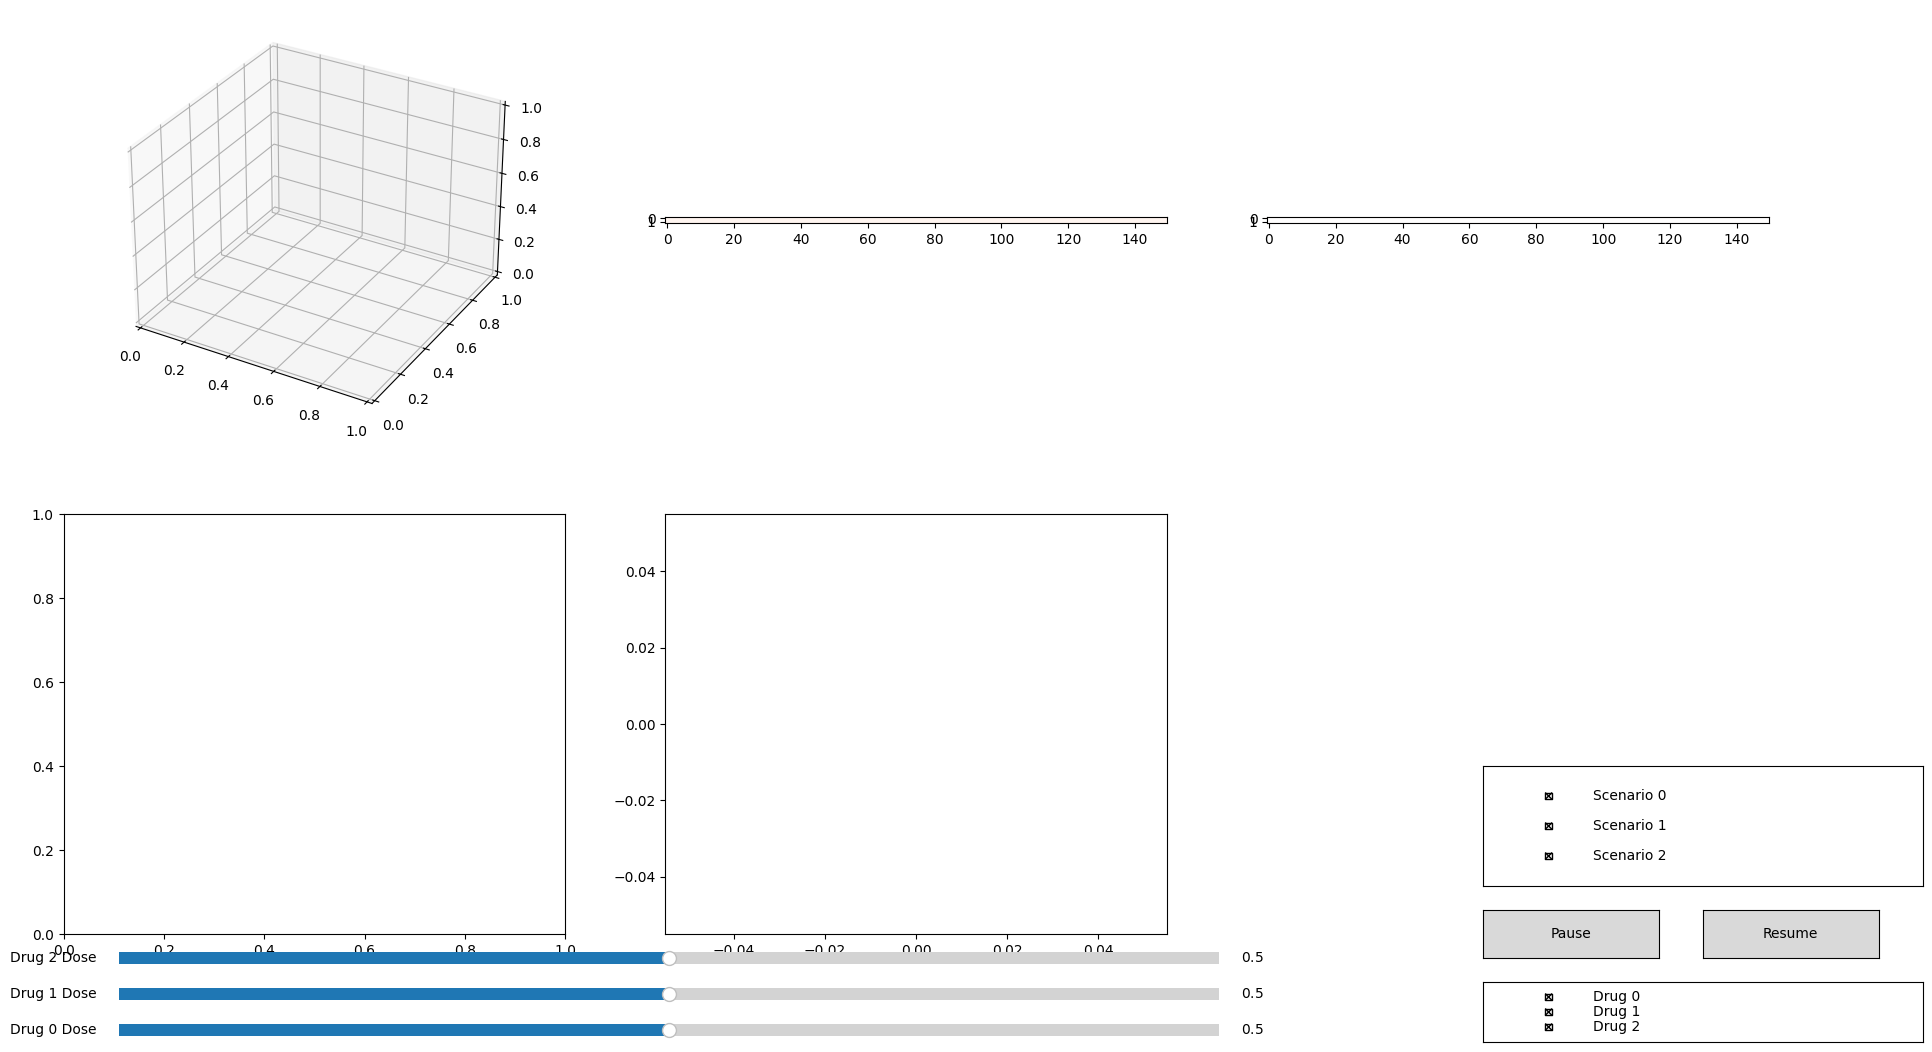

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, CheckButtons
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch

# ------------------- Constants -------------------
NUM_DRUGS = 3
NUM_TISSUES = 2
CELLS_PER_LAYER = 50
NUM_LAYERS = 3
TIMESTEPS = 100
NUM_SCENARIOS = 3
MIN_LENGTH = 500
MAX_LENGTH = 15000
TARGET_LENGTH = 10000
forecast_horizon = 10
NUM_CELLS = NUM_TISSUES * CELLS_PER_LAYER * NUM_LAYERS
device = torch.device("cpu")  # adjust for GPU

# ------------------- Placeholder functions -------------------
def multi_cell_step(cells, doses, neighbor_matrix, cross_signal, drugs):
    """Placeholder multi-cell step"""
    # Update cells randomly for demo purposes
    cells['tel_len'] += torch.randn(NUM_CELLS) * 10 + 1
    cells['tel_len'] = torch.clamp(cells['tel_len'], MIN_LENGTH, MAX_LENGTH)
    synergy = torch.rand(NUM_TISSUES, NUM_CELLS)
    reward = None
    obs = None
    return obs, reward, cells, synergy

def prepare_obs(cells):
    """Prepare observation tensor for AI policy"""
    return torch.randn(NUM_CELLS, 13)

class DummyPolicy:
    def __call__(self, obs):
        return torch.rand(NUM_CELLS, NUM_DRUGS), None, None
policy = DummyPolicy()

# ------------------- Initialize Cells -------------------
base_cells = {
    'tel_len': torch.randint(MIN_LENGTH, MAX_LENGTH, (NUM_CELLS,), dtype=torch.float),
    'types': torch.randint(0,3,(NUM_CELLS,)),
    'tissues': torch.randint(0,NUM_TISSUES,(NUM_CELLS,)),
    'alive': torch.ones(NUM_CELLS, dtype=bool),
    'debris': torch.zeros(NUM_CELLS),
    'stress': torch.zeros(NUM_CELLS),
    'tloop_vec': torch.randn(NUM_CELLS,3),
    'drug_bindings': torch.zeros(NUM_CELLS, NUM_DRUGS),
    'cumulative_mut': torch.zeros(NUM_CELLS)
}

scenario_cells = [base_cells.copy() for _ in range(NUM_SCENARIOS)]
scenario_pop_history = np.zeros((NUM_SCENARIOS, TIMESTEPS, 4, NUM_TISSUES))
neighbor_matrix = torch.eye(NUM_CELLS)
cross_signal = torch.zeros(NUM_TISSUES)
drugs = None

# ------------------- Setup Figure -------------------
fig = plt.figure(figsize=(22,12))
ax3d = fig.add_subplot(231, projection='3d')
ax_mut = fig.add_subplot(232)
ax_syn = fig.add_subplot(233)
ax_pop = fig.add_subplot(234)
ax_tel = fig.add_subplot(235)

# ------------------- Initialize Plots -------------------
scat3d = ax3d.scatter([],[],[],c=[], s=[])
mut_heat = ax_mut.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='Reds', vmin=0, vmax=0.05)
syn_heat = ax_syn.imshow(np.zeros((NUM_TISSUES, CELLS_PER_LAYER*NUM_LAYERS)), cmap='bwr', vmin=-1, vmax=1)

# Telomere lines and forecast per scenario
tel_lines_scenarios = [[ax_tel.plot([], [], label=f'Scenario {s} Tissue {t}')[0]
                        for t in range(NUM_TISSUES)]
                       for s in range(NUM_SCENARIOS)]
forecast_lines_scenarios = [[ax_tel.plot([], [], linestyle=':', color='orange')[0]
                             for t in range(NUM_TISSUES)]
                            for s in range(NUM_SCENARIOS)]
forecast_shades_scenarios = [[None for _ in range(NUM_TISSUES)] for _ in range(NUM_SCENARIOS)]

# ------------------- Sliders -------------------
axcolor = 'lightgoldenrodyellow'
slider_axes = [fig.add_axes([0.15,0.02+i*0.03,0.5,0.02], facecolor=axcolor) for i in range(NUM_DRUGS)]
sliders = [Slider(ax, f'Drug {i} Dose', 0.0, 1.0, valinit=0.5) for i, ax in enumerate(slider_axes)]
drug_active = [True]*NUM_DRUGS

# ------------------- Drug enable checkboxes -------------------
check_ax = fig.add_axes([0.77,0.02,0.2,0.05])
check = CheckButtons(check_ax, [f'Drug {i}' for i in range(NUM_DRUGS)], [True]*NUM_DRUGS)
def toggle_drug(label):
    idx = int(label.split()[-1])
    drug_active[idx] = not drug_active[idx]
check.on_clicked(toggle_drug)

# ------------------- Pause / Resume -------------------
paused = False
pause_ax = fig.add_axes([0.77,0.09,0.08,0.04]); pause_button = Button(pause_ax, 'Pause')
resume_ax = fig.add_axes([0.87,0.09,0.08,0.04]); resume_button = Button(resume_ax, 'Resume')
pause_button.on_clicked(lambda event: globals().update({'paused': True}))
resume_button.on_clicked(lambda event: globals().update({'paused': False}))

# ------------------- Scenario Check -------------------
scenario_ax = fig.add_axes([0.77, 0.15, 0.2, 0.1])
scenario_check = CheckButtons(scenario_ax, [f'Scenario {i}' for i in range(NUM_SCENARIOS)], [True]*NUM_SCENARIOS)
active_scenarios = [True]*NUM_SCENARIOS
def toggle_scenario(label):
    idx = int(label.split()[-1])
    active_scenarios[idx] = not active_scenarios[idx]
scenario_check.on_clicked(toggle_scenario)

# ------------------- Forecast Update -------------------
def update_forecast_scenario(s_idx, t_idx, frame, current_tel):
    # simple linear forecast with ±10% CI
    forecast_tel = [current_tel]; upper = [current_tel]; lower = [current_tel]
    for _ in range(forecast_horizon):
        delta = np.random.randn()*5  # placeholder AI effect
        forecast_tel.append(forecast_tel[-1]+delta)
        ci = abs(delta)*0.1
        upper.append(forecast_tel[-1]+ci)
        lower.append(forecast_tel[-1]-ci)
        forecast_tel[-1] = np.clip(forecast_tel[-1], MIN_LENGTH, MAX_LENGTH)
    x_forecast = np.arange(frame, frame+forecast_horizon+1)
    forecast_lines_scenarios[s_idx][t_idx].set_data(x_forecast, forecast_tel)
    if forecast_shades_scenarios[s_idx][t_idx]:
        for coll in forecast_shades_scenarios[s_idx][t_idx].collections:
            coll.remove()
    forecast_shades_scenarios[s_idx][t_idx] = ax_tel.fill_between(x_forecast, lower, upper, color='orange', alpha=0.2)

# ------------------- Animation -------------------
import matplotlib.animation as animation

def animate(frame):
    if paused: return

    for s_idx, scells in enumerate(scenario_cells):
        if not active_scenarios[s_idx]: continue

        # Determine doses
        if s_idx==0: dose_actions = torch.zeros(NUM_DRUGS)+0.3
        elif s_idx==1: dose_actions = torch.zeros(NUM_DRUGS)+0.8
        else: dose_actions = torch.tensor([s.val if drug_active[i] else 0.0 for i,s in enumerate(sliders)], device=device)

        obs, reward, scells, synergy = multi_cell_step(scells, dose_actions, neighbor_matrix, cross_signal, drugs)
        scenario_cells[s_idx] = scells

        # Update telomere lines and forecast
        for t_idx in range(NUM_TISSUES):
            tissue_mask = (scells['tissues']==t_idx)
            avg_tel = scells['tel_len'][tissue_mask].mean().item()
            xdata, ydata = tel_lines_scenarios[s_idx][t_idx].get_data()
            tel_lines_scenarios[s_idx][t_idx].set_data(np.append(xdata, frame), np.append(ydata, avg_tel))
            update_forecast_scenario(s_idx, t_idx, frame, avg_tel)

    return []

ani = animation.FuncAnimation(fig, animate, frames=TIMESTEPS, interval=200, blit=False)
plt.show()

In [ ]:
# Add a text box to the figure for scenario summary
summary_ax = fig.add_axes([0.77, 0.27, 0.2, 0.2])
summary_ax.axis('off')  # Hide axes
summary_text = summary_ax.text(0, 1, "", fontsize=10, verticalalignment='top')

In [ ]:
def update_scenario_summary(frame):
    summary_lines = []
    for s_idx, scells in enumerate(scenario_cells):
        if not active_scenarios[s_idx]:
            continue
        avg_tel = scells['tel_len'].mean().item()
        avg_mut = scells['cumulative_mut'].mean().item()
        survival = scells['alive'].sum().item() / NUM_CELLS * 100
        summary_lines.append(f"Scenario {s_idx}: Telomere={avg_tel:.1f}, Mut={avg_mut:.3f}, Survival={survival:.1f}%")
    summary_text.set_text("\n".join(summary_lines))

In [ ]:
def animate(frame):
    if paused:
        update_scenario_summary(frame)
        return

    for s_idx, scells in enumerate(scenario_cells):
        if not active_scenarios[s_idx]: continue

        # Determine doses (same as before)
        if s_idx==0: dose_actions = torch.zeros(NUM_DRUGS)+0.3
        elif s_idx==1: dose_actions = torch.zeros(NUM_DRUGS)+0.8
        else: dose_actions = torch.tensor([s.val if drug_active[i] else 0.0 for i,s in enumerate(sliders)], device=device)

        obs, reward, scells, synergy = multi_cell_step(scells, dose_actions, neighbor_matrix, cross_signal, drugs)
        scenario_cells[s_idx] = scells

        # Update telomere lines and forecast
        for t_idx in range(NUM_TISSUES):
            tissue_mask = (scells['tissues']==t_idx)
            avg_tel = scells['tel_len'][tissue_mask].mean().item()
            xdata, ydata = tel_lines_scenarios[s_idx][t_idx].get_data()
            tel_lines_scenarios[s_idx][t_idx].set_data(np.append(xdata, frame), np.append(ydata, avg_tel))
            update_forecast_scenario(s_idx, t_idx, frame, avg_tel)

    # Update summary panel
    update_scenario_summary(frame)

In [ ]:
export_ax = fig.add_axes([0.77, 0.5, 0.2, 0.04])
export_button = Button(export_ax, 'Export CSV')

In [ ]:
import pandas as pd

def export_data(event):
    for s_idx, scells in enumerate(scenario_cells):
        data = {
            'Timestep': np.arange(TIMESTEPS),
        }
        # Average telomere length per tissue
        for t_idx in range(NUM_TISSUES):
            xdata, ydata = tel_lines_scenarios[s_idx][t_idx].get_data()
            # Ensure length matches TIMESTEPS
            ydata_full = np.pad(ydata, (0, max(0, TIMESTEPS - len(ydata))), 'edge')
            data[f'Tissue{t_idx}_Telomere'] = ydata_full

        # Cumulative mutation and survival
        cum_mut = scells['cumulative_mut'].numpy()
        alive = scells['alive'].numpy()
        avg_mut = np.full(TIMESTEPS, cum_mut.mean())
        survival = np.full(TIMESTEPS, alive.sum()/NUM_CELLS*100)
        data['Avg_Mutation'] = avg_mut
        data['Survival_Percent'] = survival

        df = pd.DataFrame(data)
        df.to_csv(f'scenario_{s_idx}_export.csv', index=False)
    print("CSV export complete for all scenarios.")

In [ ]:
export_button.on_clicked(export_data)

In [ ]:
# Example: Define drug protocols per scenario (rows=scenarios, cols=timesteps)
# Values between 0 (no dose) and 1 (max dose)
drug_protocols = np.zeros((NUM_SCENARIOS, NUM_DRUGS, TIMESTEPS))

# Scenario 0: Conservative, low dose for all timesteps
drug_protocols[0, :, :] = 0.3

# Scenario 1: Aggressive, high dose pulses
drug_protocols[1, :, :] = 0.8
for t in range(0, TIMESTEPS, 10):
    drug_protocols[1, :, t:t+3] = 1.0  # short high-dose bursts

# Scenario 2: AI-guided, will use slider/AI prediction (set to -1 to indicate dynamic)
drug_protocols[2, :, :] = -1

In [ ]:
def animate(frame):
    if paused:
        update_scenario_summary(frame)
        return

    for s_idx, scells in enumerate(scenario_cells):
        if not active_scenarios[s_idx]: continue

        # Determine doses from protocol or sliders/AI
        if drug_protocols[s_idx,0,frame] >= 0:  # protocol defined
            dose_actions = torch.tensor(drug_protocols[s_idx, :, frame], device=device)
        else:  # dynamic AI or sliders
            if s_idx==2:  # AI-guided
                dose_actions = torch.tensor([s.val if drug_active[i] else 0.0 for i,s in enumerate(sliders)], device=device)
            else:
                dose_actions = torch.zeros(NUM_DRUGS)  # fallback

        obs, reward, scells, synergy = multi_cell_step(scells, dose_actions, neighbor_matrix, cross_signal, drugs)
        scenario_cells[s_idx] = scells

        # Update telomere lines and forecast
        for t_idx in range(NUM_TISSUES):
            tissue_mask = (scells['tissues']==t_idx)
            avg_tel = scells['tel_len'][tissue_mask].mean().item()
            xdata, ydata = tel_lines_scenarios[s_idx][t_idx].get_data()
            tel_lines_scenarios[s_idx][t_idx].set_data(np.append(xdata, frame), np.append(ydata, avg_tel))
            update_forecast_scenario(s_idx, t_idx, frame, avg_tel)

    # Update scenario summary
    update_scenario_summary(frame)

In [ ]:
# Create subplots for protocol editing
protocol_axes = [fig.add_axes([0.15, 0.7 - i*0.05, 0.5, 0.03]) for i in range(NUM_DRUGS)]
protocol_lines = []

for i, ax in enumerate(protocol_axes):
    ax.set_xlim(0, TIMESTEPS)
    ax.set_ylim(0, 1)
    ax.set_ylabel(f'Drug {i}')
    line, = ax.plot(np.arange(TIMESTEPS), drug_protocols[2, i, :], color='blue')
    protocol_lines.append(line)

In [ ]:
editing = {'drug_idx': None}

def on_press(event):
    # Check if click is on any protocol axis
    for i, ax in enumerate(protocol_axes):
        if ax == event.inaxes:
            editing['drug_idx'] = i
            update_protocol(event)

def on_release(event):
    editing['drug_idx'] = None

def on_motion(event):
    if editing['drug_idx'] is not None:
        update_protocol(event)

def update_protocol(event):
    idx = editing['drug_idx']
    if idx is None or event.xdata is None or event.ydata is None:
        return
    # Map x position to timestep
    t = int(np.clip(event.xdata, 0, TIMESTEPS-1))
    val = np.clip(event.ydata, 0, 1)
    drug_protocols[2, idx, t] = val
    # Update line plot
    protocol_lines[idx].set_ydata(drug_protocols[2, idx, :])
    fig.canvas.draw_idle()

fig.canvas.mpl_connect('button_press_event', on_press)
fig.canvas.mpl_connect('button_release_event', on_release)
fig.canvas.mpl_connect('motion_notify_event', on_motion)

In [ ]:
# Already handled: animate uses drug_protocols[2, :, frame] if >=0
# So edited values automatically take effect in simulation

In [ ]:
# Store multiple custom protocols
MAX_CUSTOM_PROTOCOLS = 3
custom_protocols = np.zeros((MAX_CUSTOM_PROTOCOLS, NUM_DRUGS, TIMESTEPS))

# Initialize with current editable protocol as first
custom_protocols[0] = drug_protocols[2].copy()

In [ ]:
compare_ax = fig.add_axes([0.77, 0.55, 0.2, 0.1])
compare_check = CheckButtons(compare_ax, [f'Protocol {i}' for i in range(MAX_CUSTOM_PROTOCOLS)], [True]*MAX_CUSTOM_PROTOCOLS)
active_custom = [True]*MAX_CUSTOM_PROTOCOLS

def toggle_custom(label):
    idx = int(label.split()[-1])
    active_custom[idx] = not active_custom[idx]

compare_check.on_clicked(toggle_custom)

In [ ]:
protocol_overlay_lines = [[ax.plot(np.arange(TIMESTEPS), custom_protocols[i, d, :], linestyle='--')[0]
                           for d in range(NUM_DRUGS)]
                          for i in range(MAX_CUSTOM_PROTOCOLS)]

In [ ]:
def get_combined_dose(s_idx, frame):
    """
    Returns the dose vector for a scenario at given frame.
    Priority:
    - If comparing custom protocols and active, overlay average or select one
    - Otherwise, use standard protocol or slider/AI
    """
    if s_idx == 2:  # custom editable scenario
        doses = np.zeros(NUM_DRUGS)
        count = 0
        for i in range(MAX_CUSTOM_PROTOCOLS):
            if active_custom[i]:
                doses += custom_protocols[i, :, frame]
                count += 1
        if count > 0:
            doses /= count  # simple averaging overlay
        else:
            # fallback to editable protocol
            doses = drug_protocols[2, :, frame]
        return torch.tensor(doses, device=device)
    elif drug_protocols[s_idx,0,frame] >=0:
        return torch.tensor(drug_protocols[s_idx, :, frame], device=device)
    else:
        # fallback to slider/AI
        return torch.tensor([s.val if drug_active[i] else 0.0 for i,s in enumerate(sliders)], device=device)